In [124]:

from pathlib import Path
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sns.set_style("whitegrid")
sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set('paper')
plt.rcParams["figure.dpi"] = 300
plt.rcParams['legend.fontsize'] = 18
results_path = Path.cwd().resolve().parent / "benchmarks/results/"
mcts_path = Path.cwd().resolve().parent / "tgnnexplainer/xgraph/saved_mcts_results"

os.makedirs("plots", exist_ok=True)

explainers = [
    "xtg",
    "attn",
    "pbone",
    "pg",
    "xtg-d",
    'xtg-og'
]
labels = {
    'xtg': 'MLPNavigator',
    'attn': 'ATTN',
    'pbone': 'PBONE',
    'pg': 'PG',
    'xtg-d': 'DotProductNavigator',
    'xtg-non': 'PGNavigator (NO NAV)',
    'xtg-og': 'PGNavigator'
}
dataset_to_index = {
    "simulate_v1": "Synthetic V1",
    "simulate_v2": "Synthetic V2",
    "wikipedia": "Wikipedia",
    "reddit": "Reddit",
}

og_models = {
    "attn",
    "pbone",
    "pg",
    "xtg-og"
}
navs = {
    "xtg",
    "xtg-d",
    "xtg-og"
}

In [125]:
## Their data
df_tgat_theirs = {
    ("Wikipedia", "Best FID"): {
        "ATTN": 0.891,
        "PBONE": 0.027,
        "PG": 1.354,
        "PGNavigator": 1.836,
    },
    ("Wikipedia", "AUFSC"): {
        "ATTN": 0.564,
        "PBONE": -2.227,
        "PG": 0.564,
        "PGNavigator": 1.477,
    },
    ("Reddit", "Best FID"): {
        "ATTN": 0.658,
        "PBONE": 0.167,
        "PG": 0.804,
        "PGNavigator": 1.518,
    },
    ("Reddit", "AUFSC"): {
        "ATTN": -0.654,
        "PBONE": -2.492,
        "PG": -0.369,
        "PGNavigator": 1.076,
    },
    ("Simulate V1", "Best FID"): {
        "ATTN": 0.555,
        "PBONE": 0.044,
        "PG": 0.555,
        "PGNavigator": 0.78,
    },
    ("Simulate V1", "AUFSC"): {
        "ATTN": -0.081,
        "PBONE": -2.882,
        "PG": 0.39,
        "PGNavigator": 0.666,
    },
    ("Simulate V2", "Best FID"): {
        "ATTN": 0.605,
        "PBONE": 0.096,
        "PG": 1.329,
        "PGNavigator": 1.63,
    },
    ("Simulate V2", "AUFSC"): {
        "ATTN": 0.291,
        "PBONE": -4.771,
        "PG": -0.926,
        "PGNavigator": 1.331,
    },
}

df_tgn_theirs = {
    ("Wikipedia", "Best FID"): {
        "ATTN": 0.479,
        "PBONE": 0.296,
        "PG": 0.464,
        "PGNavigator": 0.866,
    },
    ("Wikipedia", "AUFSC"): {
        "ATTN": 0.231,
        "PBONE": -0.601,
        "PG": -0.231,
        "PGNavigator": 0.59,
    },
    ("Reddit", "Best FID"): {
        "ATTN": 0.575,
        "PBONE": 0.34,
        "PG": 0.679,
        "PGNavigator": 1.362,
    },
    ("Reddit", "AUFSC"): {"ATTN": 0.289, "PBONE": -0.256, "PG": 0.02, "PGNavigator": 1.113},
    ("Simulate V1", "Best FID"): {
        "ATTN": 2.178,
        "PBONE": 0.001,
        "PG": 2.006,
        "PGNavigator": 2.708,
    },
    ("Simulate V1", "AUFSC"): {
        "ATTN": 1.624,
        "PBONE": -3.311,
        "PG": 0.626,
        "PGNavigator": 2.281,
    },
    ("Simulate V2", "Best FID"): {
        "ATTN": 0.988,
        "PBONE": 0.32,
        "PG": 1.012,
        "PGNavigator": 4.356,
    },
    ("Simulate V2", "AUFSC"): {
        "ATTN": -1.338,
        "PBONE": -5.413,
        "PG": -1.338,
        "PGNavigator": 3.224,
    },
}

df_tgat_theirs = pd.DataFrame.from_dict(df_tgat_theirs, orient="columns")
df_tgn_theirs = pd.DataFrame.from_dict(df_tgn_theirs, orient="columns")
# df_tgat_theirs

## TGAT
### Wikipedia

Best Fid: {'xtg': 1.3948060590028764, 'attn': 0.8115232161860914, 'pbone': 1.2597488984894007, 'pg': 0.6847479770611972, 'xtg-d': 1.2527445781230926, 'xtg-og': 1.5133539831638336}
AUFSC: {'xtg': 0.881114971932955, 'attn': 0.5135449832312763, 'pbone': 0.8691429948334582, 'pg': -0.37464903415529993, 'xtg-d': 0.5978107269029133, 'xtg-og': 1.1426431754780932}
attn	 FID: 0.4633937401310318 	 AUC: 0.5135449832312763
pbone	 FID: 0.8280495267829725 	 AUC: 0.8691429948334582
pg	 FID: -0.43719394557967417 	 AUC: -0.37464903415529993
xtg-og	 FID: 0.9997443335095335 	 AUC: 1.1426431754780932


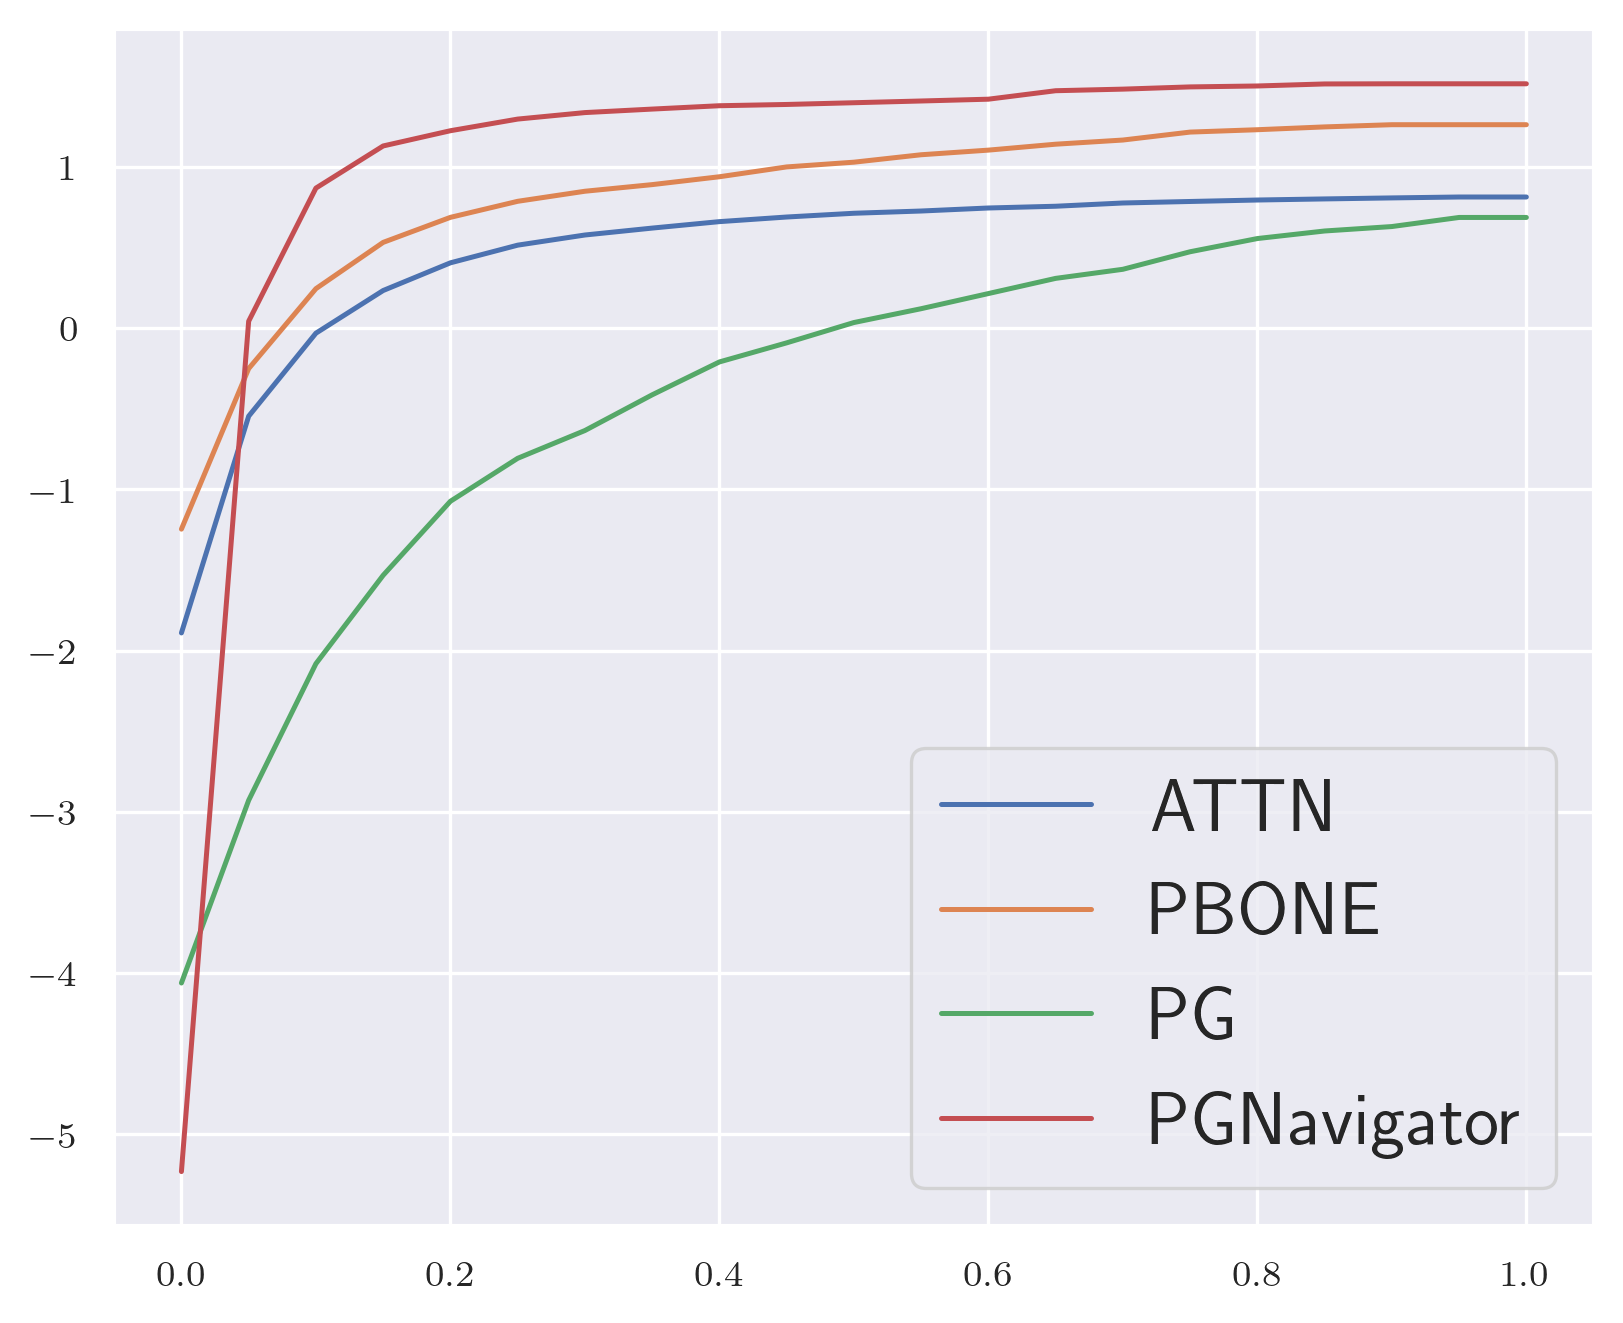

In [126]:
tgat_wikipedia_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgat_wikipedia_subgraphx_tg_110314_to_155151_eval_mlp_true_pg_positive_th20.csv",
            "tgat_wikipedia_attn_explainer_tg_110314_to_155614_eval_th25.csv",
            "tgat_wikipedia_pbone_explainer_tg_110314_to_155614_eval_th25.csv",
            "tgat_wikipedia_pg_explainer_tg_110314_to_155614_eval_th25.csv",
            "tgat_wikipedia_subgraphx_tg_110314_to_155151_eval_dot_true_pg_positive_th20.csv",
            "tgat_wikipedia_subgraphx_tg_110314_to_155151_eval_pg_true_pg_positive_th20.csv",
        ],
    )
}

tgat_wikipedia_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean()
    for k, v in tgat_wikipedia_files.items()
}

tgat_wikipedia_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgat_wikipedia_tabs.items()
}
tgat_wikipedia_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index)
    for k, tab in tgat_wikipedia_tabs.items()
}

print("Best Fid:", tgat_wikipedia_best_fids)
print("AUFSC:", tgat_wikipedia_aufsc)

for k, tab in tgat_wikipedia_tabs.items():
    if k in og_models:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].mean()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend()
plt.tight_layout()
plt.savefig("plots/tgat_wikipedia.png")

xtg	 FID: 0.7478472843198549 	 AUC: 0.881114971932955
xtg-d	 FID: 0.47465130141315354 	 AUC: 0.5978107269029133
xtg-og	 FID: 0.9997443335095335 	 AUC: 1.1426431754780932


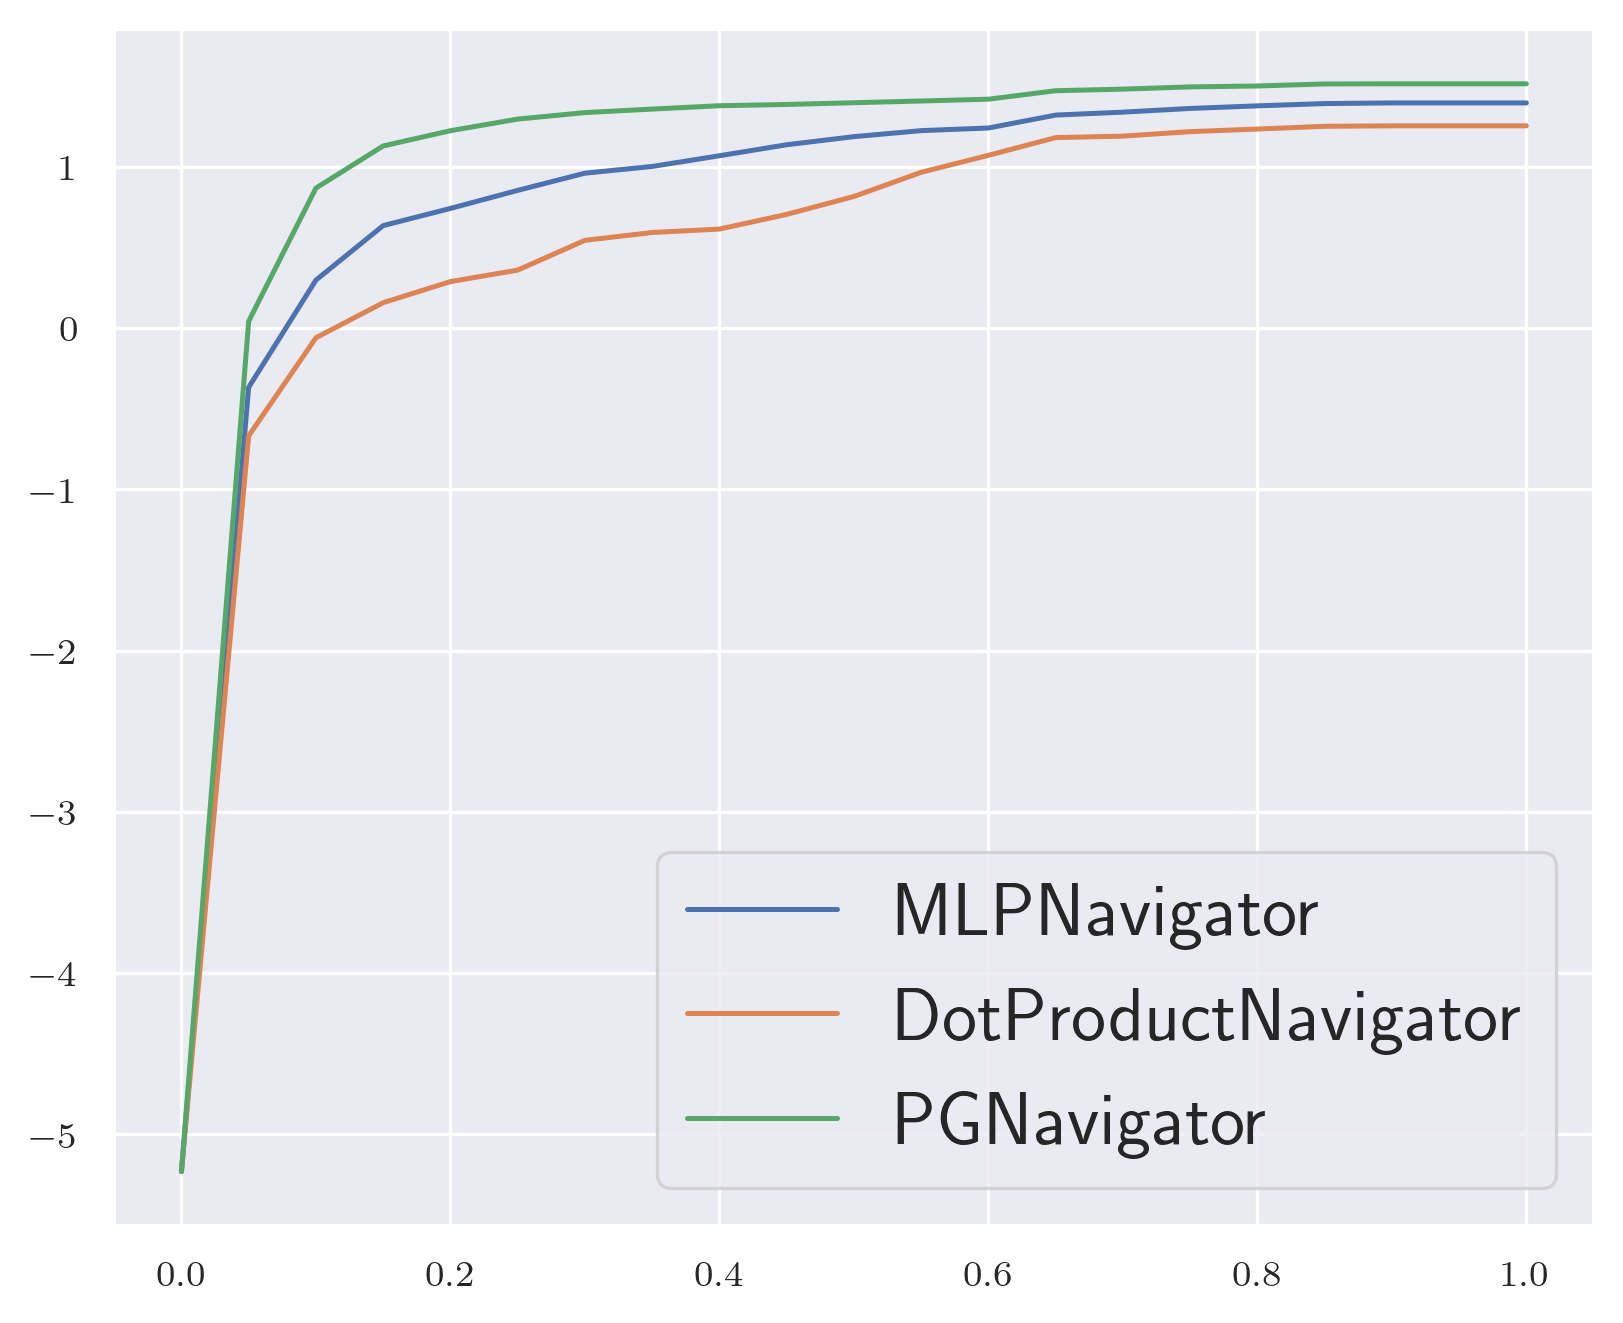

In [127]:

for k, tab in tgat_wikipedia_tabs.items():
    if k in navs:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].mean()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend()
plt.tight_layout()
plt.savefig("plots/tgat_wikipedia_navs.png")

## Reddit

Best Fid: {'xtg': 1.1622504767030477, 'attn': 0.46591258417069914, 'pbone': 1.2121049303114415, 'pg': 0.5481336815953255, 'xtg-d': 1.2233345153182744, 'xtg-og': 1.1554385360330344}
AUFSC: {'xtg': 0.36793317848630247, 'attn': -0.9362572968028485, 'pbone': 0.8172783054485916, 'pg': -0.8289851863332094, 'xtg-d': 0.5960841231141238, 'xtg-og': 0.4440228421706707}
attn	 FID: 0.46591258417069914 	 AUC: -0.9362572968028485
pbone	 FID: 1.2121049303114415 	 AUC: 0.8172783054485916
pg	 FID: 0.5481336815953255 	 AUC: -0.8289851863332094
xtg-og	 FID: 1.1554385360330344 	 AUC: 0.4440228421706707


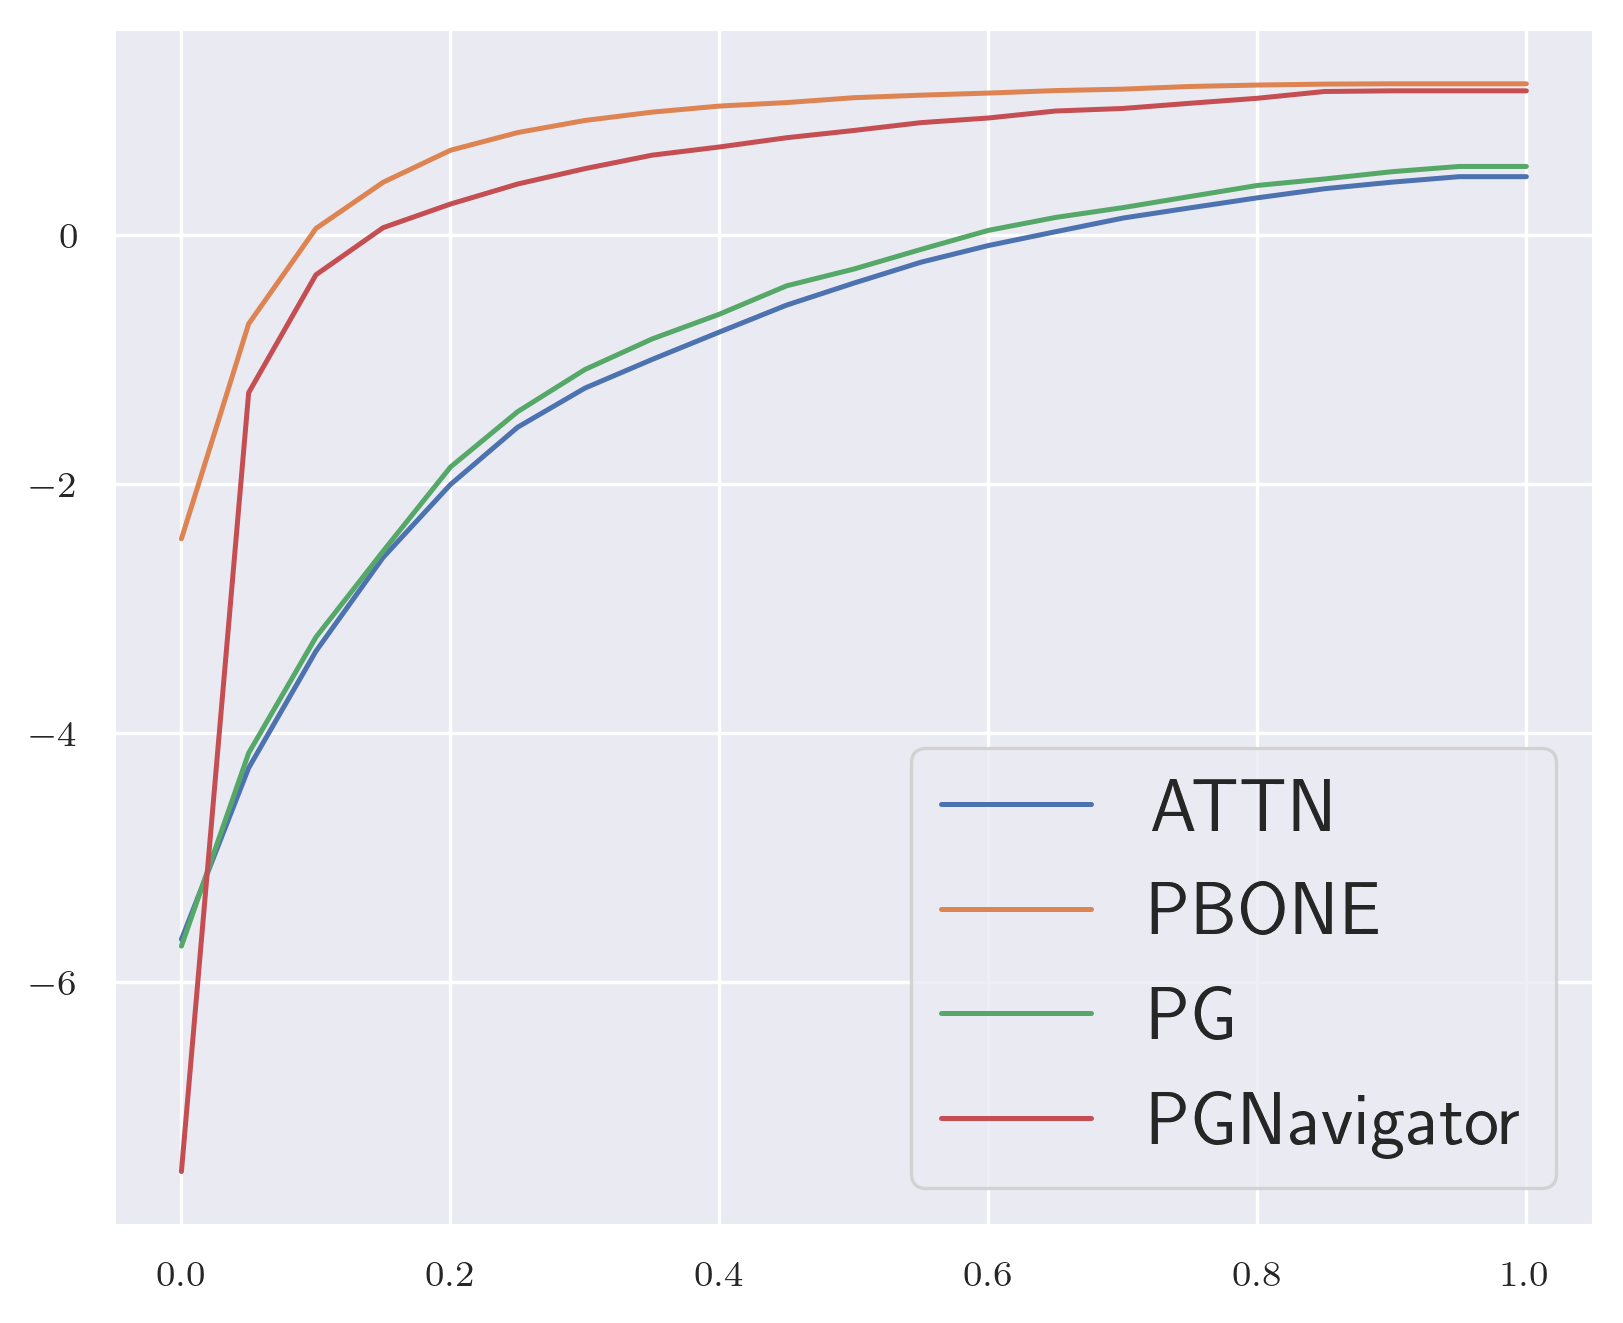

In [128]:
tgat_reddit_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgat_reddit_subgraphx_tg_470920_to_663534_eval_mlp_true_pg_positive_th20.csv",
            "tgat_reddit_attn_explainer_tg_470920_to_665351_eval_th25.csv",
            "tgat_reddit_pbone_explainer_tg_470920_to_665351_eval_th25.csv",
            "tgat_reddit_pg_explainer_tg_470920_to_665351_eval_th25.csv",
            "tgat_reddit_subgraphx_tg_470920_to_663534_eval_dot_true_pg_positive_th20.csv",
            "tgat_reddit_subgraphx_tg_470920_to_663534_eval_pg_true_pg_positive_th20.csv",
        ],
    )
}

tgat_reddit_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean() for k, v in tgat_reddit_files.items()
}

tgat_reddit_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgat_reddit_tabs.items()
}

tgat_reddit_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index) for k, tab in tgat_reddit_tabs.items()
}

print("Best Fid:", tgat_reddit_best_fids)
print("AUFSC:", tgat_reddit_aufsc)

for k, tab in tgat_reddit_tabs.items():
    if k in og_models:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend()
plt.tight_layout()
plt.savefig("plots/tgat_reddit.png")

xtg	 FID: 1.1622504767030477 	 AUC: 0.36793317848630247
xtg-d	 FID: 1.2233345153182744 	 AUC: 0.5960841231141238
xtg-og	 FID: 1.1554385360330344 	 AUC: 0.4440228421706707


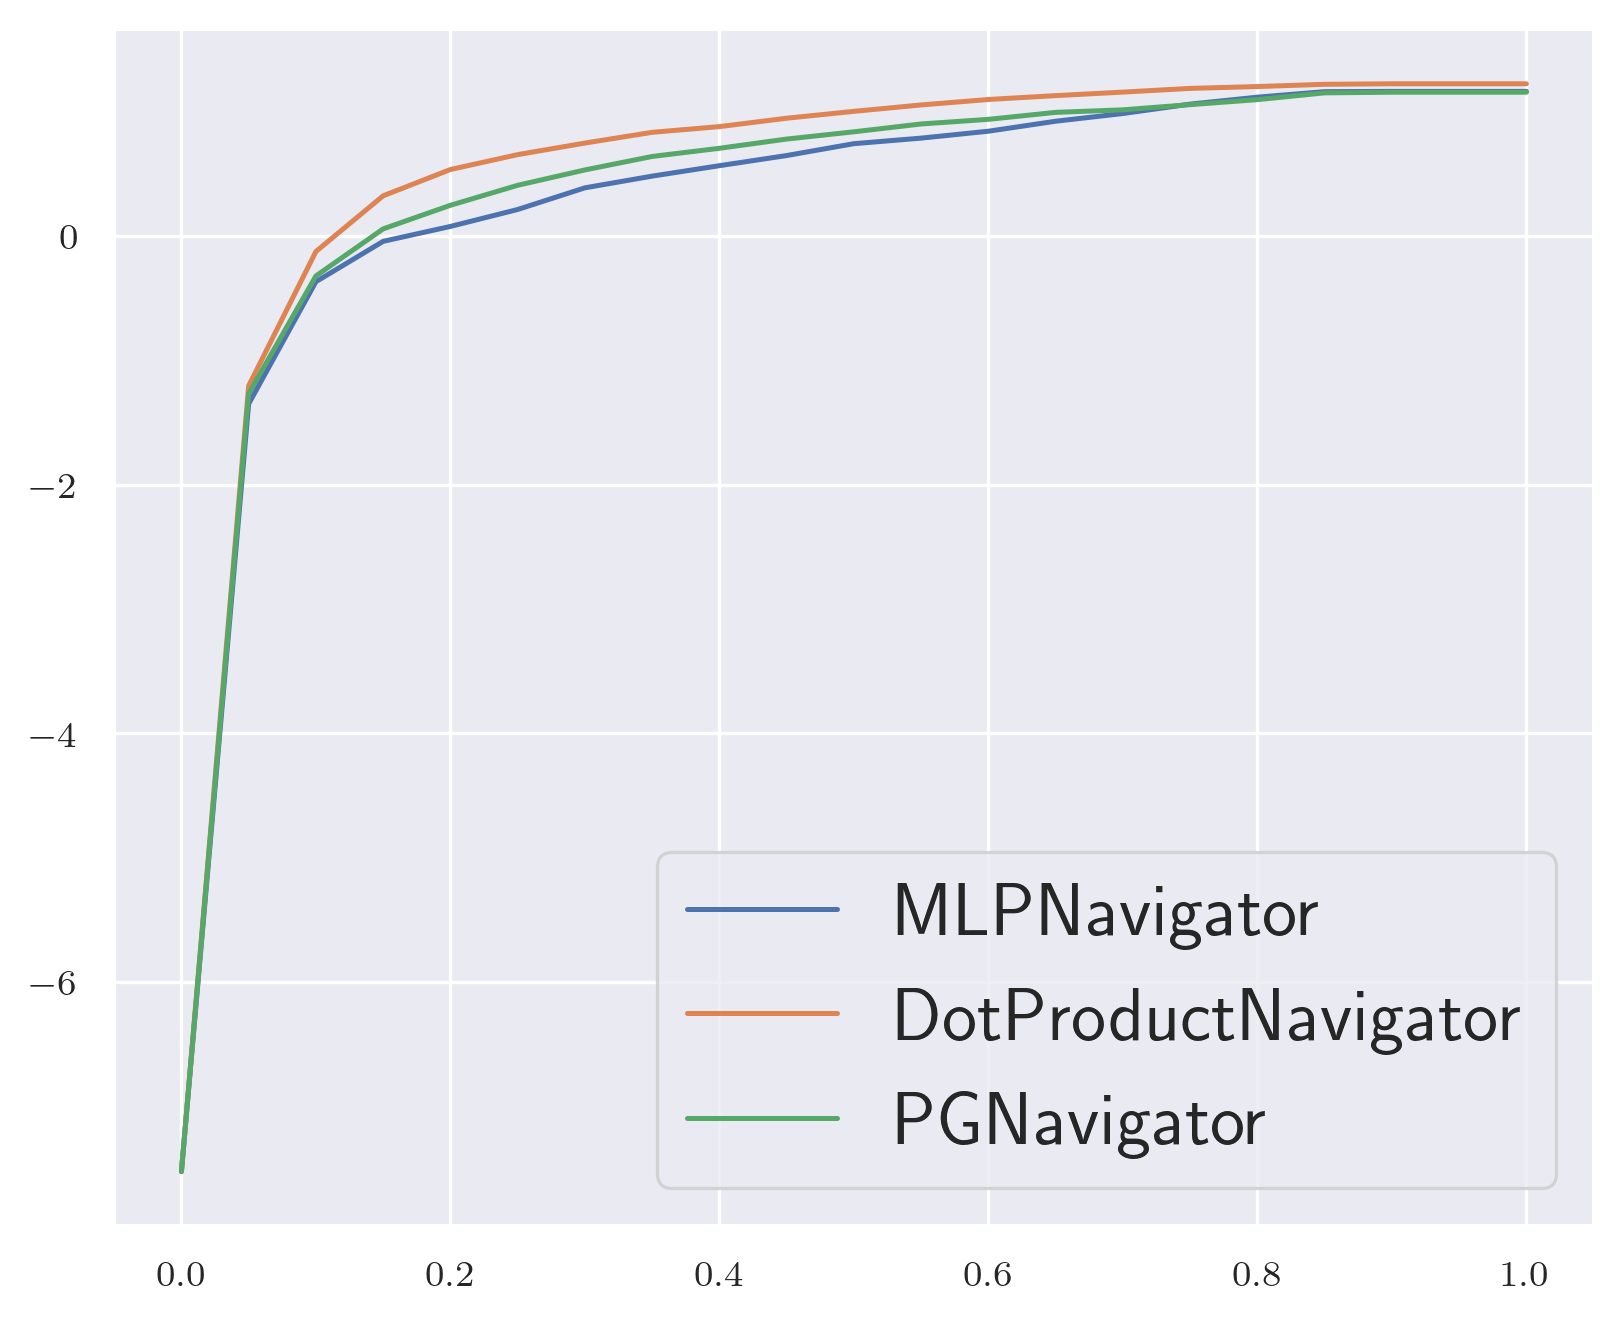

In [129]:

for k, tab in tgat_reddit_tabs.items():
    if k in navs:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend()
plt.tight_layout()
plt.savefig("plots/tgat_reddit_navs.png")

## Simulate V1

Best Fid: {'xtg': 1.1817334110245985, 'attn': 0.621812455534935, 'pbone': 1.0244546887874604, 'pg': 0.6777639939188957, 'xtg-d': 0.9874230894972297, 'xtg-og': 1.1551832115533305}
AUFSC: {'xtg': 0.7768883111722328, 'attn': 0.17859825834110377, 'pbone': 0.6275241337478161, 'pg': -0.3059464243195951, 'xtg-d': 0.46933882975695185, 'xtg-og': 0.8424836973057074}
attn	 FID: 0.621812455534935 	 AUC: 0.17859825834110377
pbone	 FID: 1.0244546887874604 	 AUC: 0.6275241337478161
pg	 FID: 0.6777639939188957 	 AUC: -0.3059464243195951
xtg-og	 FID: 1.1551832115533305 	 AUC: 0.8424836973057074


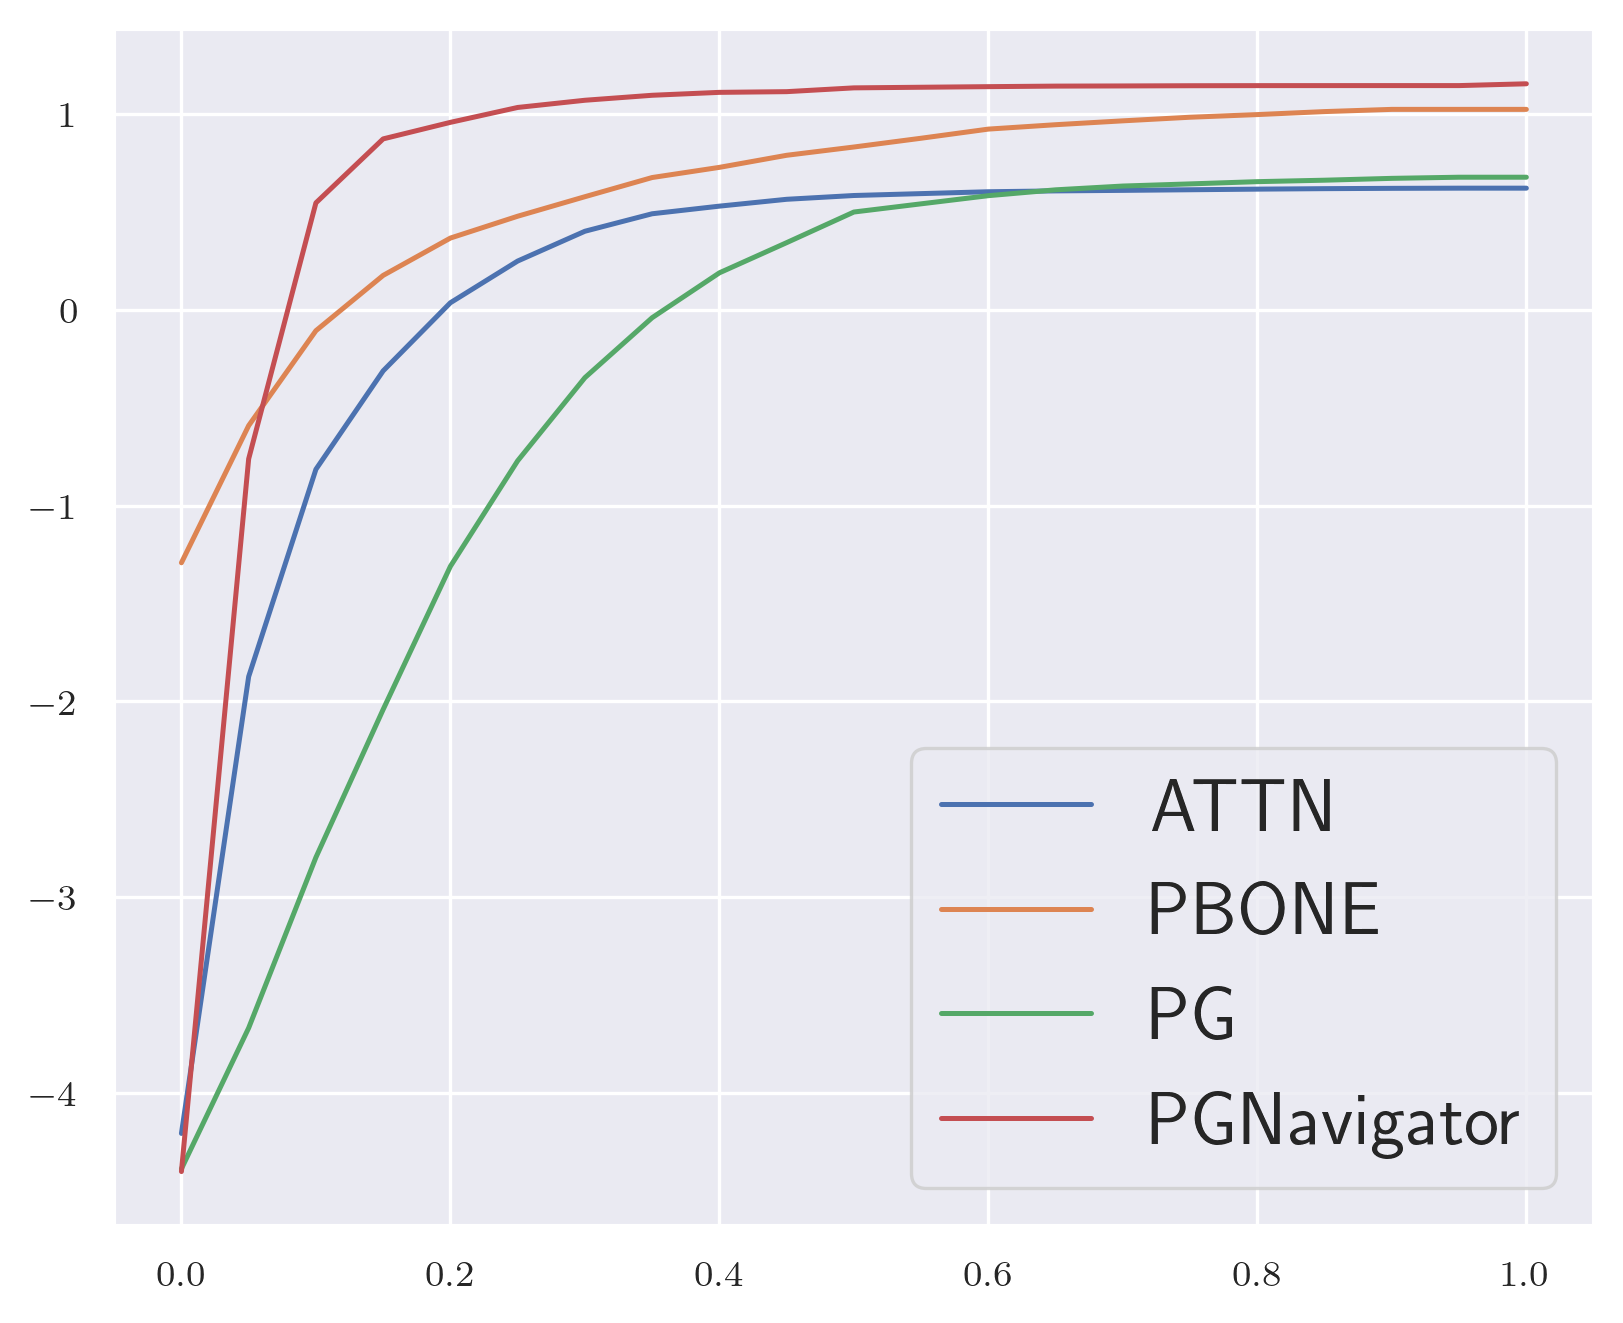

In [130]:
tgat_simulate_v1_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgat_simulate_v1_subgraphx_tg_3_to_15902_eval_mlp_true_pg_positive_th20.csv",
            "tgat_simulate_v1_attn_explainer_tg_3_to_15902_eval_th25.csv",
            "tgat_simulate_v1_pbone_explainer_tg_3_to_15902_eval_th25.csv",
            "tgat_simulate_v1_pg_explainer_tg_3_to_15902_eval_th25.csv",
            "tgat_simulate_v1_subgraphx_tg_3_to_15902_eval_dot_true_pg_positive_th20.csv",
            "tgat_simulate_v1_subgraphx_tg_3_to_15902_eval_pg_true_pg_positive_th20.csv"
        ],
    )
}

tgat_simulate_v1_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean()
    for k, v in tgat_simulate_v1_files.items()
}

tgat_simulate_v1_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgat_simulate_v1_tabs.items()
}

tgat_simulate_v1_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index)
    for k, tab in tgat_simulate_v1_tabs.items()
}
print("Best Fid:", tgat_simulate_v1_best_fids)
print("AUFSC:", tgat_simulate_v1_aufsc)

for k, tab in tgat_simulate_v1_tabs.items():
    if k in og_models:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgat_simulate_v1.png")

xtg	 FID: 1.1817334110245985 	 AUC: 0.7768883111722328
xtg-d	 FID: 0.9874230894972297 	 AUC: 0.46933882975695185
xtg-og	 FID: 1.1551832115533305 	 AUC: 0.8424836973057074


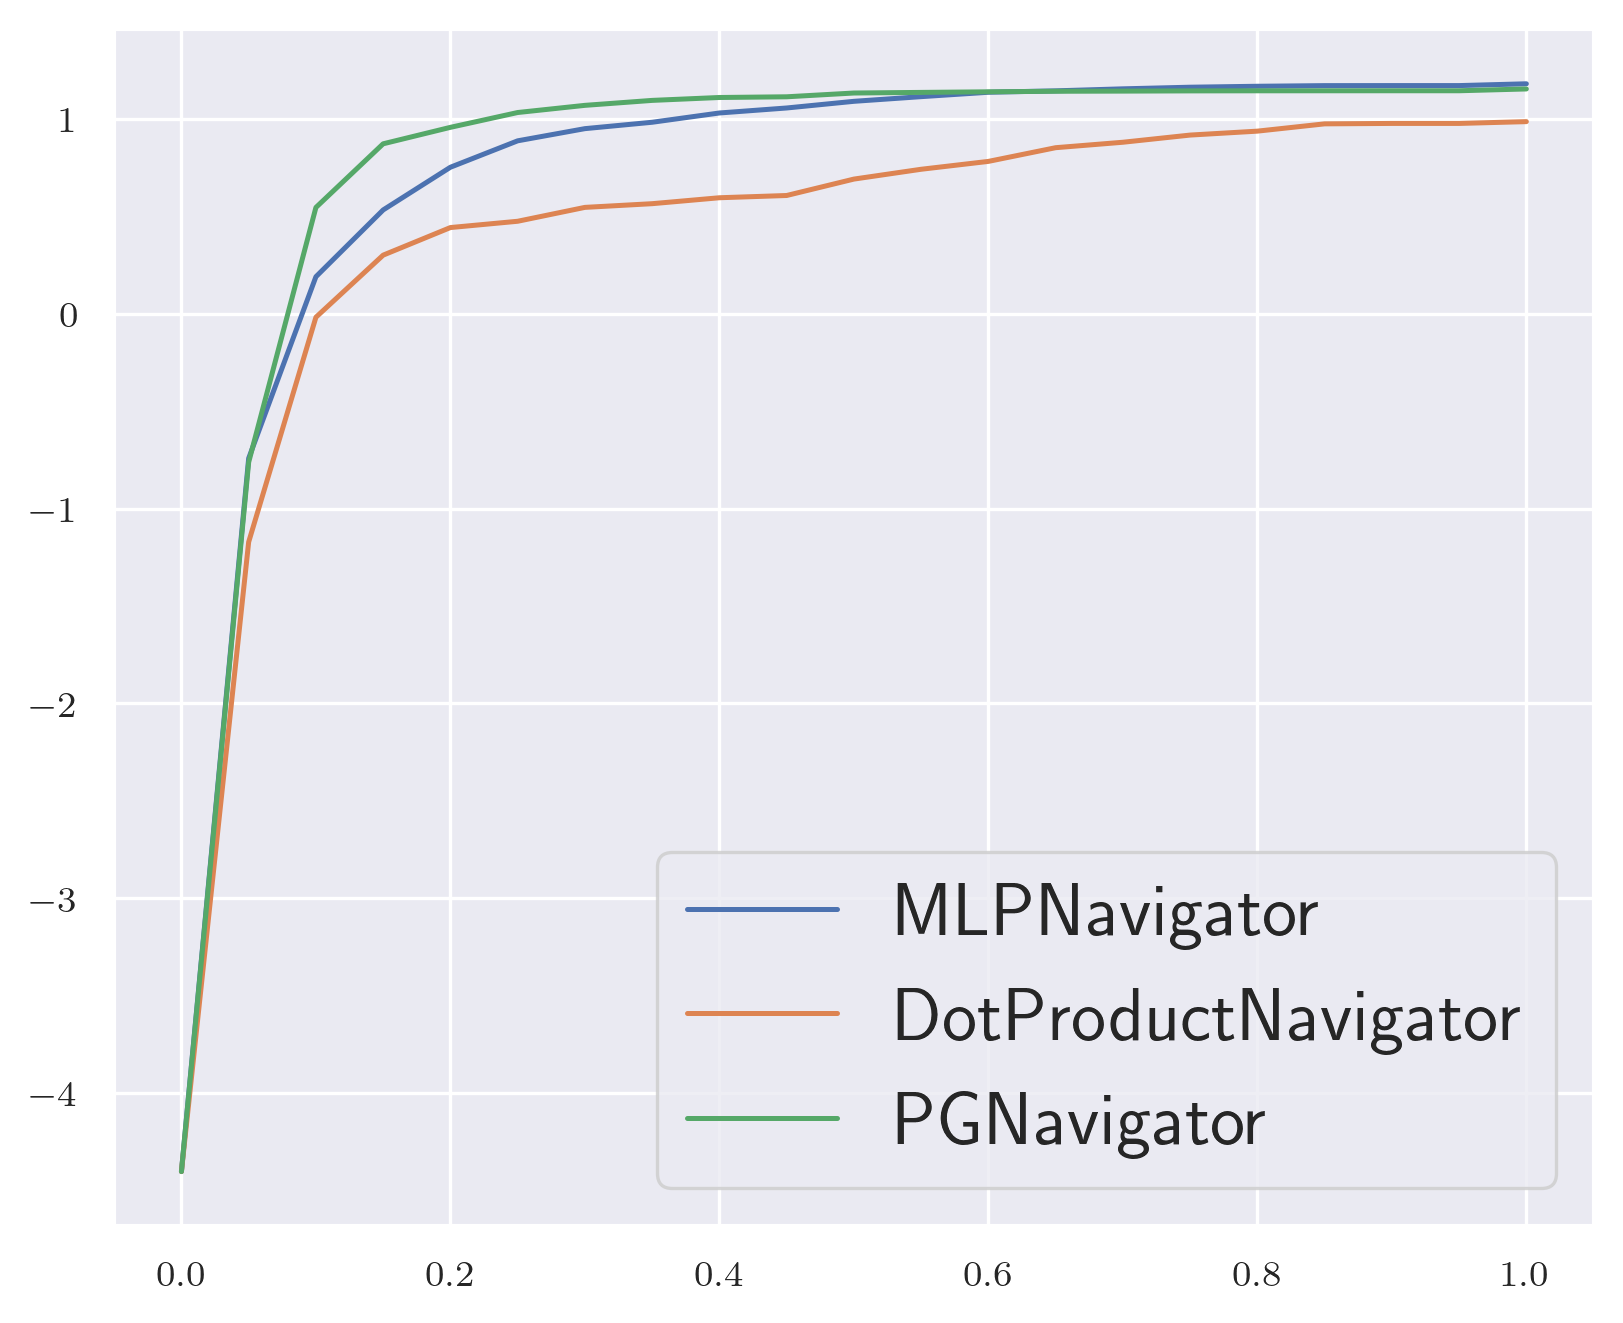

In [131]:

for k, tab in tgat_simulate_v1_tabs.items():
    if k in navs:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend()
plt.tight_layout()
plt.savefig("plots/tgat_simulate_v1_navs.png")

## Simulate V2

Best Fid: {'xtg': 0.7947402311598554, 'attn': 0.05967254871129988, 'pbone': 0.7078214499056339, 'pg': 0.7464178370833396, 'xtg-d': 0.7834118121102744, 'xtg-og': 0.7887831419414165}
AUFSC: {'xtg': 0.6050593150250029, 'attn': -0.08515523201450705, 'pbone': 0.44202910242751237, 'pg': 0.22783191517032678, 'xtg-d': 0.7127872711978853, 'xtg-og': 0.7195822088029601}
attn	 FID: 0.05967254871129988 	 AUC: -0.08515523201450705
pbone	 FID: 0.7078214499056339 	 AUC: 0.44202910242751237
pg	 FID: 0.7464178370833396 	 AUC: 0.22783191517032678
xtg-og	 FID: 0.7887831419414165 	 AUC: 0.7195822088029601


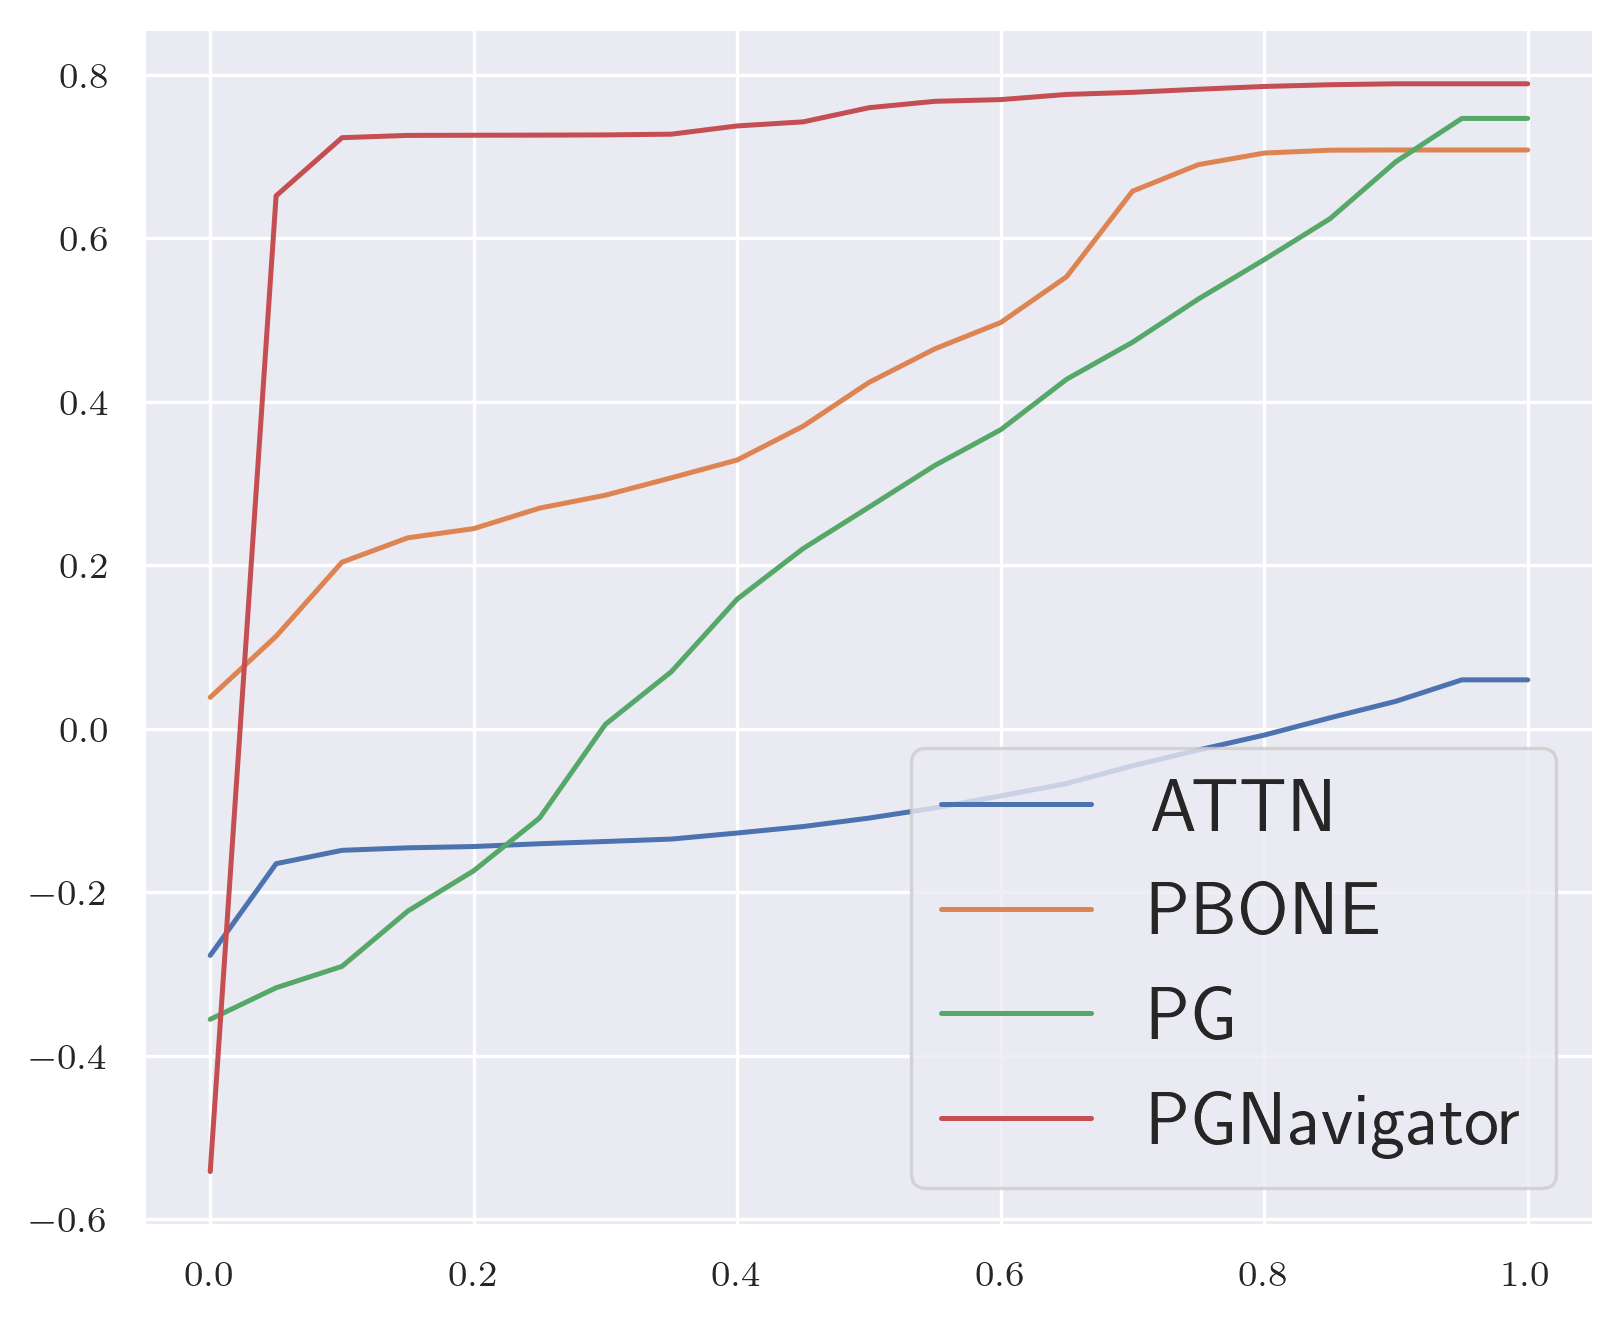

In [132]:
tgat_simulate_v2_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgat_simulate_v2_subgraphx_tg_3_to_21752_eval_mlp_true_pg_positive_th20.csv",
            "tgat_simulate_v2_attn_explainer_tg_3_to_21752_eval_th25.csv",
            "tgat_simulate_v2_pbone_explainer_tg_3_to_21752_eval_th25.csv",
            "tgat_simulate_v2_pg_explainer_tg_3_to_21752_eval_th25.csv",
            "tgat_simulate_v2_subgraphx_tg_3_to_21752_eval_dot_true_pg_positive_th20.csv",
            "tgat_simulate_v2_subgraphx_tg_3_to_21752_eval_pg_true_pg_positive_th20.csv"
        ],
    )
}
tgat_simulate_v2_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean()
    for k, v in tgat_simulate_v2_files.items()
}
tgat_simulate_v2_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgat_simulate_v2_tabs.items()
}
tgat_simulate_v2_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index)
    for k, tab in tgat_simulate_v2_tabs.items()
}
print("Best Fid:", tgat_simulate_v2_best_fids)
print("AUFSC:", tgat_simulate_v2_aufsc)

for k, tab in tgat_simulate_v2_tabs.items():
    if k in og_models:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgat_simulate_v2.png")

xtg	 FID: 0.7947402311598554 	 AUC: 0.6050593150250029
xtg-d	 FID: 0.7834118121102744 	 AUC: 0.7127872711978853
xtg-og	 FID: 0.7887831419414165 	 AUC: 0.7195822088029601


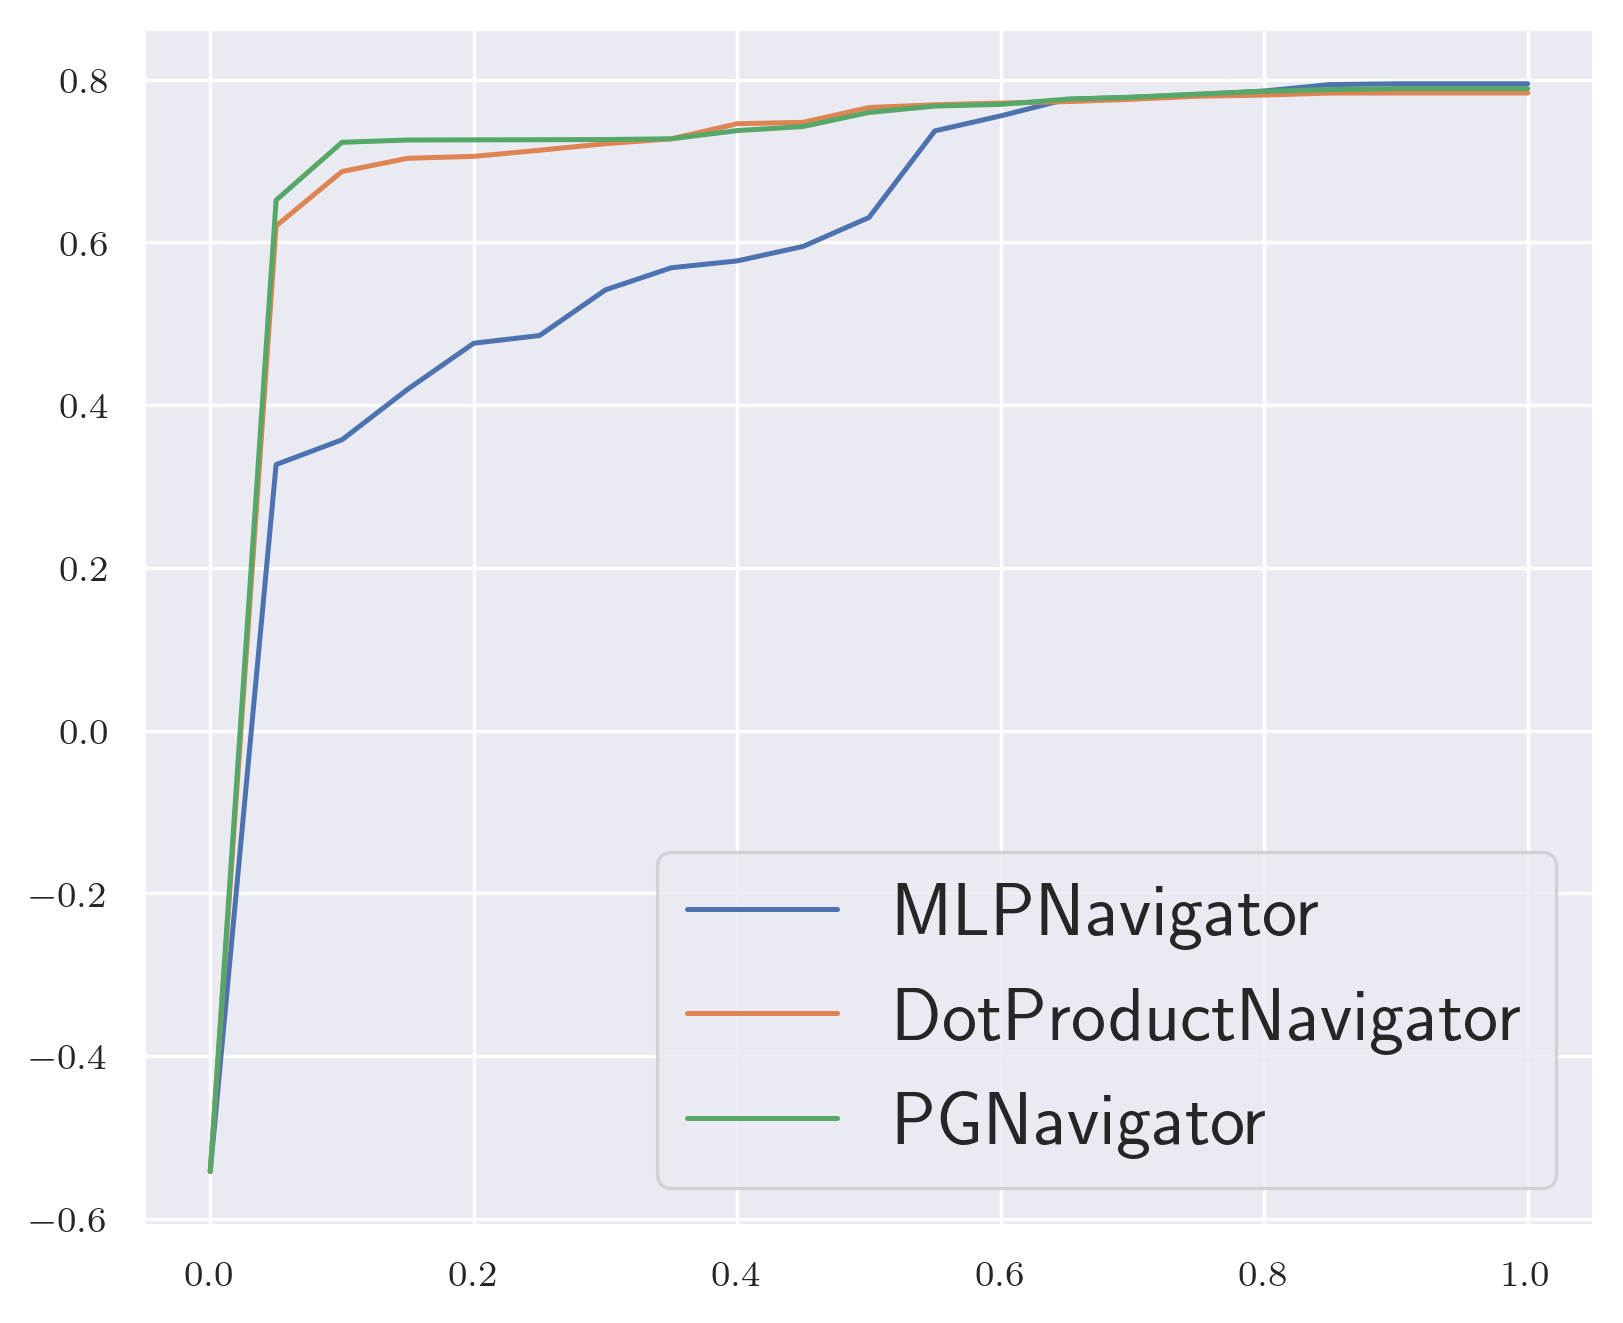

In [133]:

for k, tab in tgat_simulate_v2_tabs.items():
    if k in navs:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend()
plt.tight_layout()
plt.savefig("plots/tgat_simulate_v2_navs.png")

# TGN
## Wikipedia

Best Fid: {'xtg': 0.9347367412596941, 'attn': 0.5148783878684043, 'pbone': 0.6475937870591879, 'pg': 0.45970433977246283, 'xtg-d': 0.9080627510696649, 'xtg-og': 0.920611462071538}
AUFSC: {'xtg': 0.49106371287442735, 'attn': 0.3126810891754925, 'pbone': 0.3932880073327572, 'pg': -0.3673622658334673, 'xtg-d': 0.3711702890824526, 'xtg-og': 0.6803379071932285}
attn	 FID: 0.5148783878684043 	 AUC: 0.3126810891754925
pbone	 FID: 0.6475937870591879 	 AUC: 0.3932880073327572
pg	 FID: 0.45970433977246283 	 AUC: -0.3673622658334673
xtg-og	 FID: 0.920611462071538 	 AUC: 0.6803379071932285


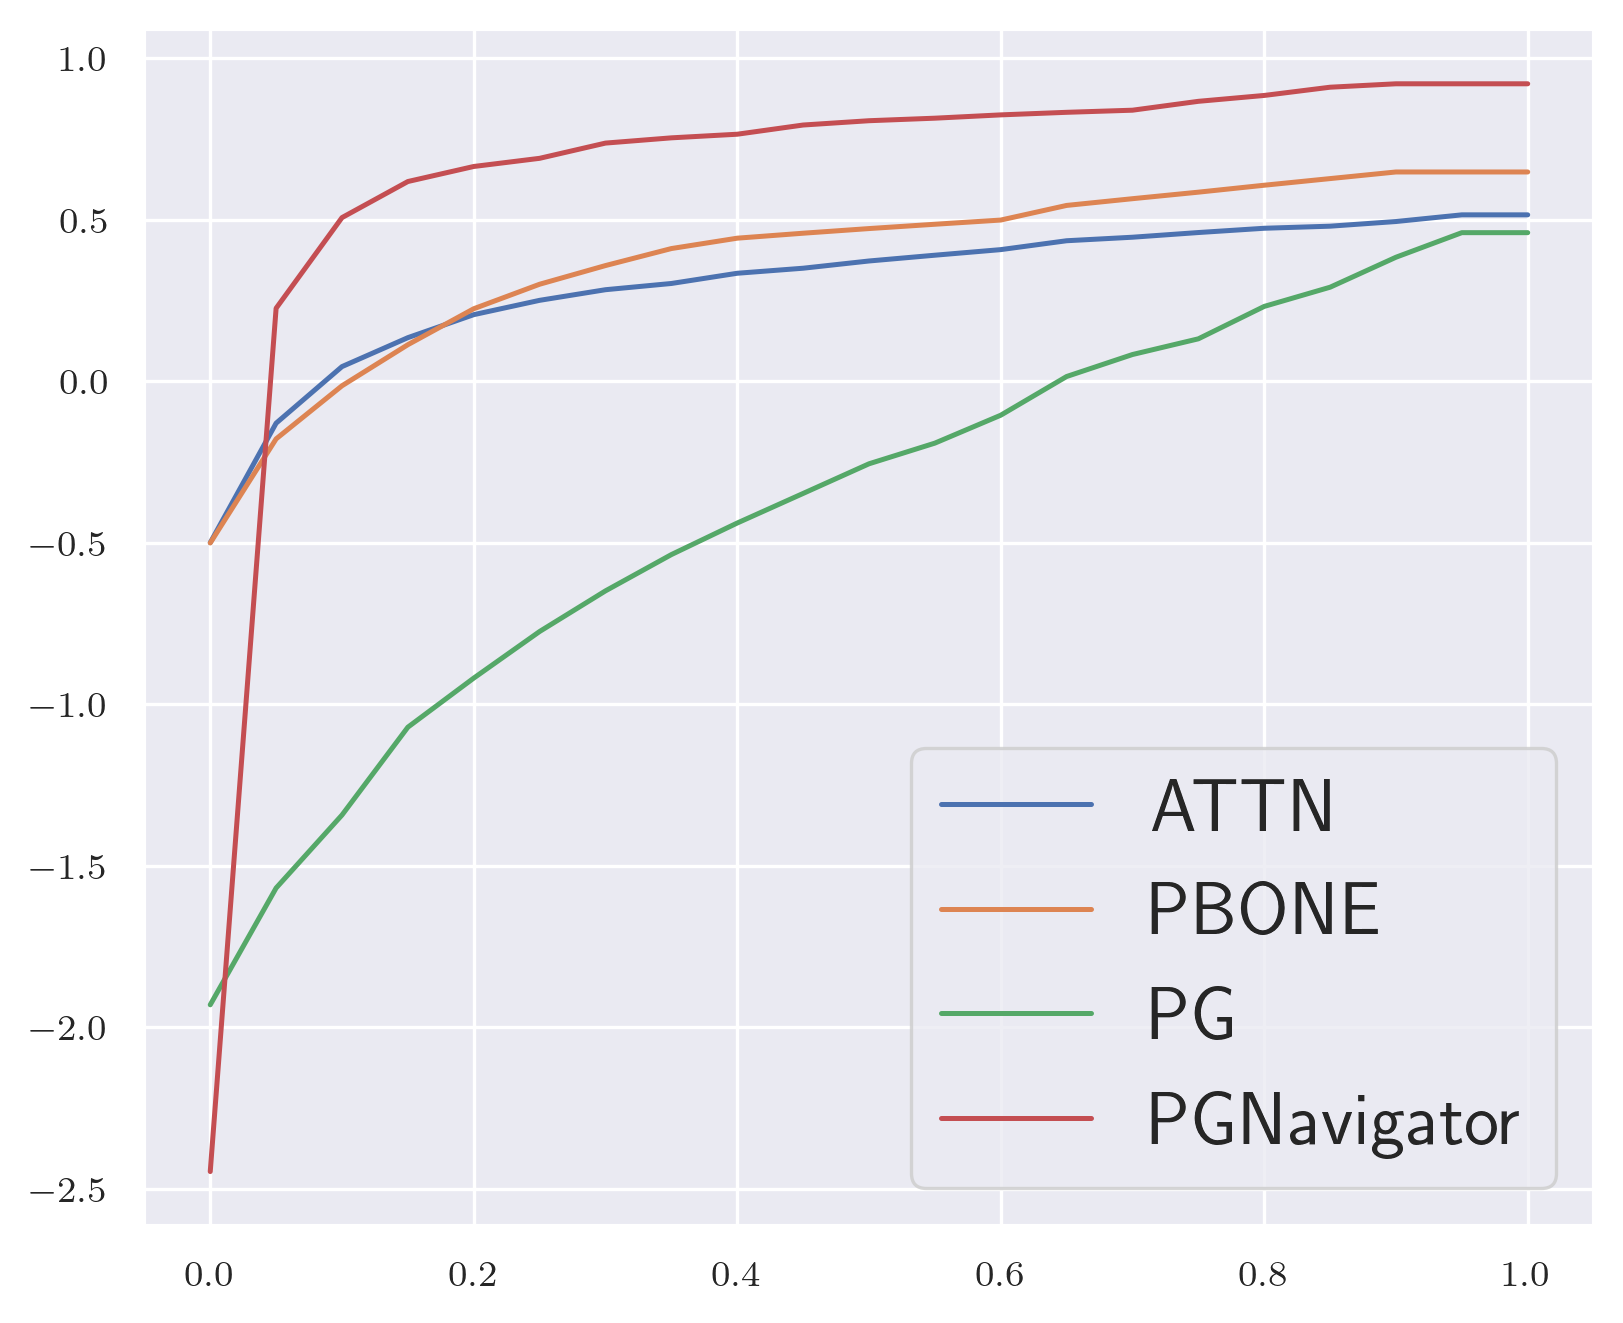

In [134]:
tgn_wikipedia_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgn_wikipedia_subgraphx_tg_110314_to_155151_eval_mlp_true_pg_positive_th20.csv",
            "tgn_wikipedia_attn_explainer_tg_110314_to_155614_eval_th25.csv",
            "tgn_wikipedia_pbone_explainer_tg_110314_to_155614_eval_th25.csv",
            "tgn_wikipedia_pg_explainer_tg_110314_to_155614_eval_th25.csv",
            "tgn_wikipedia_subgraphx_tg_110314_to_155151_eval_dot_true_pg_positive_th20.csv",
            "tgn_wikipedia_subgraphx_tg_110314_to_155151_eval_pg_true_pg_positive_th20.csv"
        ],
    )
}

tgn_wikipedia_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean()
    for k, v in tgn_wikipedia_files.items()
}

tgn_wikipedia_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgn_wikipedia_tabs.items()
}
tgn_wikipedia_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index) for k, tab in tgn_wikipedia_tabs.items()
}
print("Best Fid:", tgn_wikipedia_best_fids)
print("AUFSC:", tgn_wikipedia_aufsc)

for k, tab in tgn_wikipedia_tabs.items():
    if k in og_models:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgn_wikipedia.png")

xtg	 FID: 0.9347367412596941 	 AUC: 0.49106371287442735
xtg-d	 FID: 0.9080627510696649 	 AUC: 0.3711702890824526
xtg-og	 FID: 0.920611462071538 	 AUC: 0.6803379071932285


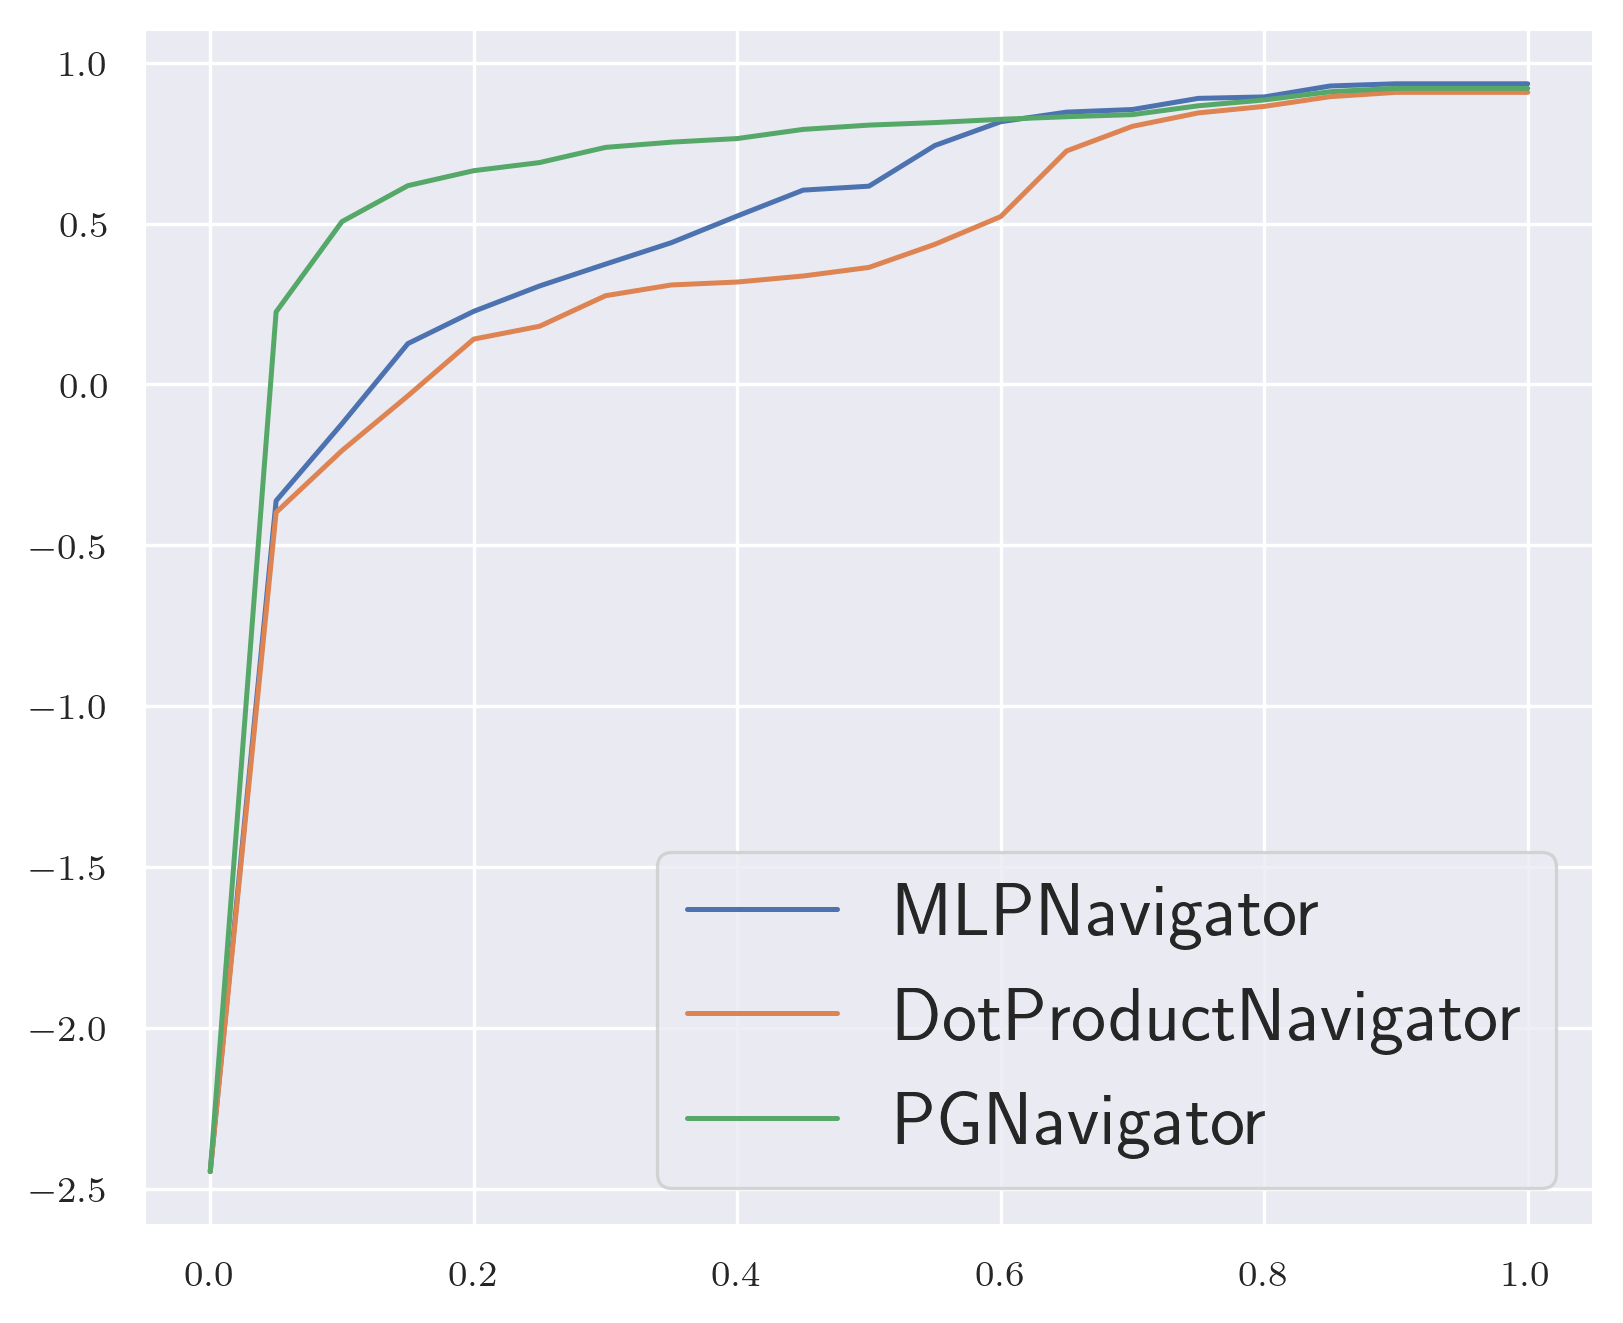

In [135]:

for k, tab in tgn_wikipedia_tabs.items():
    if k in navs:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend()
plt.tight_layout()
plt.savefig("plots/tgn_wikipedia_navs.png")

## Reddit

Best Fid: {'xtg': 0.255969266295433, 'attn': 0.14476382285356518, 'pbone': 0.24414053630828855, 'pg': 0.11693396629393099, 'xtg-d': 0.2646820983290672, 'xtg-og': 0.2654505705088377}
AUFSC: {'xtg': -1.4603407012969258, 'attn': -1.5458064605053519, 'pbone': -0.6292809361521156, 'pg': -2.209208604266495, 'xtg-d': -1.2845651247836651, 'xtg-og': -1.0561136454176157}
attn	 FID: 0.14476382285356518 	 AUC: -1.5458064605053519
pbone	 FID: 0.24414053630828855 	 AUC: -0.6292809361521156
pg	 FID: 0.11693396629393099 	 AUC: -2.209208604266495
xtg-og	 FID: 0.2654505705088377 	 AUC: -1.0561136454176157


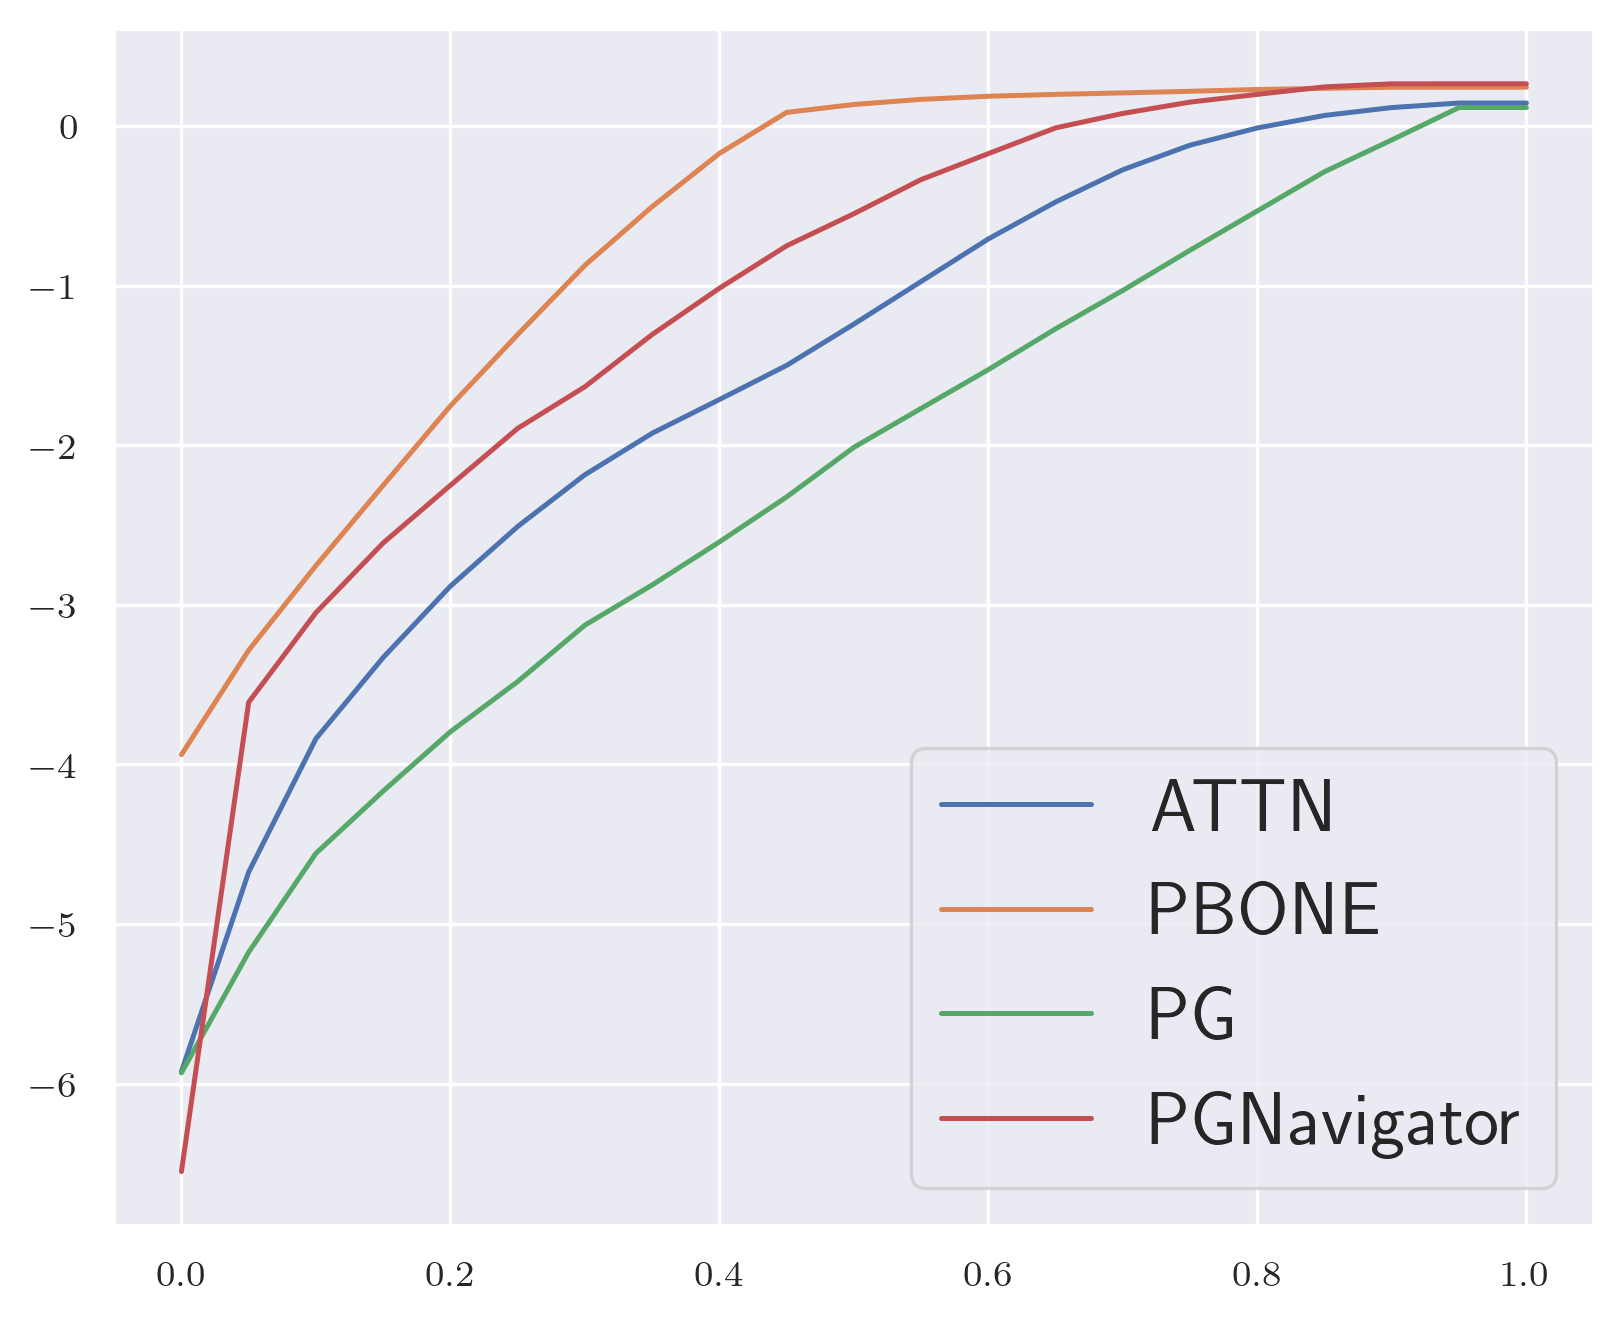

In [136]:
tgn_reddit_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgn_reddit_subgraphx_tg_470920_to_663534_eval_mlp_true_pg_positive_th20.csv",
            "tgn_reddit_attn_explainer_tg_470920_to_665351_eval_th25.csv",
            "tgn_reddit_pbone_explainer_tg_470920_to_665351_eval_th25.csv",
            "tgn_reddit_pg_explainer_tg_470920_to_665351_eval_th25.csv",
            "tgn_reddit_subgraphx_tg_470920_to_663534_eval_dot_true_pg_positive_th20.csv",
            "tgn_reddit_subgraphx_tg_470920_to_663534_eval_pg_true_pg_positive_th20.csv"
        ],
    )
}

tgn_reddit_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean() for k, v in tgn_reddit_files.items()
}

tgn_reddit_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgn_reddit_tabs.items()
}

tgn_reddit_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index) for k, tab in tgn_reddit_tabs.items()
}

print("Best Fid:", tgn_reddit_best_fids)
print("AUFSC:", tgn_reddit_aufsc)

for k, tab in tgn_reddit_tabs.items():
    if k in og_models:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgn_reddit.png")

xtg	 FID: 0.255969266295433 	 AUC: -1.4603407012969258
xtg-d	 FID: 0.2646820983290672 	 AUC: -1.2845651247836651
xtg-og	 FID: 0.2654505705088377 	 AUC: -1.0561136454176157


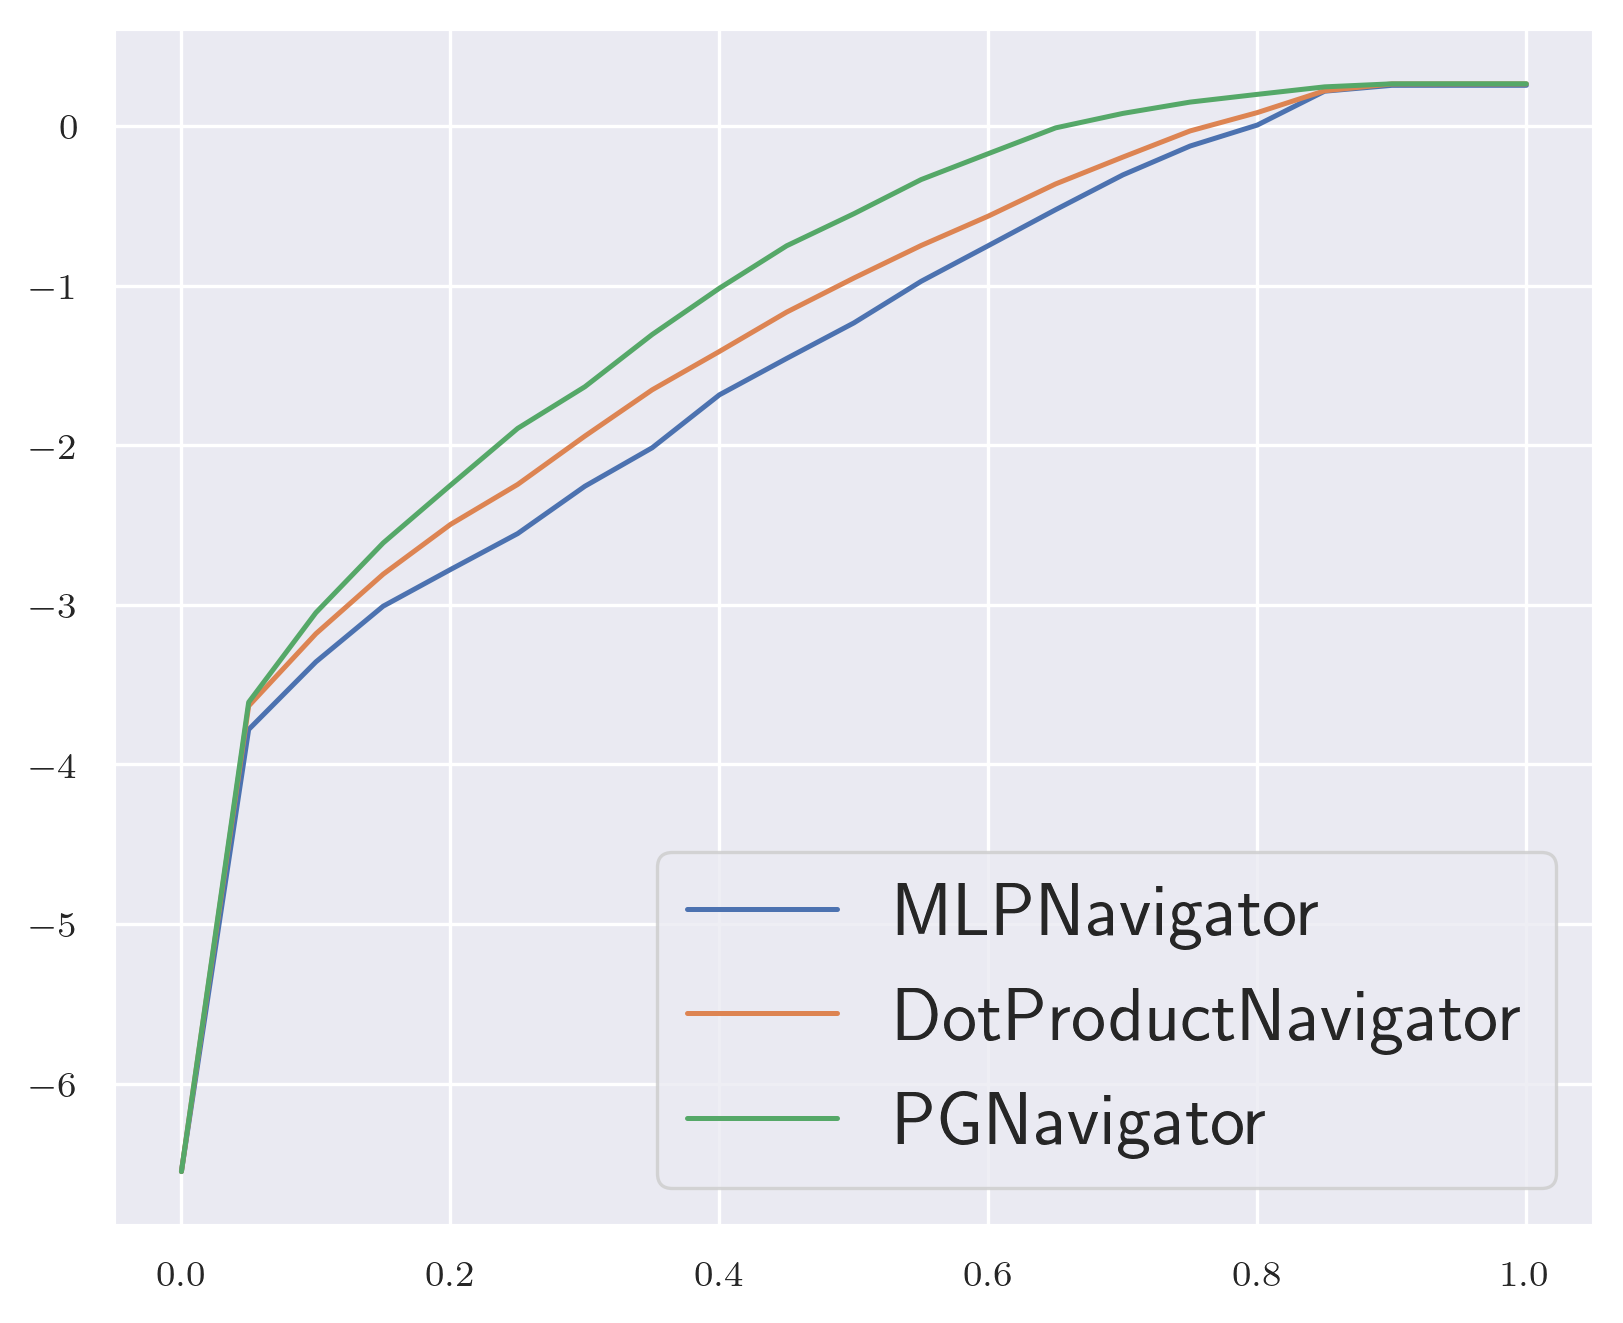

In [137]:
for k, tab in tgn_reddit_tabs.items():
    if k in navs:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend()
plt.tight_layout()
plt.savefig("plots/tgn_reddit_navs.png")

## Simulate V1

Best Fid: {'xtg': 1.9075012358964658, 'attn': 1.502154535293579, 'pbone': 1.814053654909134, 'pg': 1.4355251576900483, 'xtg-d': 1.3005282142583061, 'xtg-og': 1.820665313917048}
AUFSC: {'xtg': 1.493588796754678, 'attn': 0.8892634652346372, 'pbone': 0.8859449886798859, 'pg': 0.09209337216615679, 'xtg-d': 0.39844800935072056, 'xtg-og': 1.4673305029670394}
attn	 FID: 1.502154535293579 	 AUC: 0.8892634652346372
pbone	 FID: 1.814053654909134 	 AUC: 0.8859449886798859
pg	 FID: 1.4355251576900483 	 AUC: 0.09209337216615679
xtg-og	 FID: 1.820665313917048 	 AUC: 1.4673305029670394


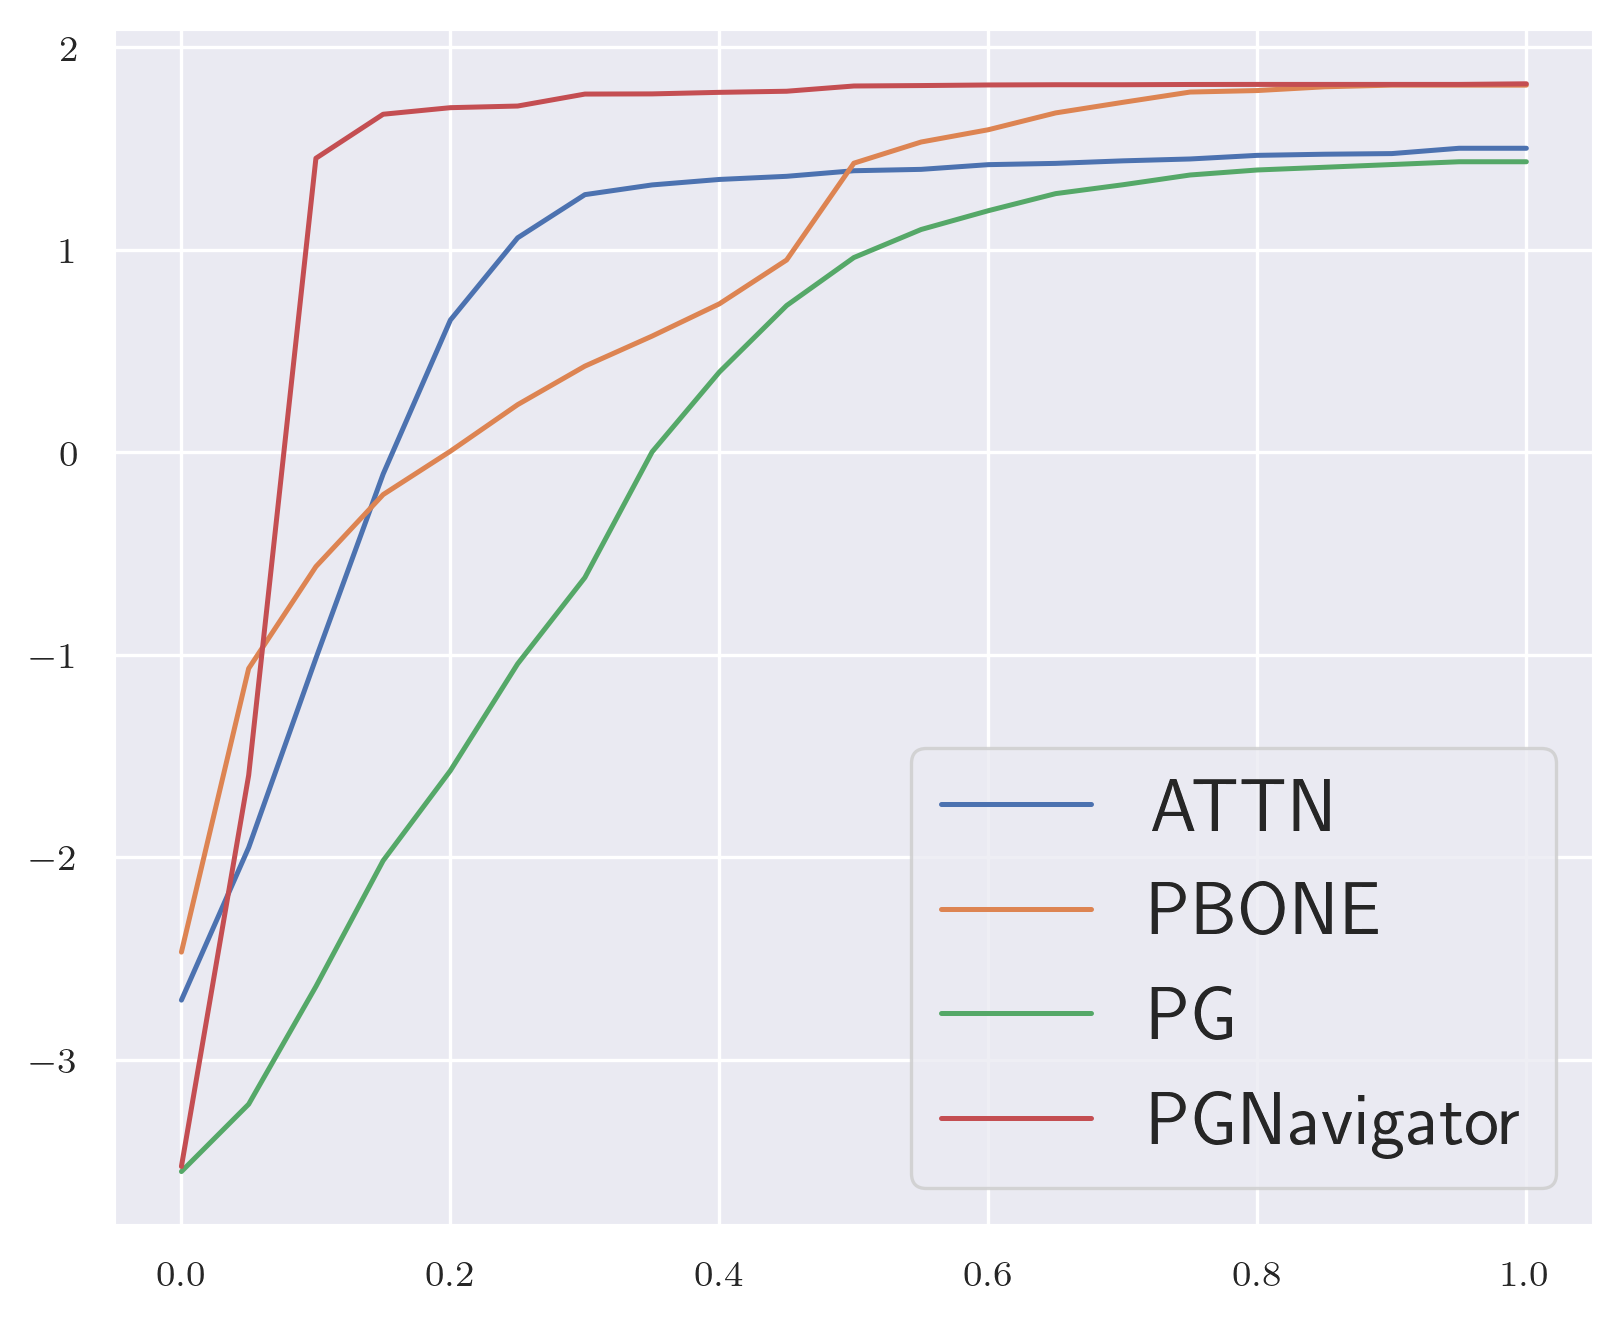

In [138]:
tgn_simulate_v1_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgn_simulate_v1_subgraphx_tg_3_to_15902_eval_mlp_true_pg_positive_th20.csv",
            "tgn_simulate_v1_attn_explainer_tg_3_to_15902_eval_th25.csv",
            "tgn_simulate_v1_pbone_explainer_tg_3_to_15902_eval_th25.csv",
            "tgn_simulate_v1_pg_explainer_tg_3_to_15902_eval_th25.csv",
            "tgn_simulate_v1_subgraphx_tg_3_to_15902_eval_dot_true_pg_positive_th20.csv",
            "tgn_simulate_v1_subgraphx_tg_3_to_15902_eval_pg_true_pg_positive_th20.csv"
        ],
    )
}

tgn_simulate_v1_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean()
    for k, v in tgn_simulate_v1_files.items()
}

tgn_simulate_v1_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgn_simulate_v1_tabs.items()
}

tgn_simulate_v1_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index)
    for k, tab in tgn_simulate_v1_tabs.items()
}
print("Best Fid:", tgn_simulate_v1_best_fids)
print("AUFSC:", tgn_simulate_v1_aufsc)

for k, tab in tgn_simulate_v1_tabs.items():
    if k in og_models:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgn_simulate_v1.png")

xtg	 FID: 1.9075012358964658 	 AUC: 1.493588796754678
xtg-d	 FID: 1.3005282142583061 	 AUC: 0.39844800935072056
xtg-og	 FID: 1.820665313917048 	 AUC: 1.4673305029670394


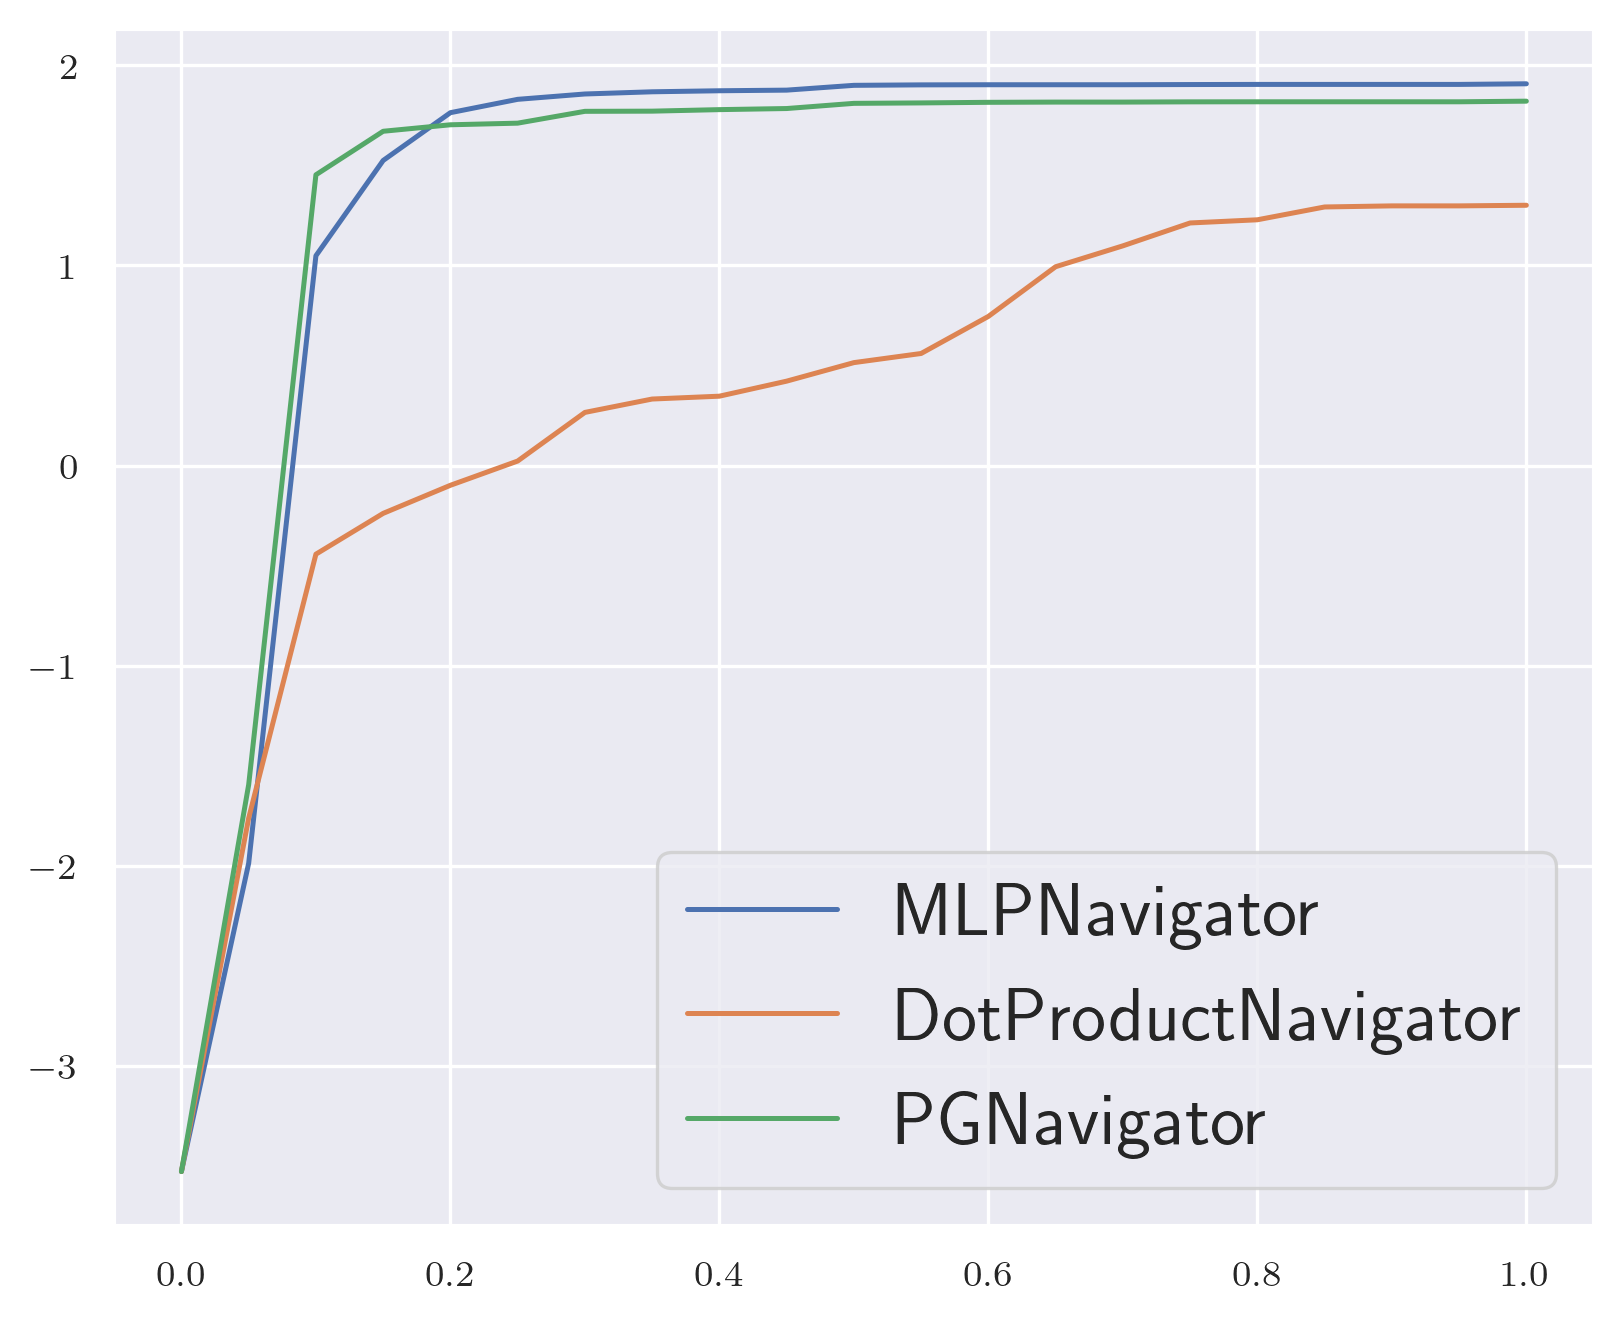

In [139]:

for k, tab in tgn_simulate_v1_tabs.items():
    if k in navs:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend()
plt.tight_layout()
plt.savefig("plots/tgn_simulate_v1_navs.png")

## Simulate V2

Best Fid: {'xtg': 2.4938756166135563, 'attn': 1.659767407119274, 'pbone': 2.81320695155859, 'pg': 1.1117126109600066, 'xtg-d': 2.945418882311559, 'xtg-og': 2.825217526040825}
AUFSC: {'xtg': 0.8196067307436581, 'attn': -0.6773320452421904, 'pbone': -0.29036131019219763, 'pg': -1.903435571766645, 'xtg-d': 0.6539926552158943, 'xtg-og': 1.7695163844043715}
attn	 FID: 1.659767407119274 	 AUC: -0.6773320452421904
pbone	 FID: 2.81320695155859 	 AUC: -0.29036131019219763
pg	 FID: 1.1117126109600066 	 AUC: -1.903435571766645
xtg-og	 FID: 2.825217526040825 	 AUC: 1.7695163844043715


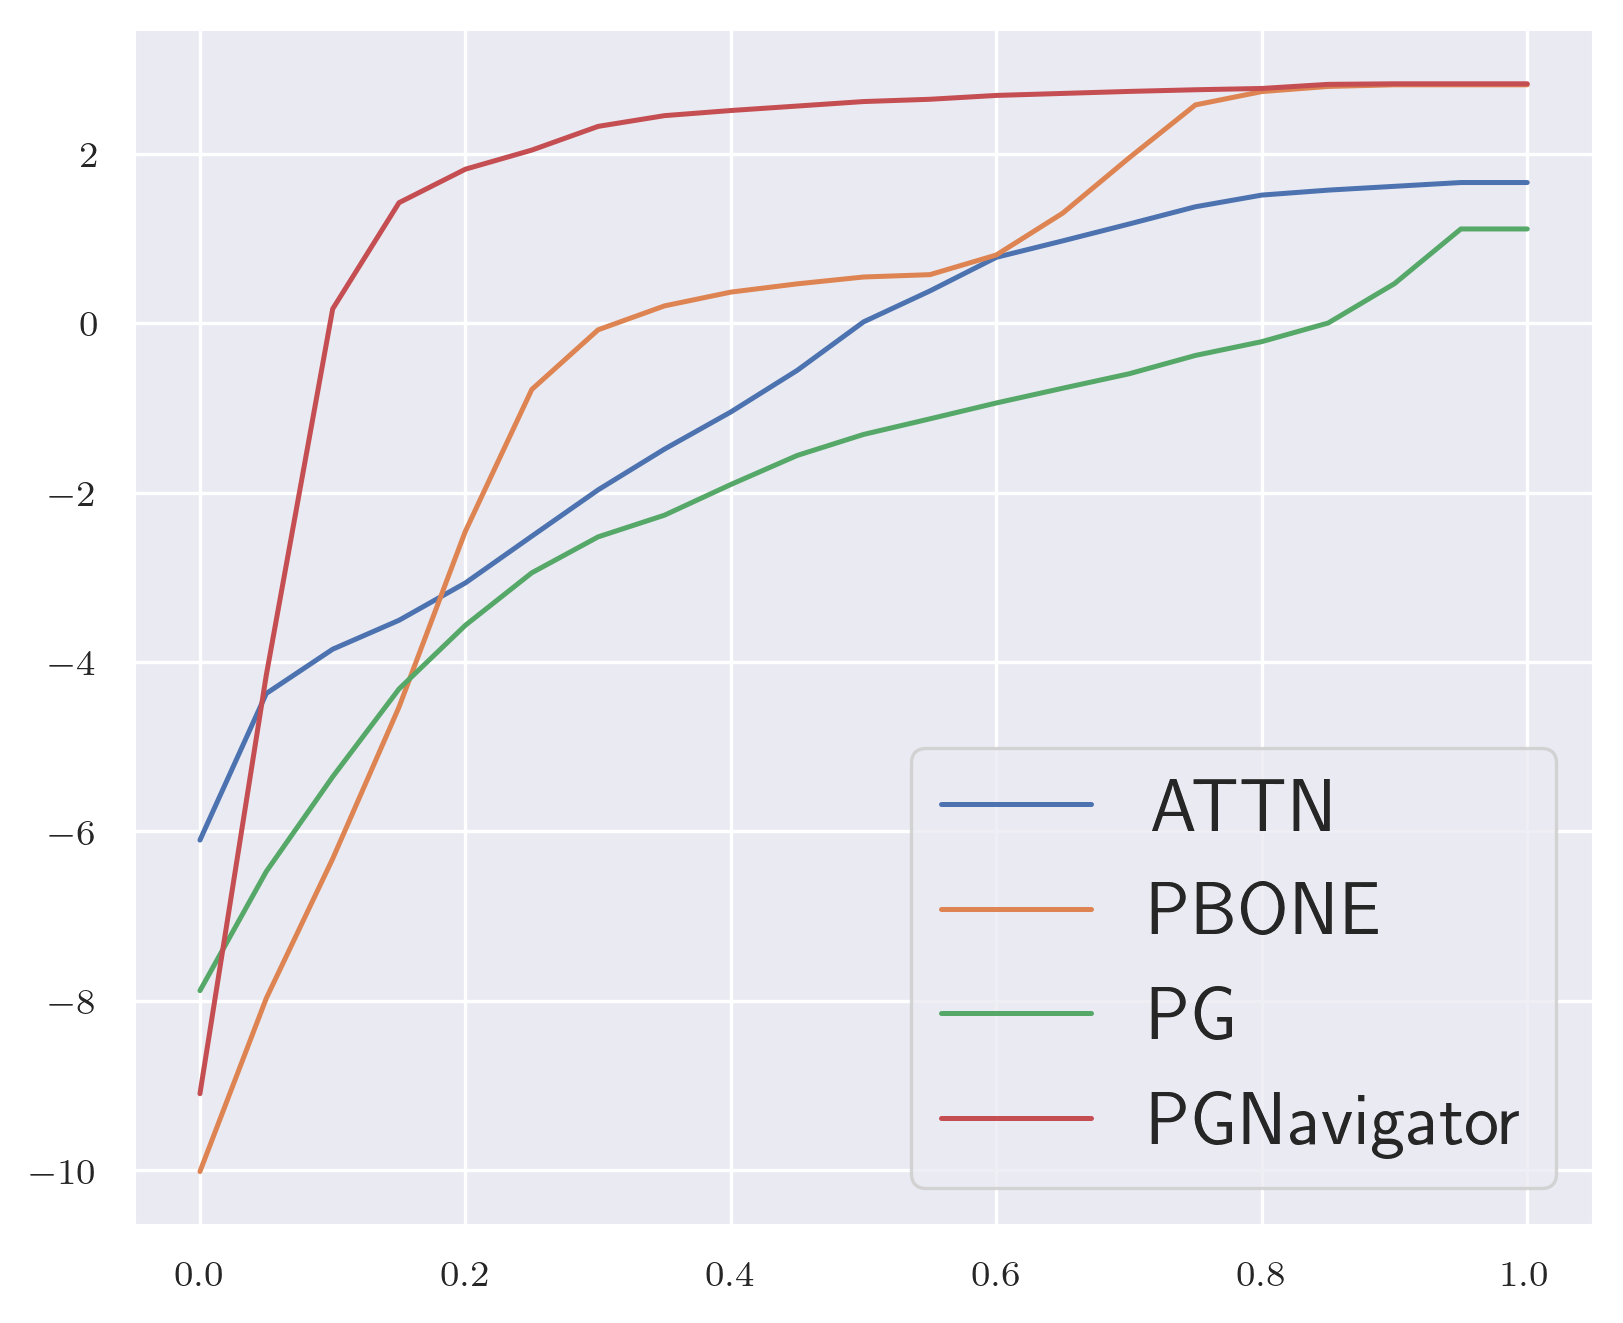

In [140]:
tgn_simulate_v2_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgn_simulate_v2_subgraphx_tg_3_to_21752_eval_mlp_true_pg_positive_th20.csv",
            "tgn_simulate_v2_attn_explainer_tg_3_to_21752_eval_th25.csv",
            "tgn_simulate_v2_pbone_explainer_tg_3_to_21752_eval_th25.csv",
            "tgn_simulate_v2_pg_explainer_tg_3_to_21752_eval_th25.csv",
            "tgn_simulate_v2_subgraphx_tg_3_to_21752_eval_dot_true_pg_positive_th20.csv",
            "tgn_simulate_v2_subgraphx_tg_3_to_21752_eval_pg_true_pg_positive_th20.csv"
        ],
    )
}
tgn_simulate_v2_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean()
    for k, v in tgn_simulate_v2_files.items()
}
tgn_simulate_v2_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgn_simulate_v2_tabs.items()
}
tgn_simulate_v2_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index)
    for k, tab in tgn_simulate_v2_tabs.items()
}
print("Best Fid:", tgn_simulate_v2_best_fids)
print("AUFSC:", tgn_simulate_v2_aufsc)

for k, tab in tgn_simulate_v2_tabs.items():
    if k in og_models:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgn_simulate_v2.png")

xtg	 FID: 2.4938756166135563 	 AUC: 0.8196067307436581
xtg-d	 FID: 2.945418882311559 	 AUC: 0.6539926552158943
xtg-og	 FID: 2.825217526040825 	 AUC: 1.7695163844043715


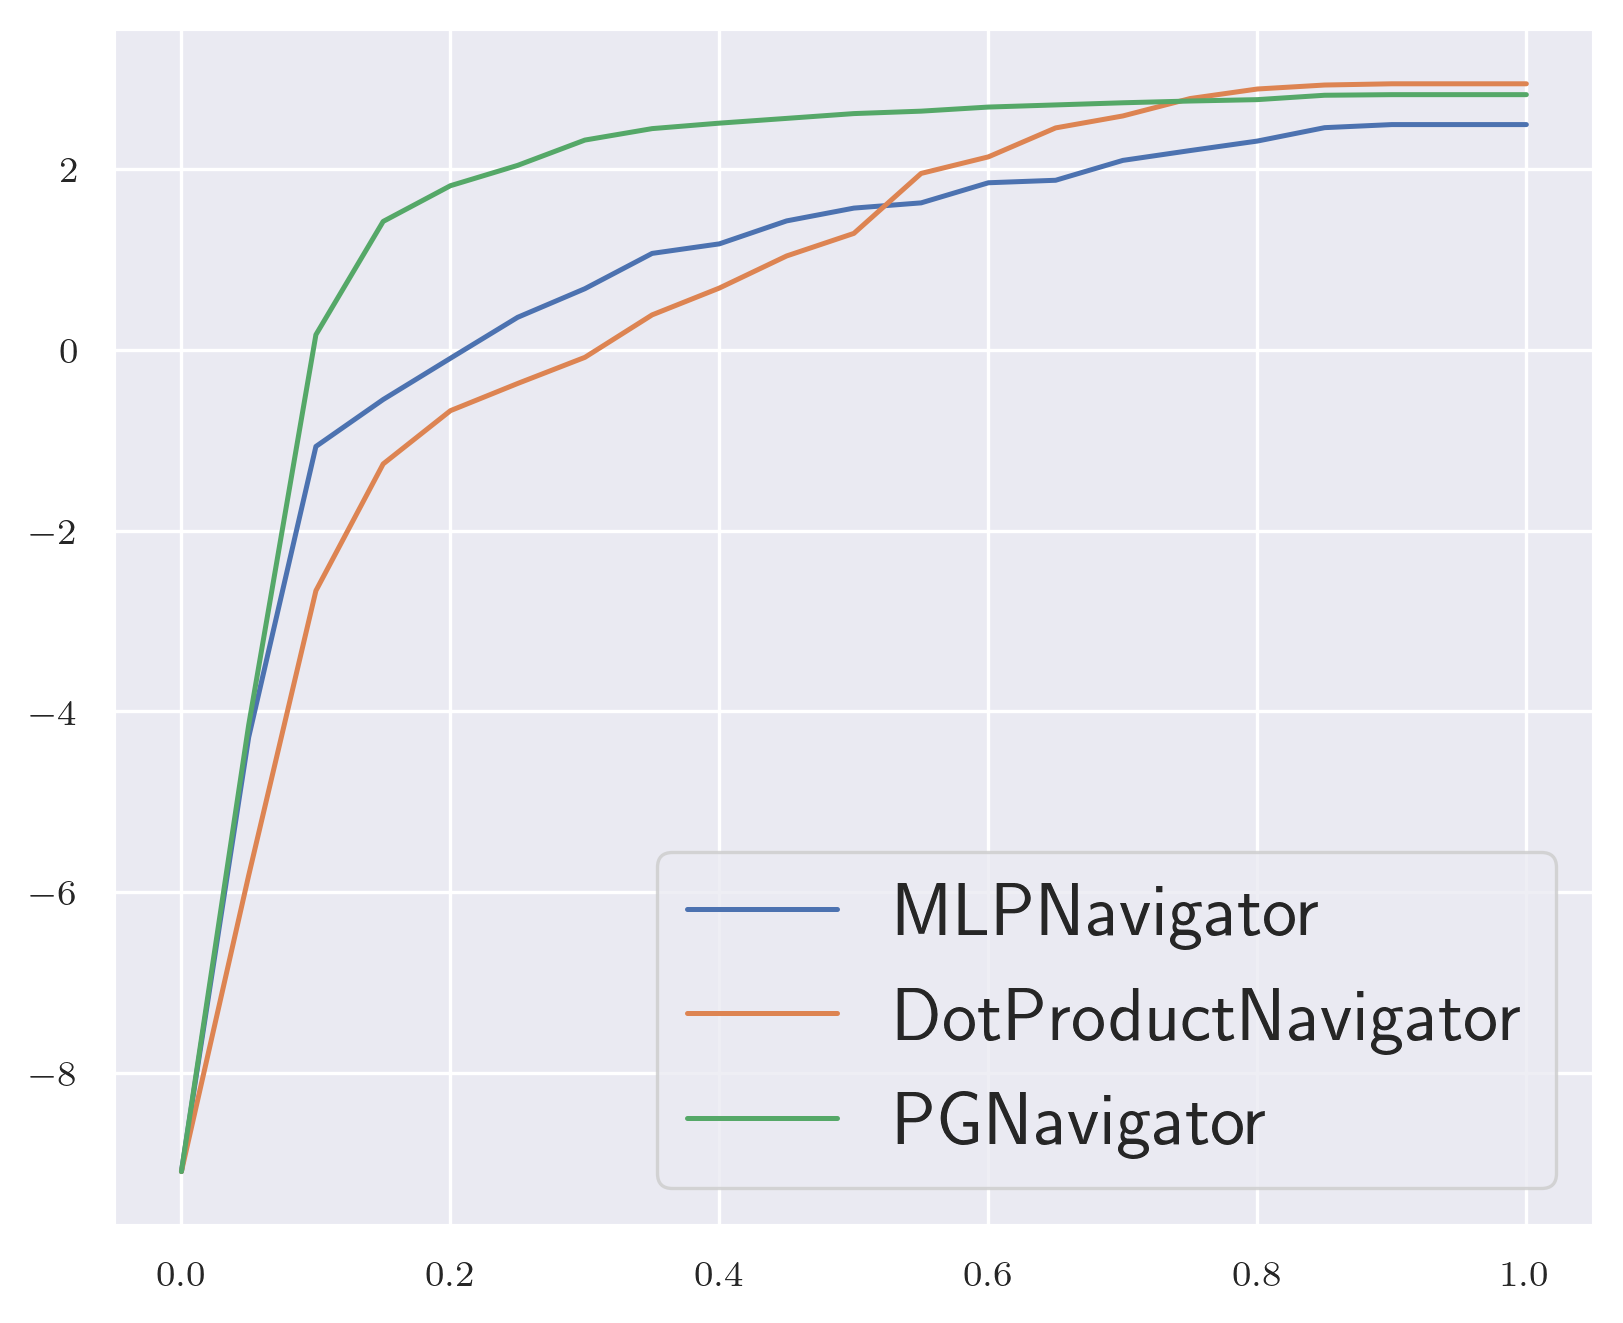

In [141]:

for k, tab in tgn_simulate_v2_tabs.items():
    if k in navs:
        print(
            f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend()
plt.tight_layout()
plt.savefig("plots/tgn_simulate_v2_navs.png")

# Assemble everything
Here we assemble everything into a single dataframe and save it to a csv file.

In [142]:
# model = "tgat"
model = "tgn"

locs = locals()
d1 = {
    f"{model}_{dataset}_best_fids": locs[f"{model}_{dataset}_best_fids"]
    for dataset in dataset_to_index
}
d2 = {
    f"{model}_{dataset}_aufsc": locs[f"{model}_{dataset}_aufsc"]
    for dataset in dataset_to_index
}

# zip the two in order to be side by side, my brain is fried i got no better suggestion
d = {}
for (k, v), (k2, v2) in zip(d1.items(), d2.items()):
    d[k] = v
    d[k2] = v2

df_tgat = pd.DataFrame.from_dict(d, orient="columns")

index = pd.MultiIndex(
    levels=[
        ["Wikipedia", "Reddit", "Simulate V1", "Simulate V2"],
        ["Best FID", "AUFSC"],
    ],
    codes=[
        [0, 0, 1, 1, 2, 2, 3, 3],
        [0, 1, 0, 1, 0, 1, 0, 1],
    ],
    names=["", ""],
)

df_tgat.columns = index
df_tgat.index = ["MLPNavigator", "ATTN", "PBONE", "PG", "DotProductNavigator", "PGNavigator"]
df_tgat = df_tgat.T[
    ["ATTN", "PBONE", "PG", "PGNavigator", "MLPNavigator", "DotProductNavigator"]
].T  # reorder rows to correspond to their order in OG paper
import matplotlib.colors as mcolors


def color_gradient(val, cmap="coolwarm", vmin=None, vmax=None):
    """
    Takes a scalar and returns a string with
    the css property `'color: ...'` for a color
    based on the value relative to the vmin and vmax.
    """
    cmap = plt.get_cmap(cmap)
    norm = mcolors.AsinhNorm(vmin=vmin, vmax=vmax)
    color = mcolors.rgb2hex(cmap(norm(val)))
    return f" color: {color}({val})"


df_latex = df_tgat
df_latex = (
    df_latex.style.highlight_max(props="font-weight:bold")
    .apply(lambda x: np.where(x == x.nlargest(2)[-1], "font-style:oblique;", None))
    .format(precision=3)
    .to_latex(
        convert_css=True,
        multicol_align="c",
        hrules=True,
        column_format="lrrrrrrrr",
    )
    .replace("\\slshape", "\\underline")
    .replace(
        "\\end{tabular}",
        f"\\end{{tabular}}\n\\caption{{\\label{{tab:{model}_results}}$\\dagger$ Explainer results for {model.upper()} model.}}",
    )
)

df_diff = (df_tgat - locs[f"df_{model}_theirs"]) / locs[f"df_{model}_theirs"] * 100
df_diff = (
    df_diff.style.format(precision=3)
    .to_latex(
        convert_css=True,
        multicol_align="c",
        hrules=True,
        position_float="centering",
        column_format="lrrrrrrrr",
    )
    .replace(
        "\\end{tabular}",
        f"\\end{{tabular}}\n\\caption{{\\label{{tab:{model}_results_diff}}Relative difference in results for {model.upper()} model with respect to the original paper (in \\%).}}",
    )
)
with open(f"{model}_results_tab.tex", "w") as f:
    f.write(df_latex)

with open(f"{model}_results_diff_tab.tex", "w") as f:
    f.write(df_diff)

with open(f"{model}_results_og_tab.tex", "w") as f:
    f.write(
        locs[f"df_{model}_theirs"]
        .style.format(precision=3)
        .to_latex(
            multicol_align="c",
            hrules=True,
            clines="skip-last;data",
            position_float="centering",
            column_format="lcccccccc",
        )
        .replace(
            "\\end{tabular}",
            f"\\end{{tabular}}\n\\caption{{\\label{{tab:{model}_results_og}}Results for {model.upper()} model from the original paper.}}",
        )
    )

# set display precision
print(df_latex)

\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{2}{c}{Wikipedia} & \multicolumn{2}{c}{Reddit} & \multicolumn{2}{c}{Simulate V1} & \multicolumn{2}{c}{Simulate V2} \\
 & Best FID & AUFSC & Best FID & AUFSC & Best FID & AUFSC & Best FID & AUFSC \\
\midrule
ATTN & 1.502 & 0.889 & 1.660 & -0.677 & 0.515 & 0.313 & 0.145 & -1.546 \\
PBONE & 1.814 & 0.886 & 2.813 & -0.290 & 0.648 & 0.393 & 0.244 & \bfseries -0.629 \\
PG & 1.436 & 0.092 & 1.112 & -1.903 & 0.460 & -0.367 & 0.117 & -2.209 \\
PGNavigator & \underline 1.821 & \underline 1.467 & \underline 2.825 & \bfseries 1.770 & \underline 0.921 & \bfseries 0.680 & \bfseries 0.265 & \underline -1.056 \\
MLPNavigator & \bfseries 1.908 & \bfseries 1.494 & 2.494 & \underline 0.820 & \bfseries 0.935 & \underline 0.491 & 0.256 & -1.460 \\
DotProductNavigator & 1.301 & 0.398 & \bfseries 2.945 & 0.654 & 0.908 & 0.371 & \underline 0.265 & -1.285 \\
\bottomrule
\end{tabular}
\caption{\label{tab:tgn_results}$\dagger$ Explainer results for TGN model.}



/var/folders/1x/7k25rxt159j8lx18by4r5yhm0000gn/T/ipykernel_9567/4009986347.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .apply(lambda x: np.where(x == x.nlargest(2)[-1], "font-style:oblique;", None))
/var/folders/1x/7k25rxt159j8lx18by4r5yhm0000gn/T/ipykernel_9567/4009986347.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .apply(lambda x: np.where(x == x.nlargest(2)[-1], "font-style:oblique;", None))
/var/folders/1x/7k25rxt159j8lx18by4r5yhm0000gn/T/ipykernel_9567/4009986347.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

# Decision Explanation
## SimulateV1

Navigator: pg_true


Navigator: mlp_true
Navigator: dot_true


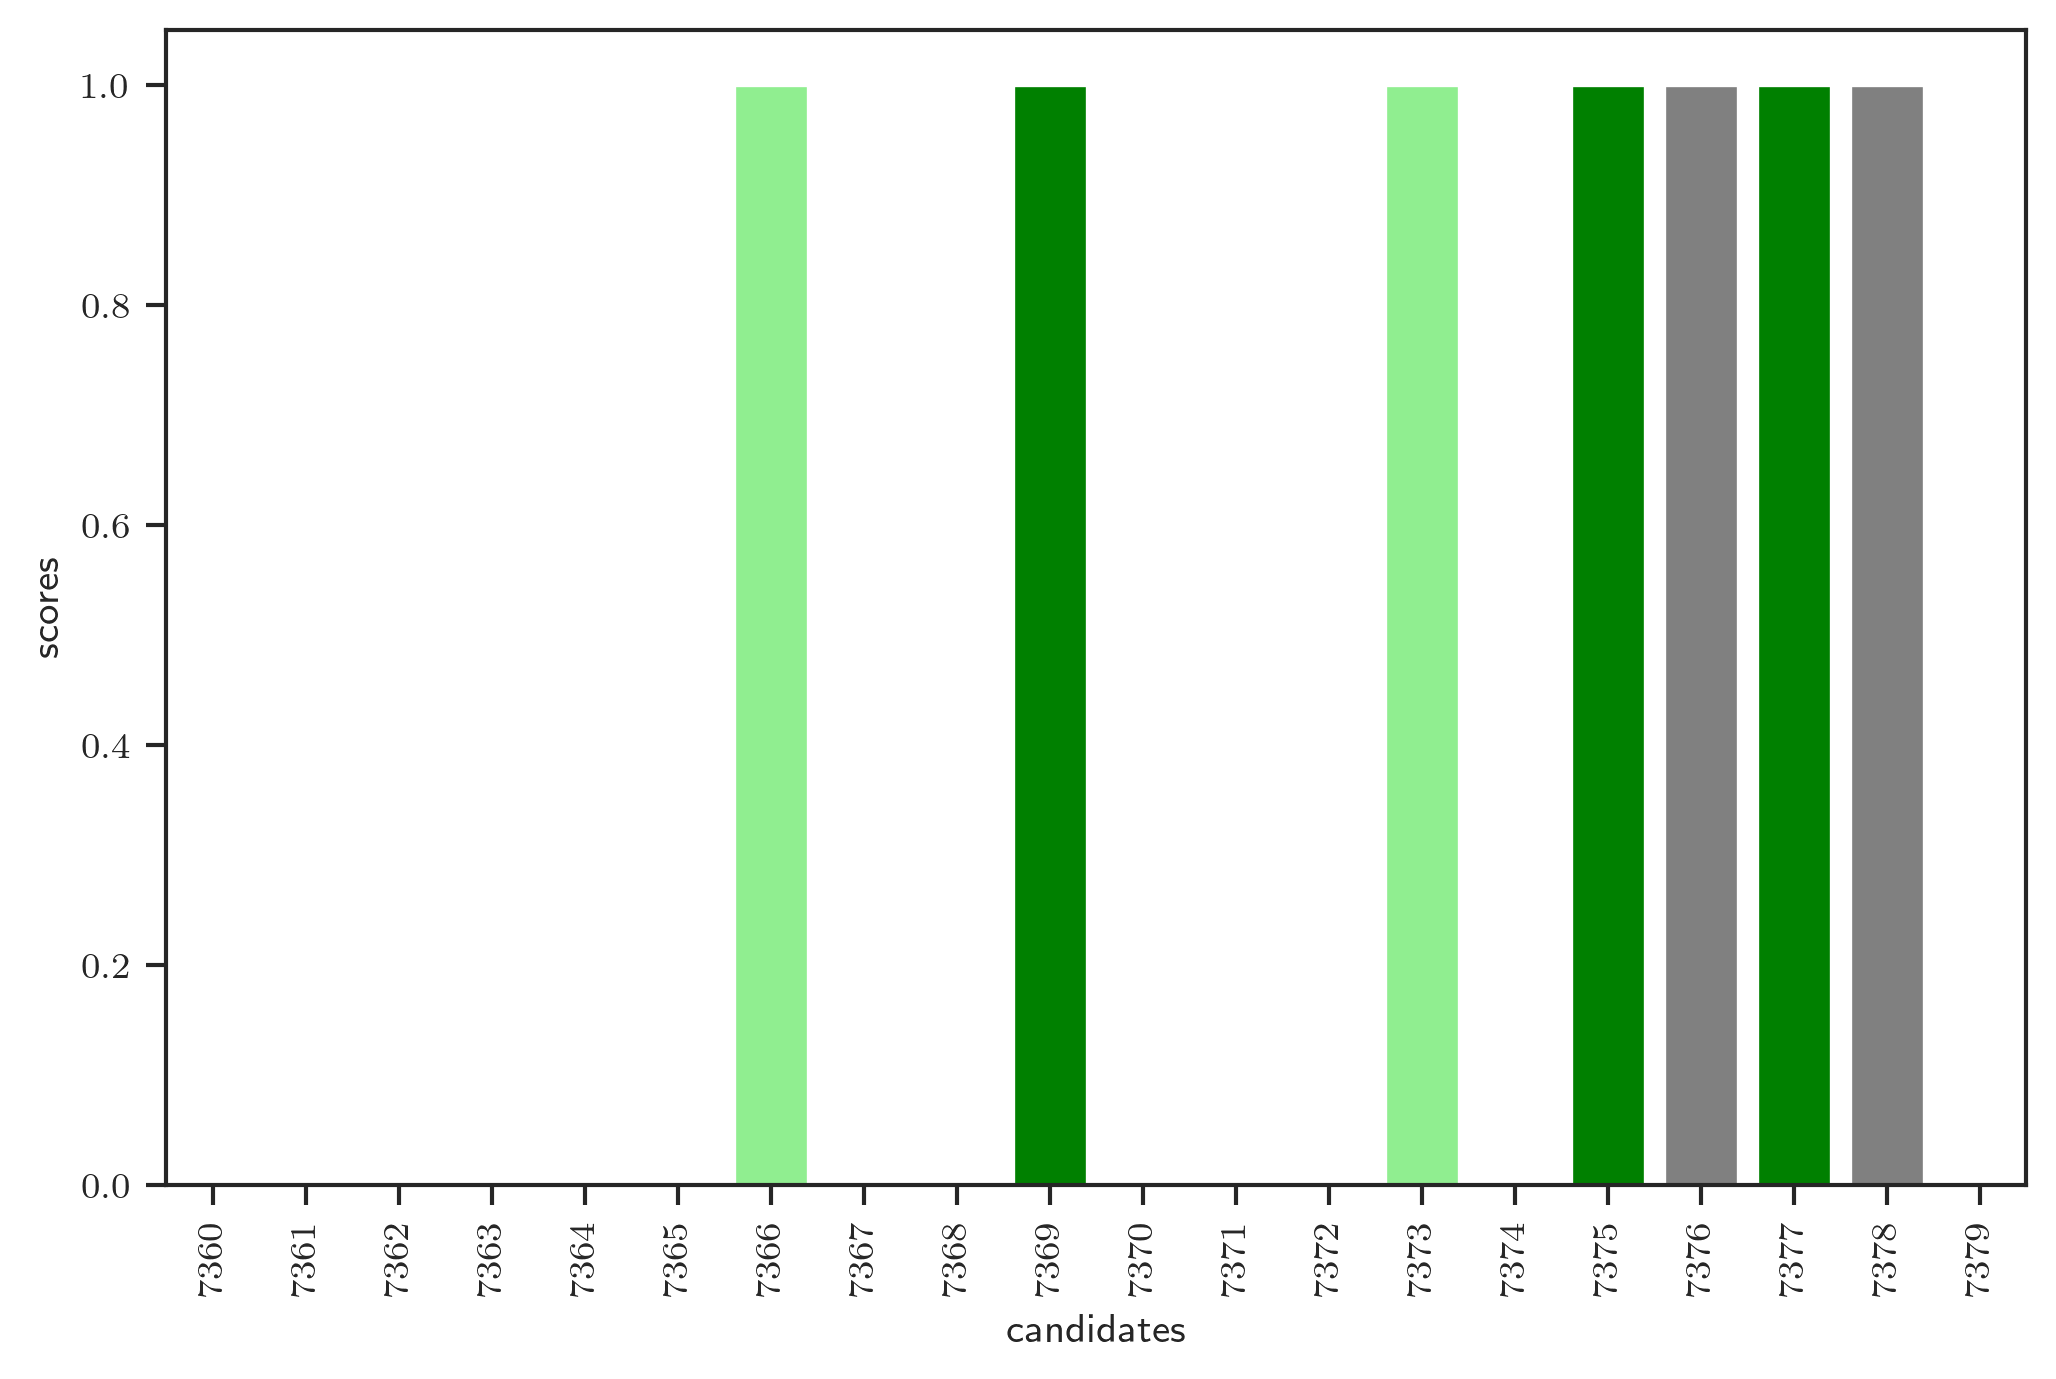

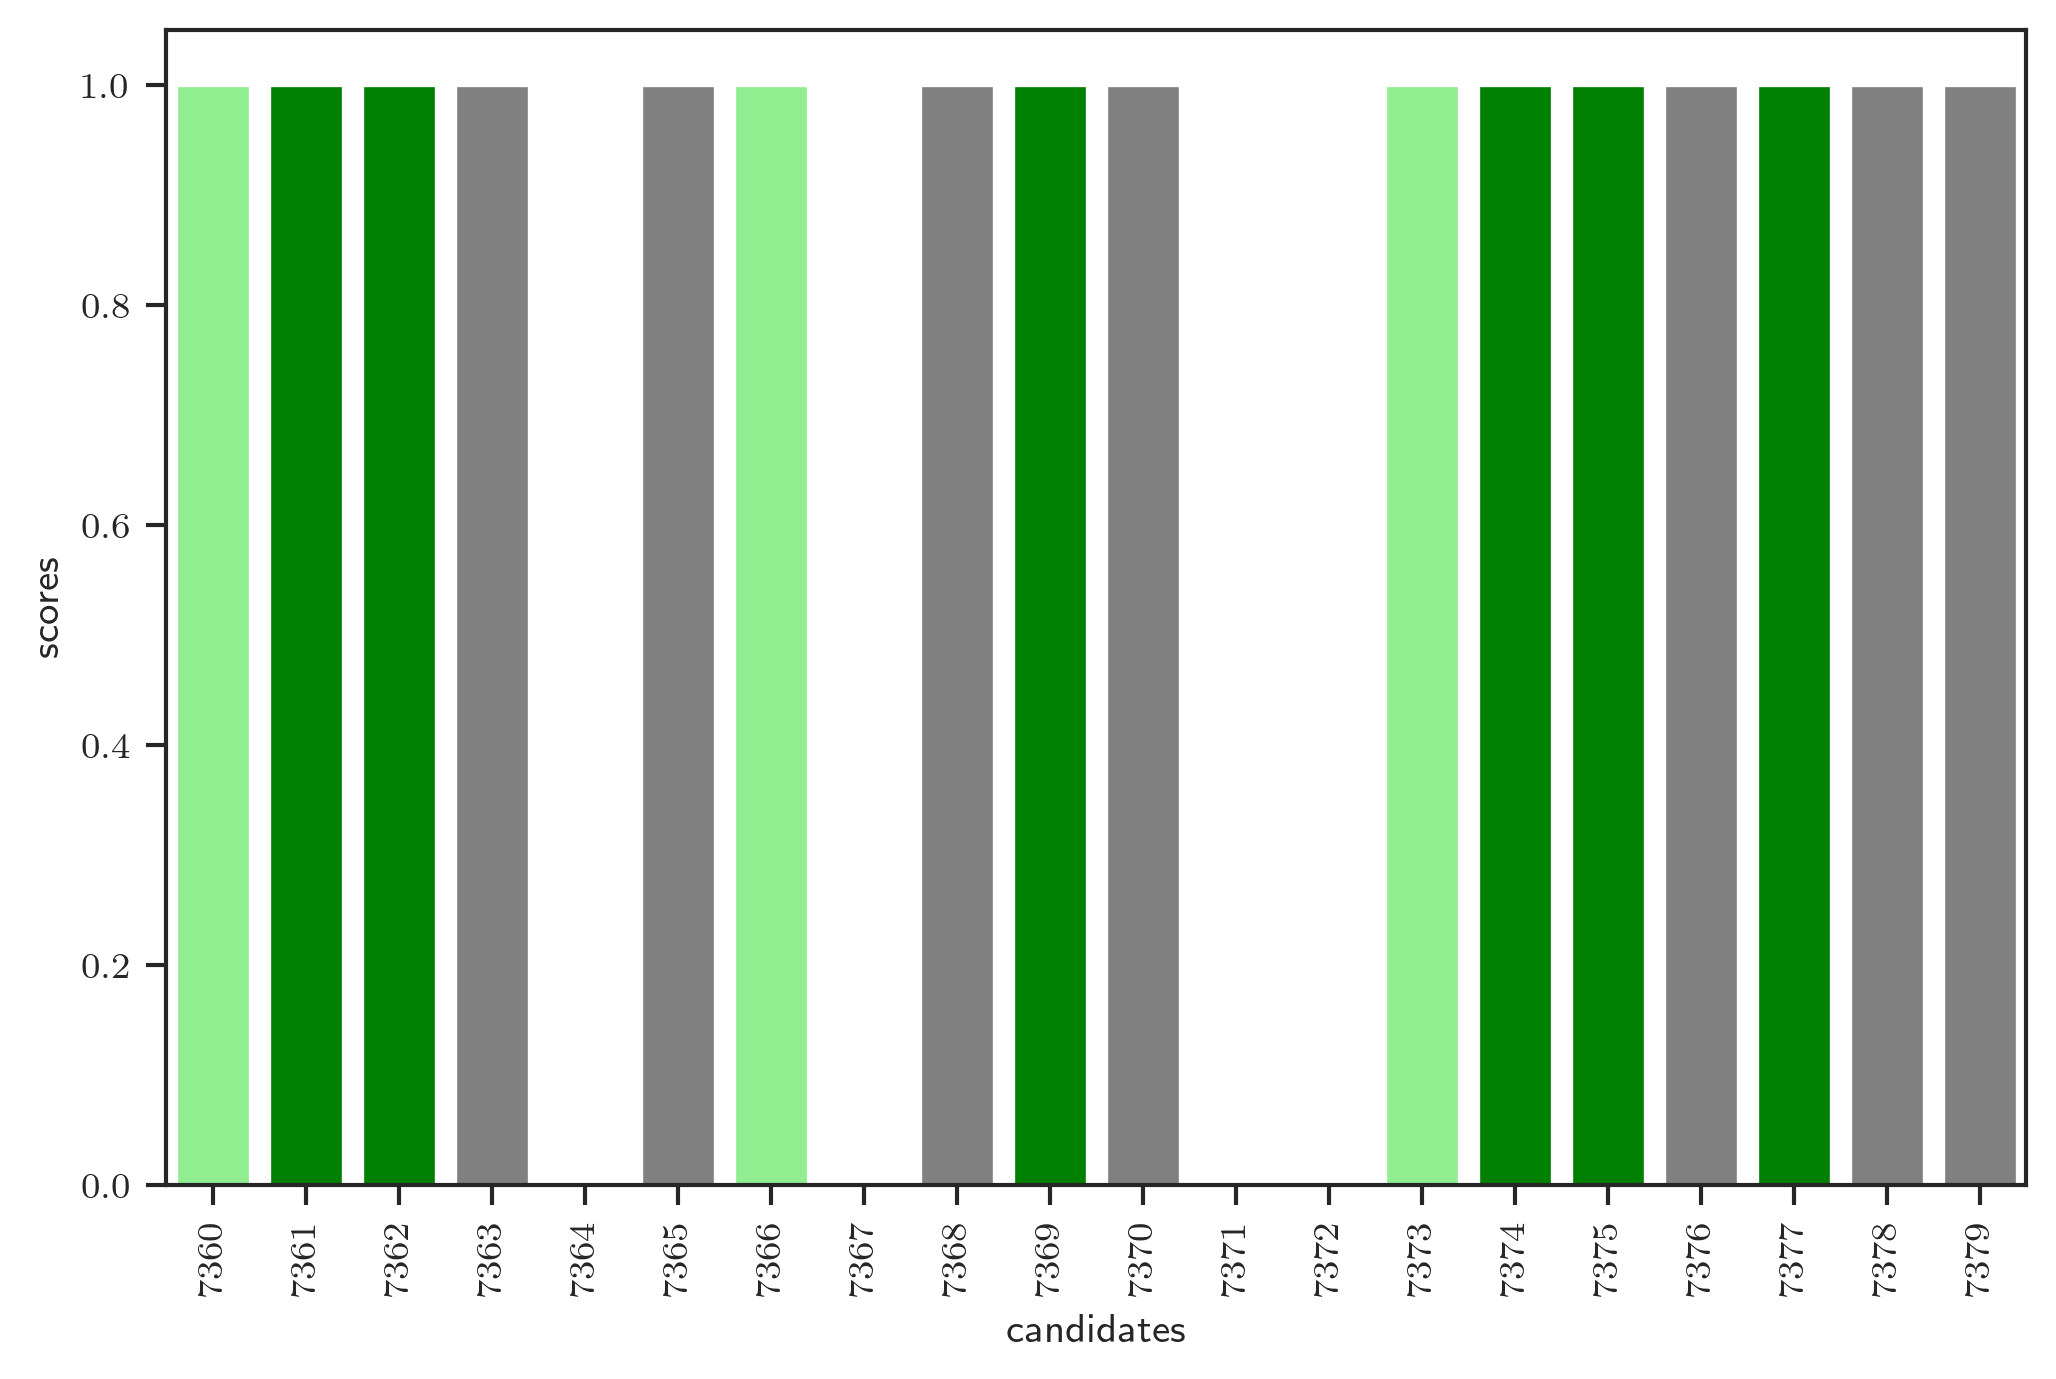

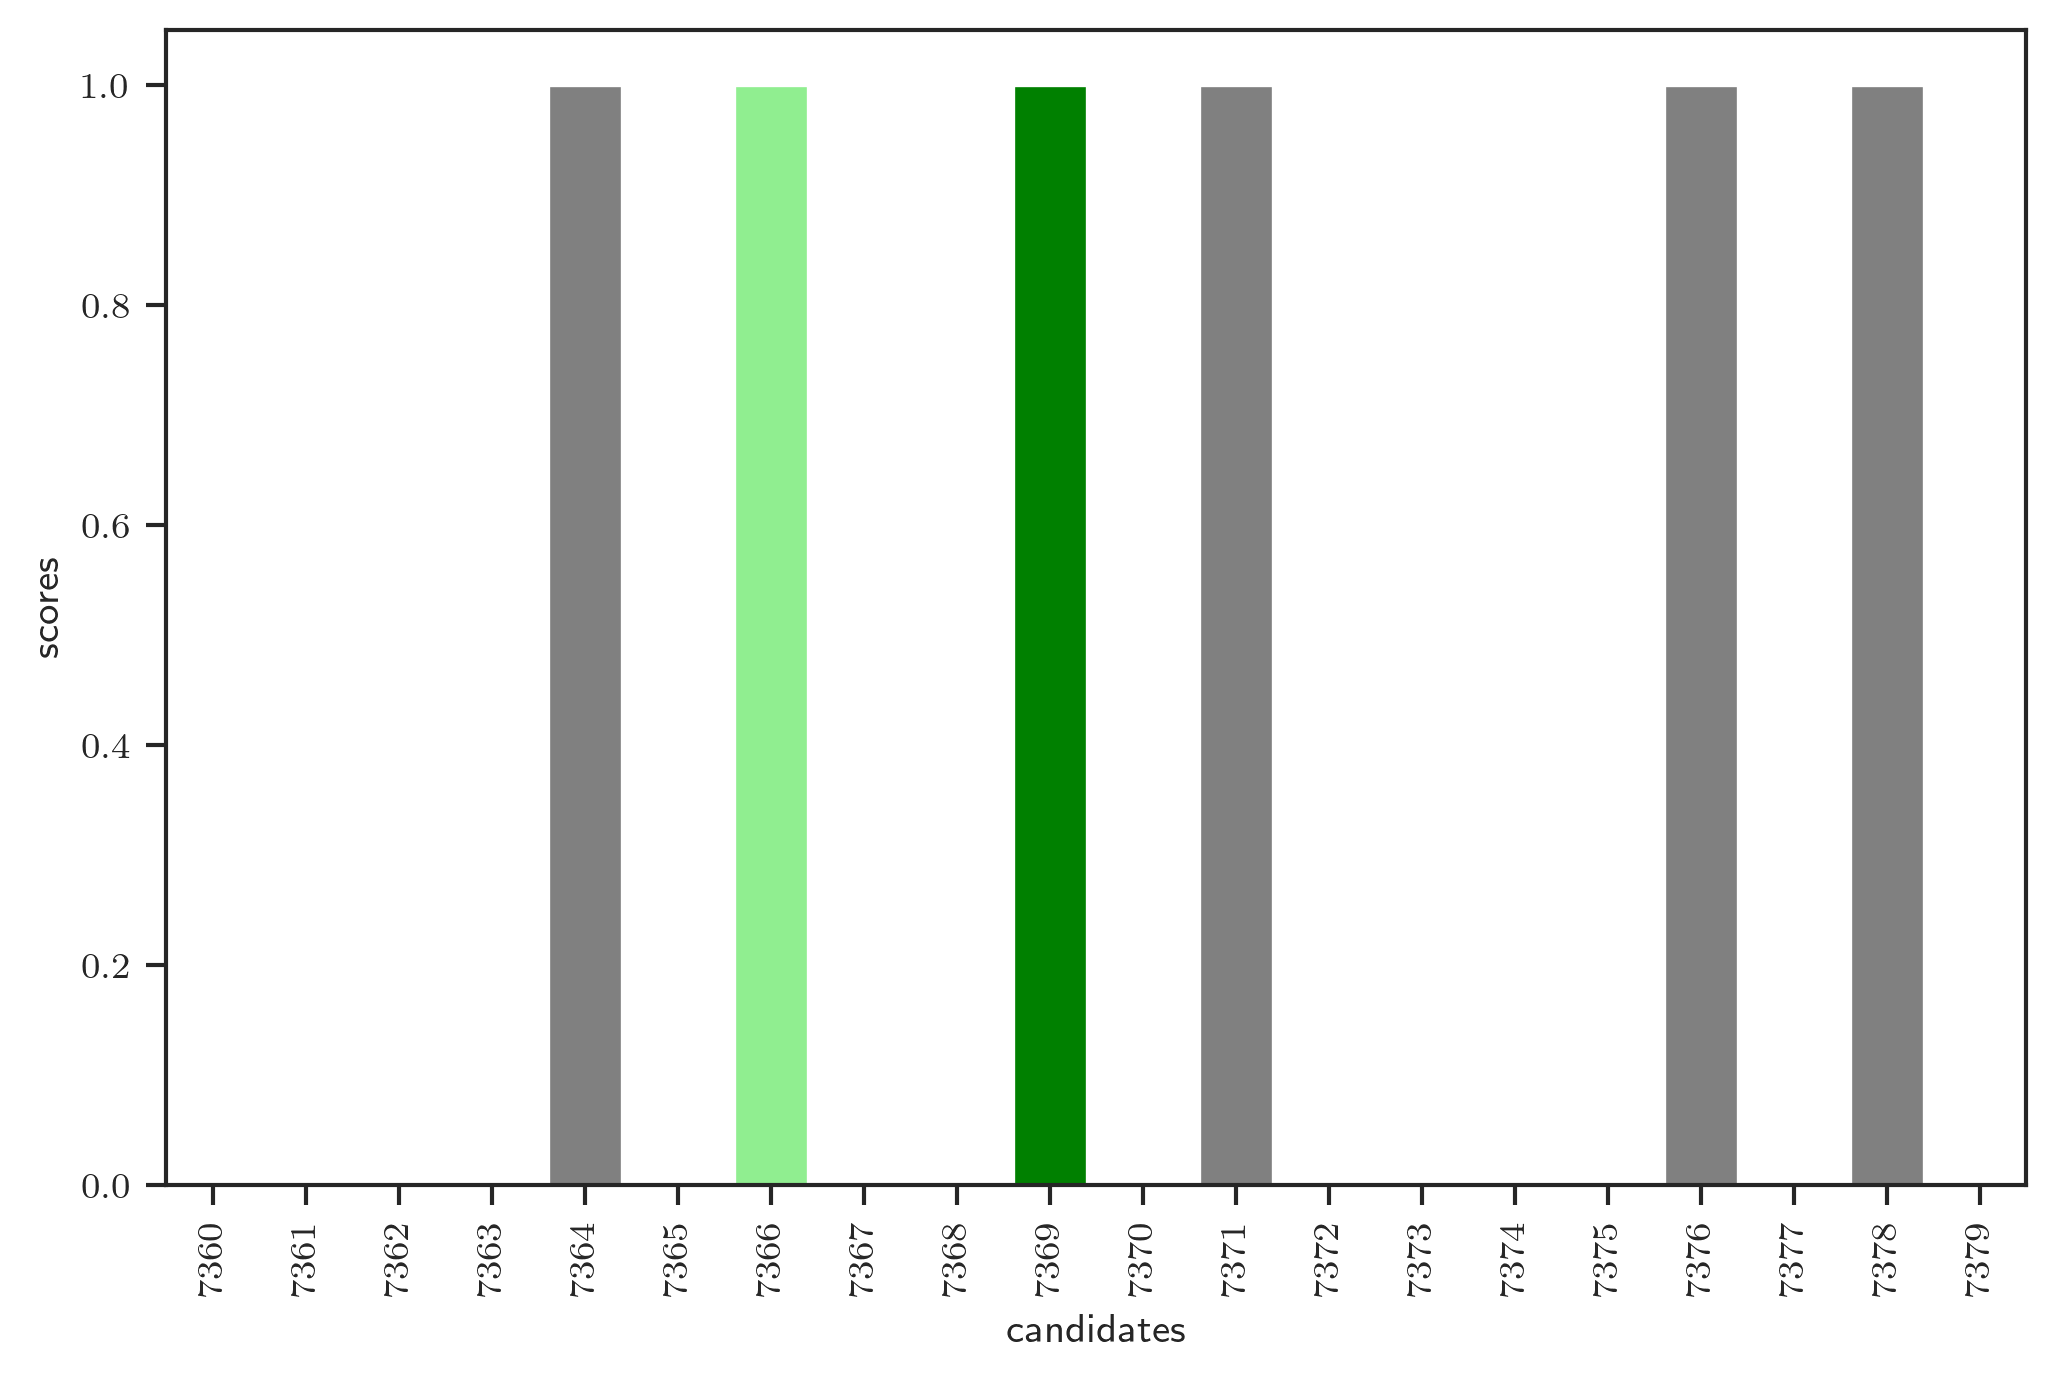

In [143]:
model = "tgat"
threshold = 20
relevancy = [0]*abs(threshold-20)+[1,2, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0]
def get_color(c):
    match c:
        case 0:
            return "grey"
        case 1:
            return "lightgreen"
        case 2:
            return "green"
        case -1:
            return "lightcoral" #dont ask
        case -2:
            return "indianred"
        case _:
            return "white"
colors = [get_color(c) for c in relevancy]
xaxis = range(7380 - threshold, 7380)

for navigator in ["pg_true", "mlp_true", "dot_true"]:
    print("Navigator:", navigator)
    mcts_node_info = next(mcts_path.glob(f"{model}*simulate_v1_7380*{navigator}*{threshold}*"), None)
    if mcts_node_info is None:
        print("No mcts node info found")
        continue
    # mcts_node_info
    node_info = torch.load(mcts_node_info)
    node_info = node_info["saved_MCTSInfo_list"]  # there is only one key in the dict

    best_expansion = max(node_info, key=lambda x: x["P"])

    plt.figure(figsize=(8, 5))
    plt.tight_layout()
    sns.set_style("ticks")
    plt.bar(
        xaxis, [1 if x in best_expansion["coalition"] else 0 for x in xaxis], color=colors
    )

    plt.xlim(7380 - threshold-0.5, 7379+0.5)
    plt.xlabel('candidates')
    plt.ylabel('scores')
    plt.xticks(xaxis, rotation=90)
    plt.savefig(f"plots/simulated_1_7380_{model}_mcts_{navigator}_th{threshold}.png", bbox_inches='tight')
# Rotate the ticks 45 degrees

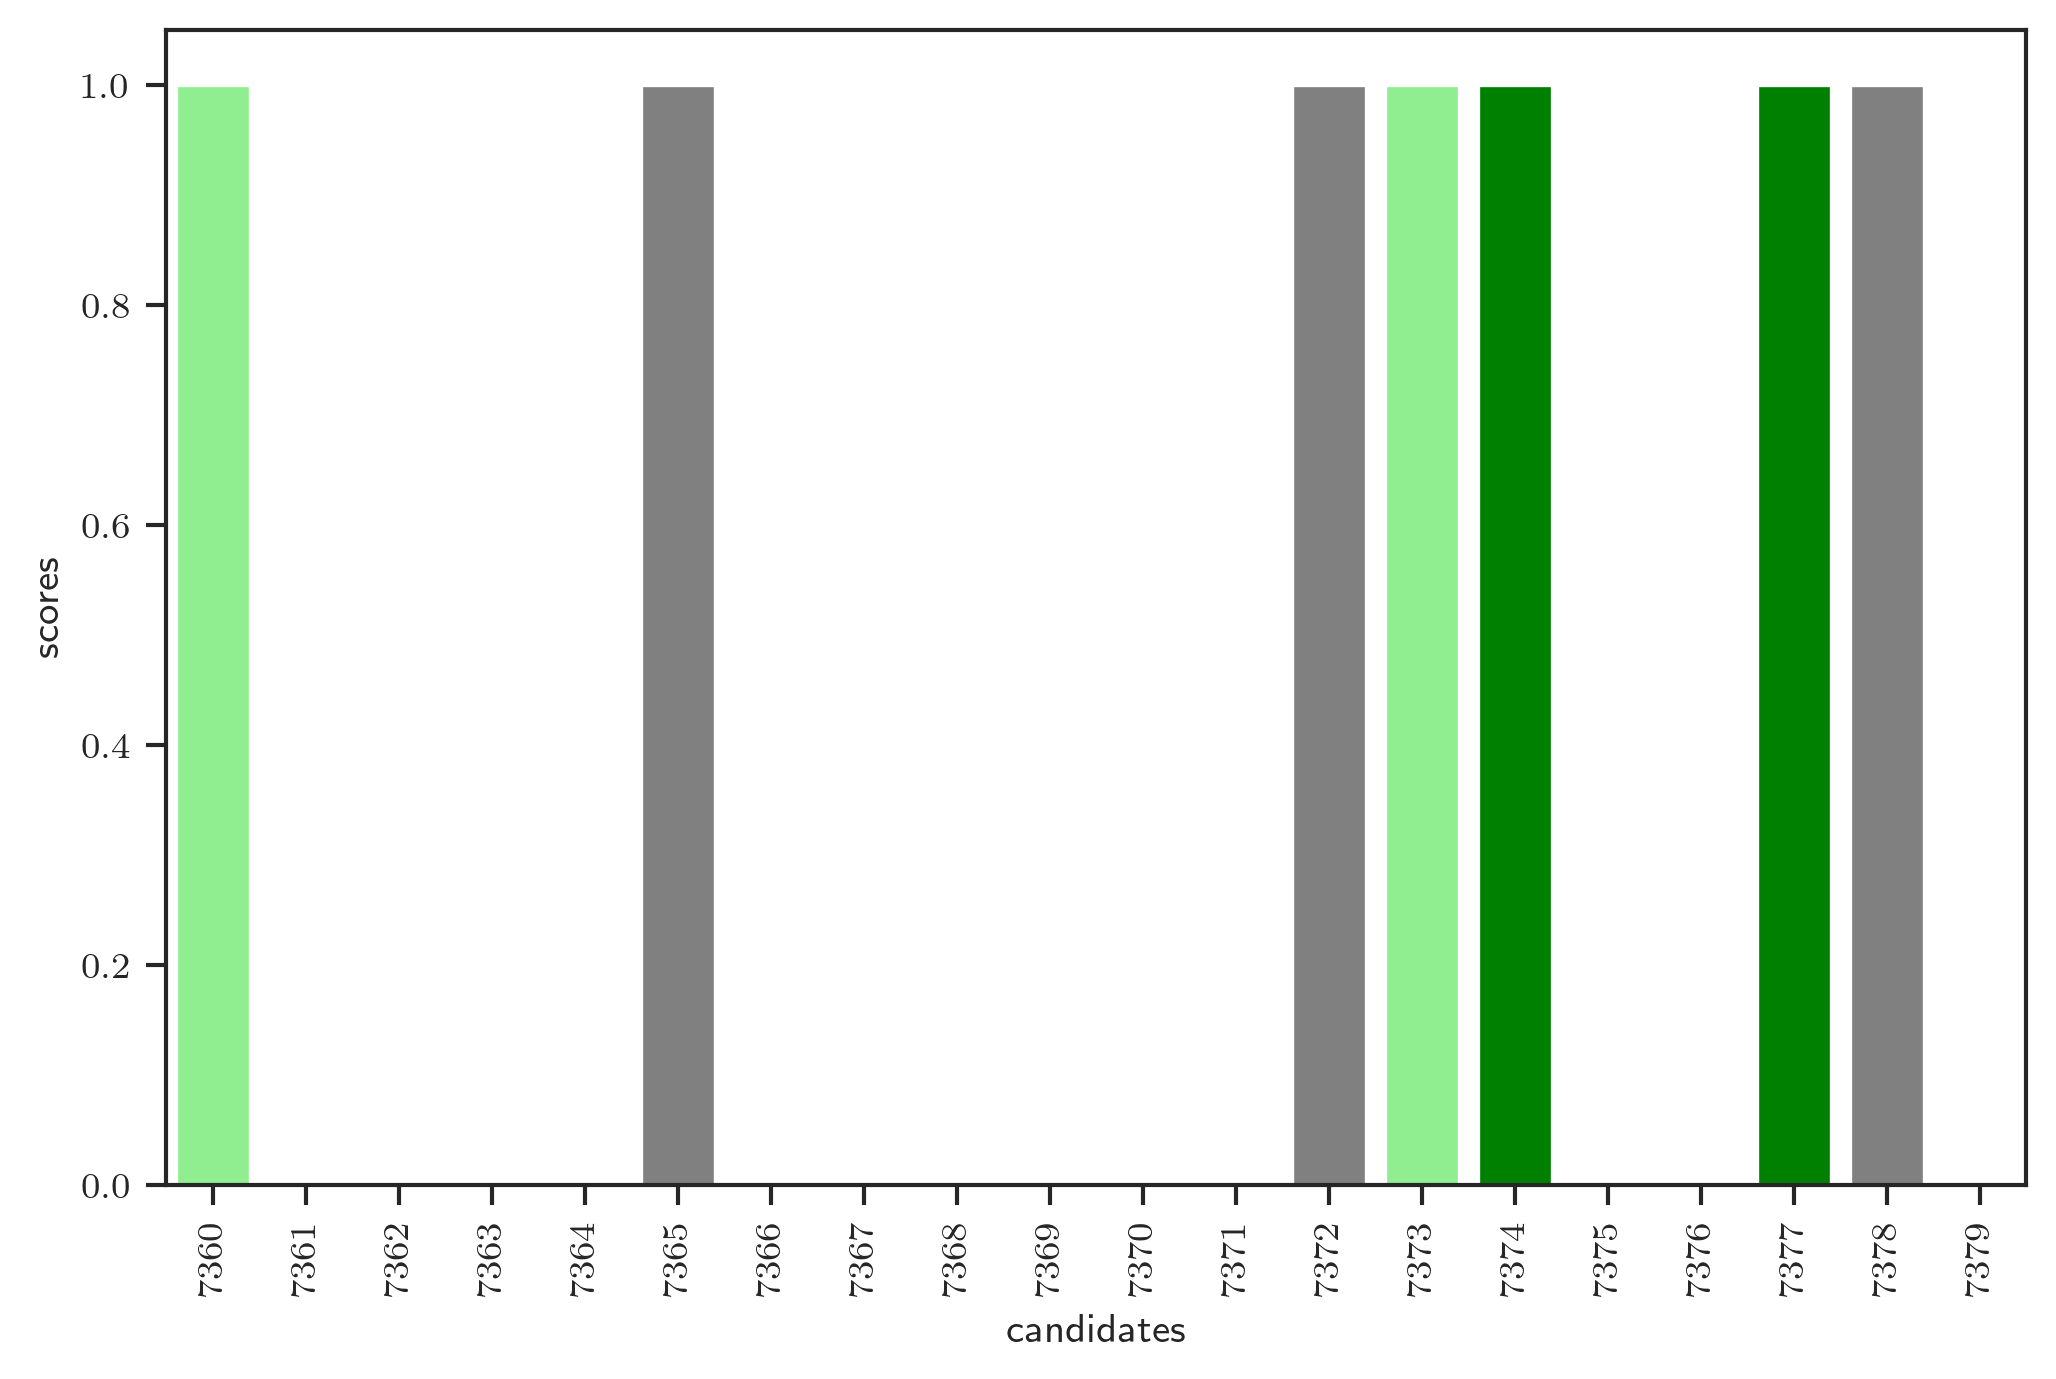

In [144]:
plt.figure(figsize=(8, 5))
plt.tight_layout()
sns.set_style("ticks")
xaxis = range(7380 - threshold, 7380)
plt.bar(
    xaxis, [1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,1,1,0], color=colors
)

plt.xlim(7380 - threshold-0.5, 7379+0.5)
plt.xlabel('candidates')
plt.ylabel('scores')
plt.xticks(xaxis, rotation=90);
plt.savefig("plots/simulated_1_7380_tgat_og.png", bbox_inches='tight')

Navigator: pg_true
Navigator: pg_false
Navigator: dot_true


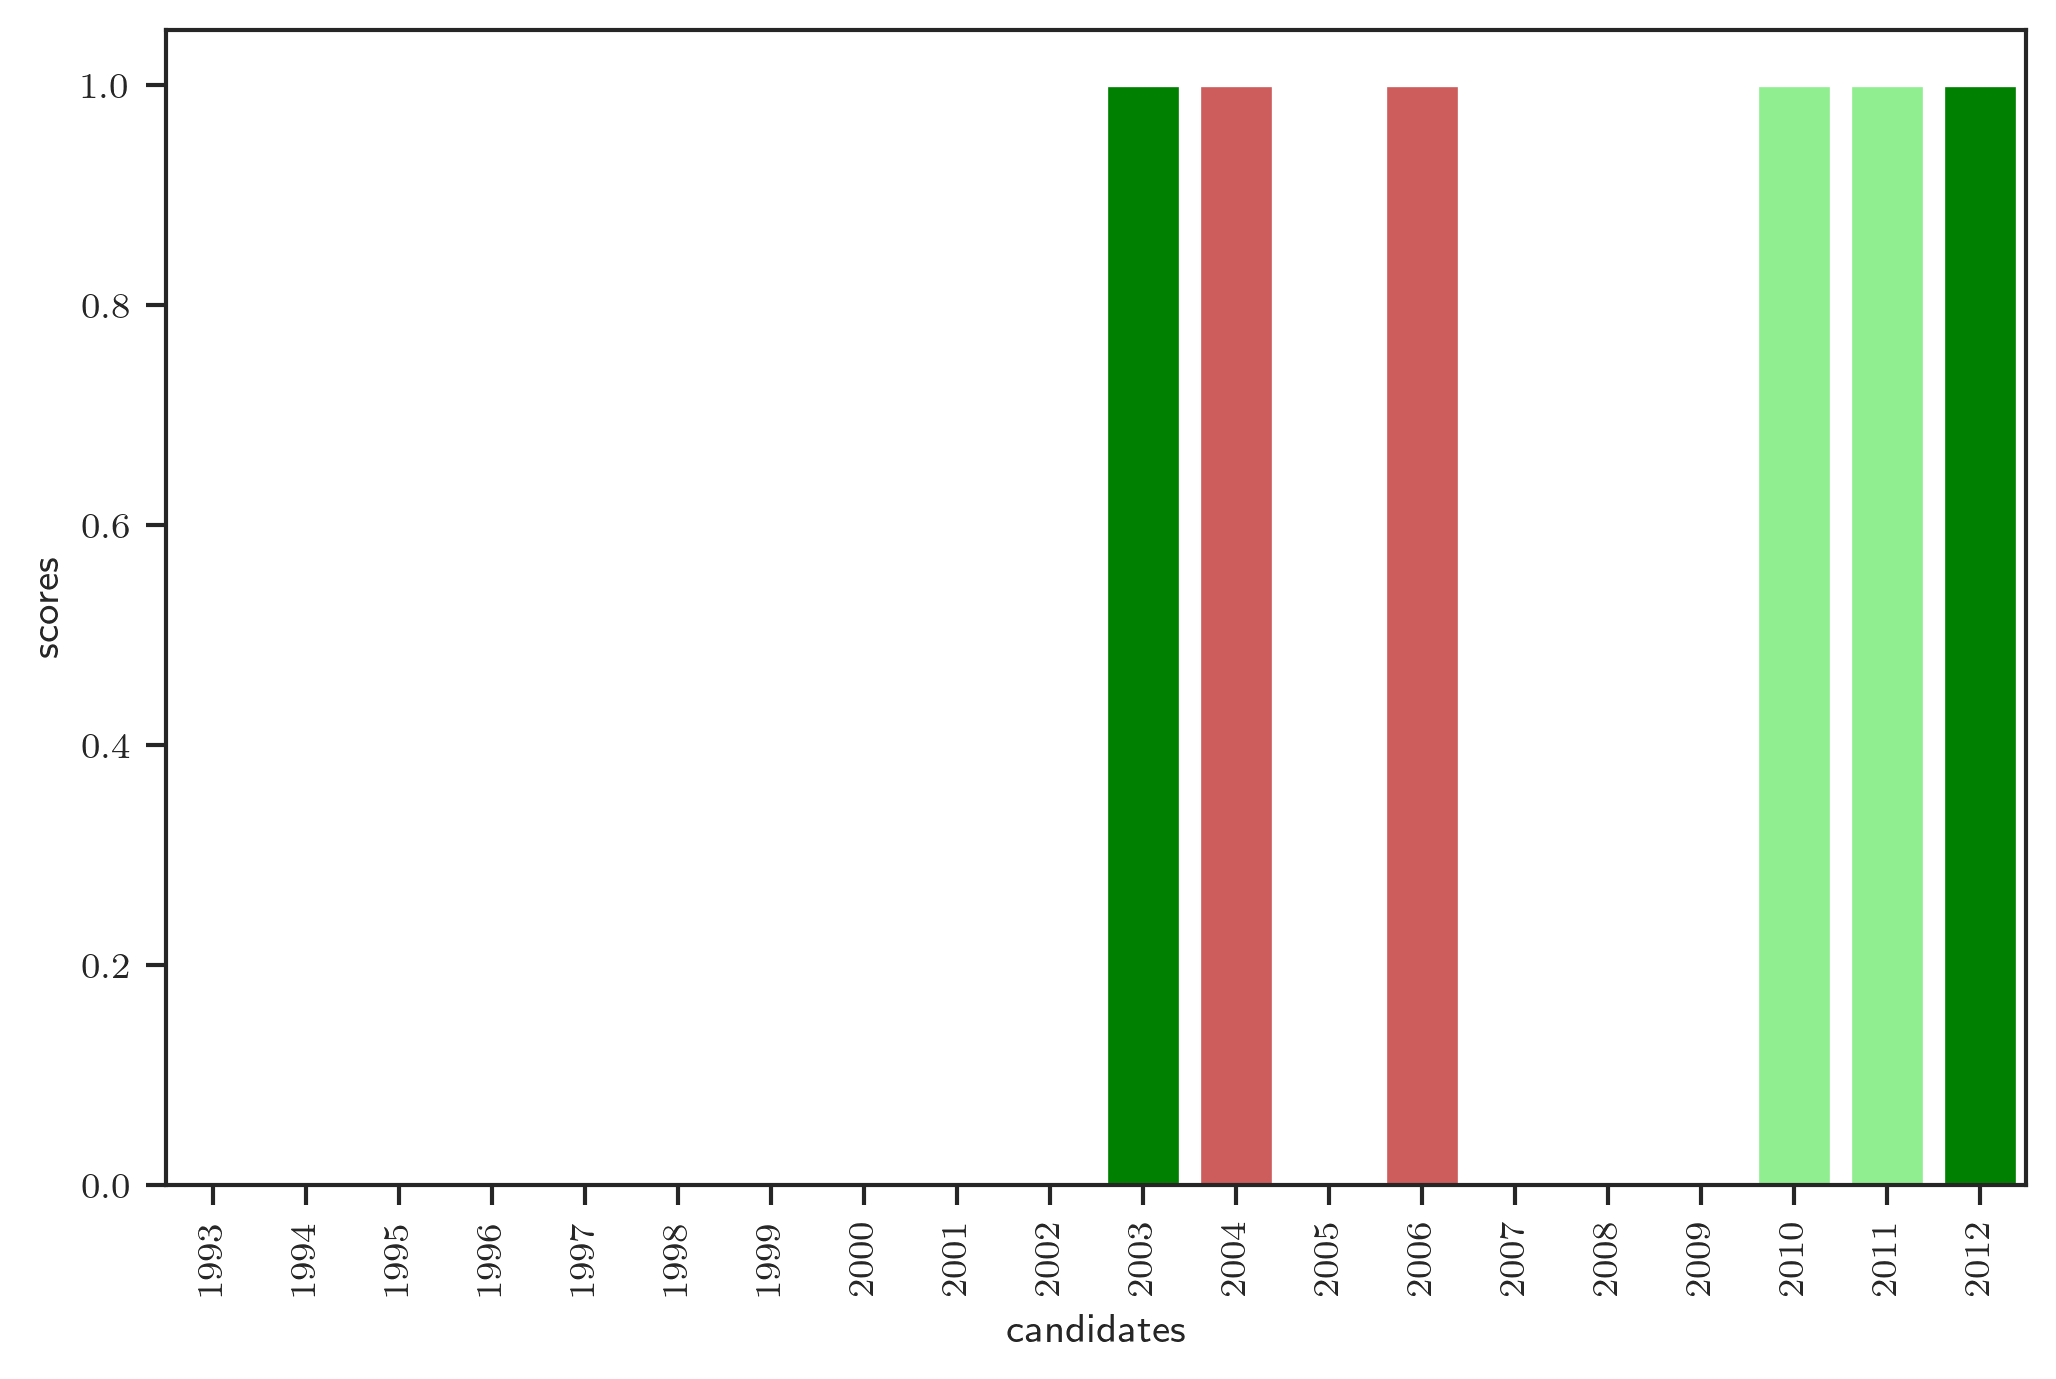

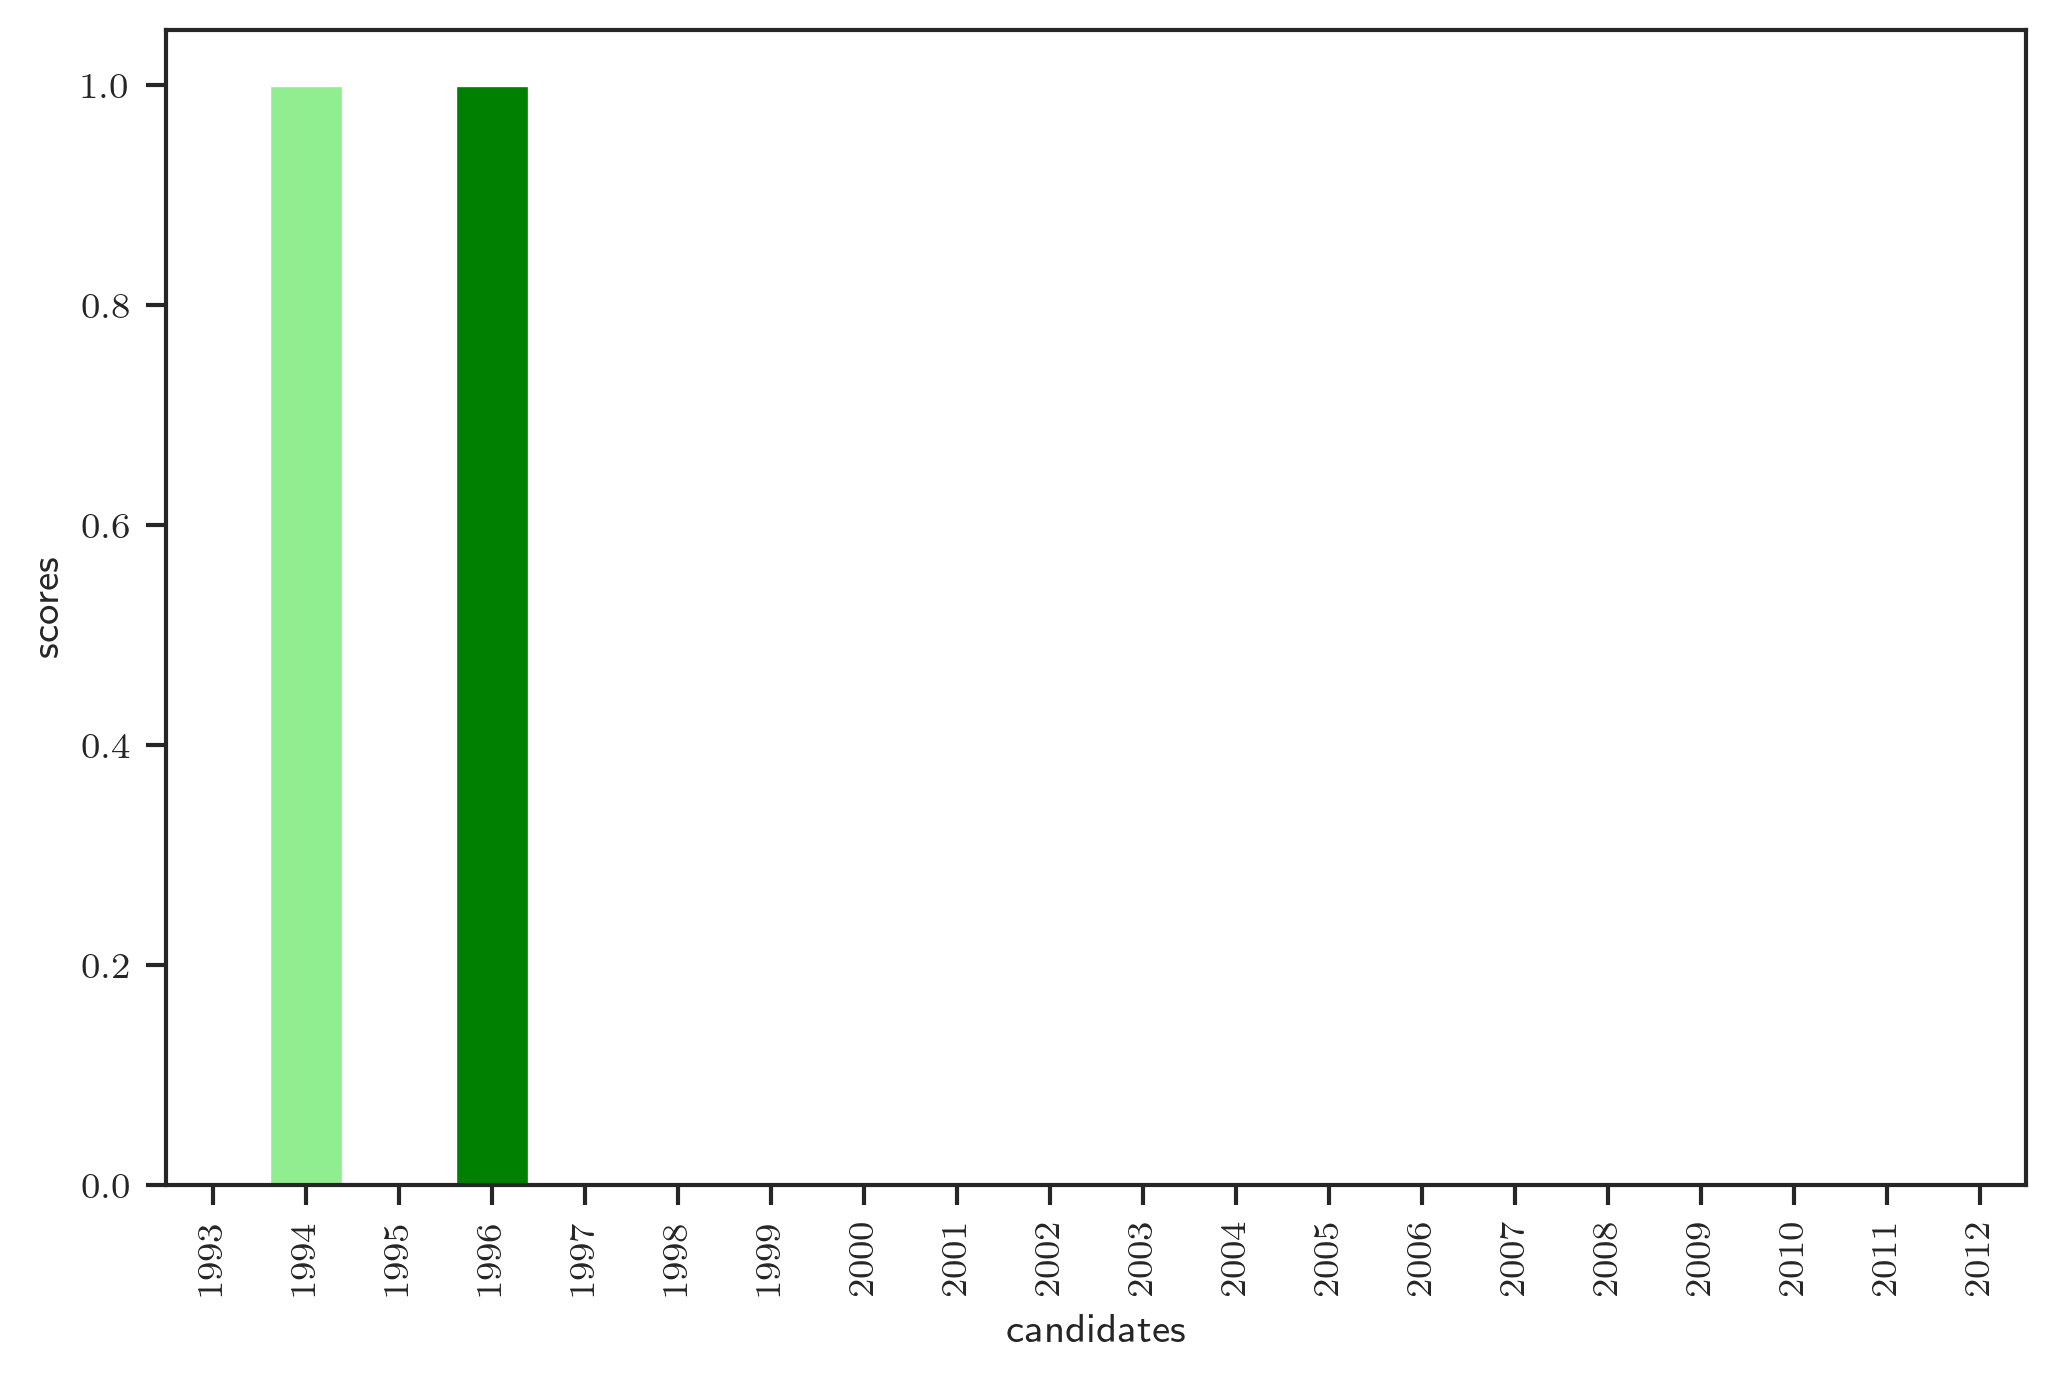

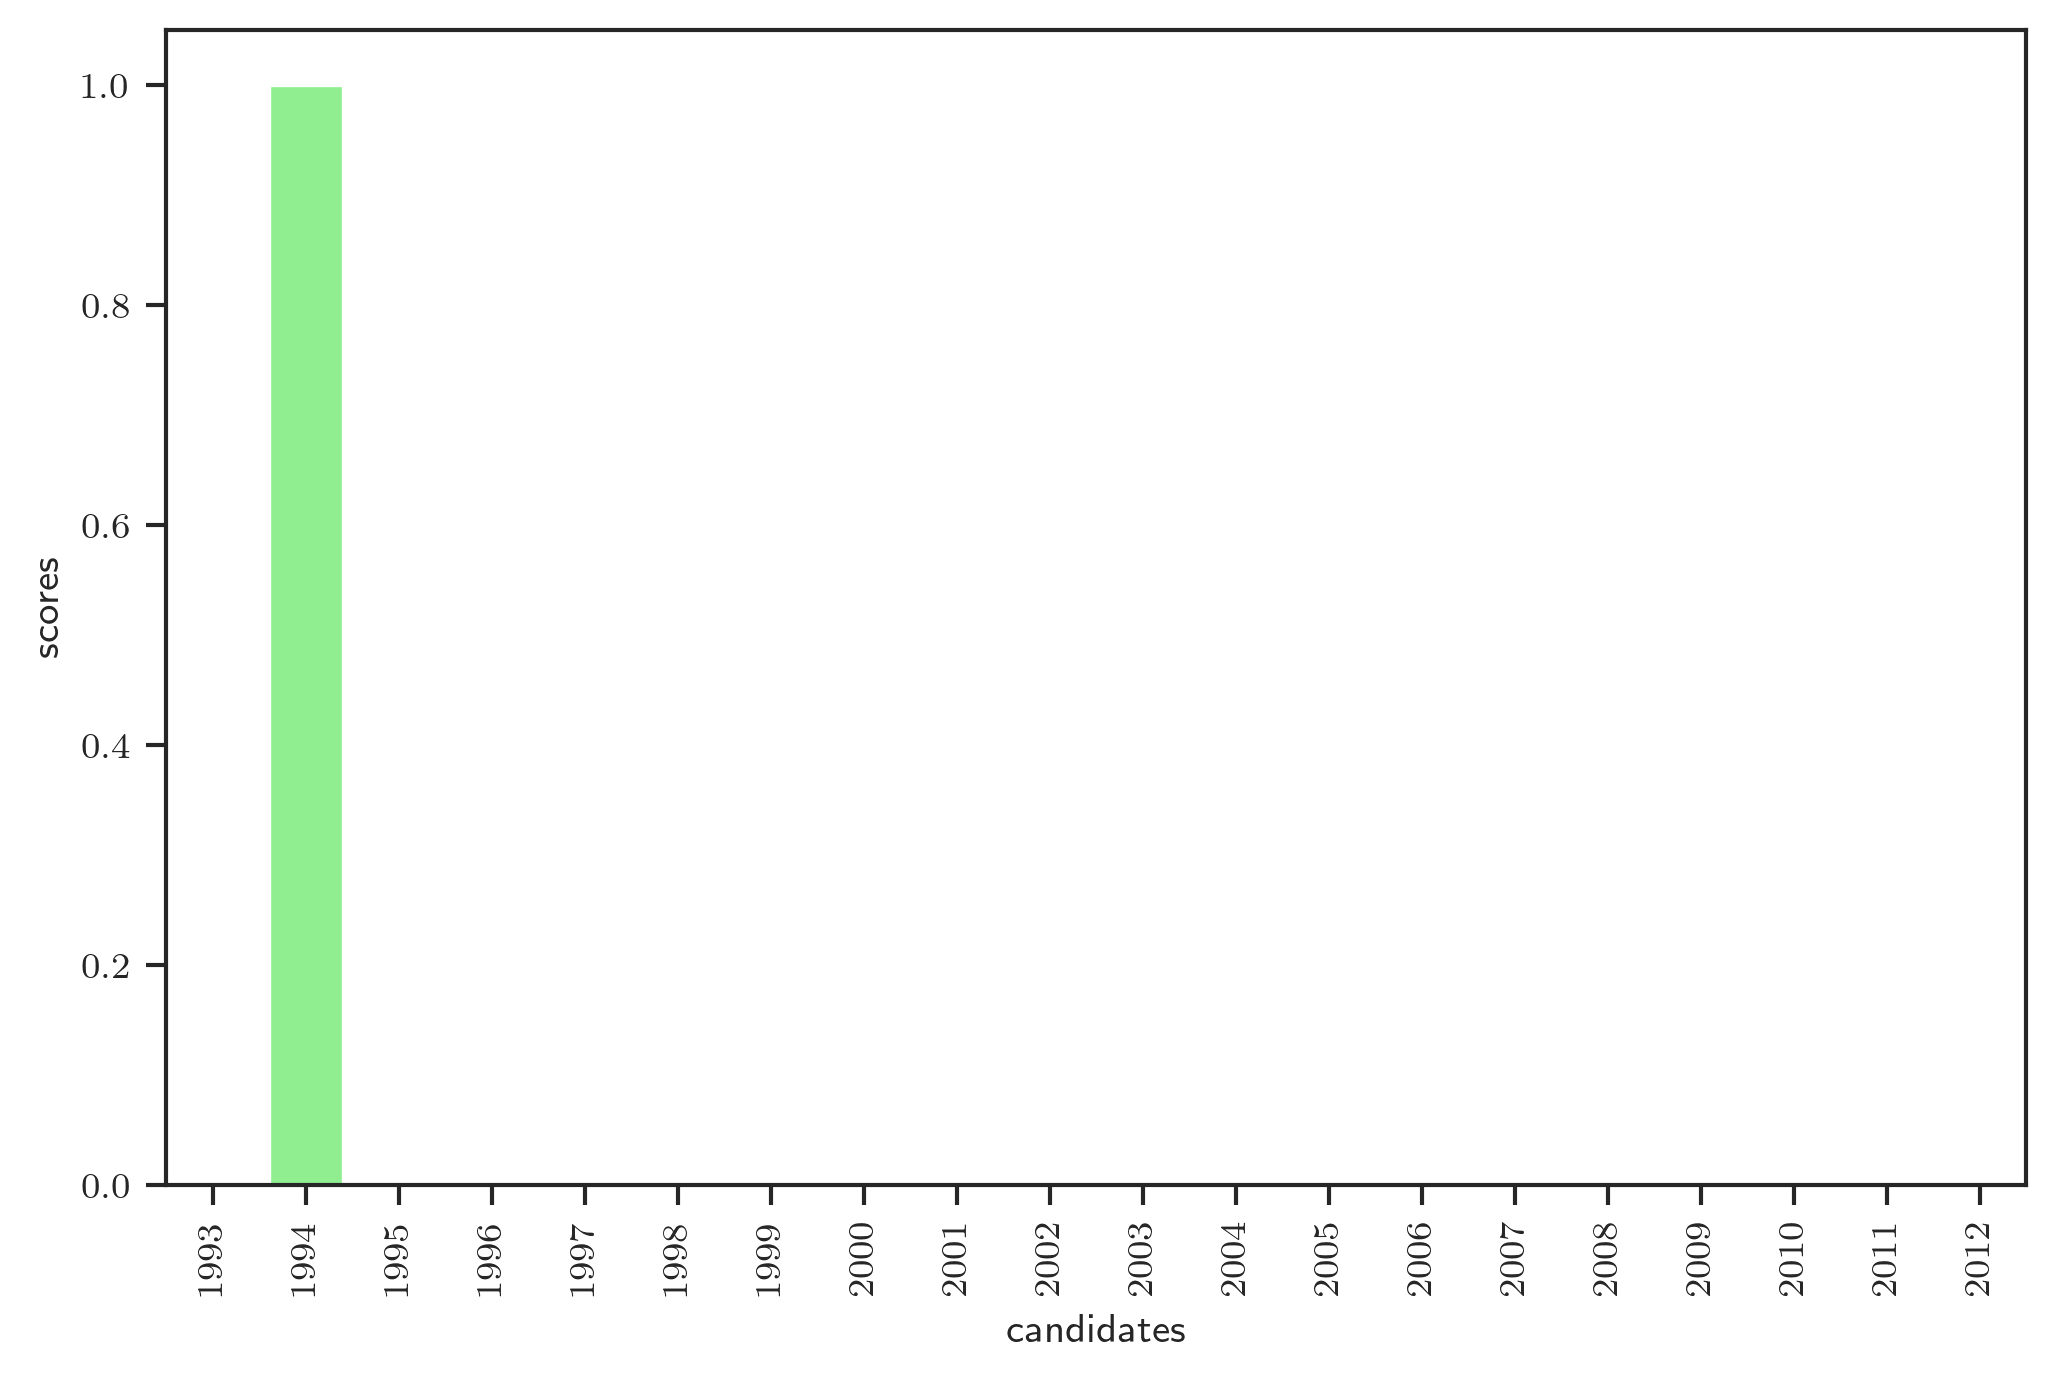

In [145]:
model = "tgn"
threshold = 20
relevancy = [0] * abs(threshold - 20) + [-2,1,1,2,-2,-1,1,2,-2,1,2,-2,2,-2,-2,1,-1,1,1,2]

colors = [get_color(c) for c in relevancy]
xaxis = range(2013 - threshold, 2013)

for navigator in ["pg_true", "pg_false", "dot_true"]:
    print("Navigator:", navigator)
    mcts_node_info = next(
        mcts_path.glob(f"{model}*simulate_v2_2013*{navigator}*{threshold}*")
    )
    # mcts_node_info
    node_info = torch.load(mcts_node_info)
    node_info = node_info["saved_MCTSInfo_list"]  # there is only one key in the dict

    best_expansion = max(node_info, key=lambda x: x["P"])

    plt.figure(figsize=(8, 5))
    plt.tight_layout()
    sns.set_style("ticks")
    plt.bar(
        xaxis,
        [1 if x in best_expansion["coalition"] else 0 for x in xaxis],
        color=colors,
    )

    plt.xlim(2013 - threshold - 0.5, 2013 -1 + 0.5)
    plt.xlabel("candidates")
    plt.ylabel("scores")
    plt.xticks(xaxis, rotation=90)
    plt.savefig(f"plots/simulated_2_2013_{model}_mcts_{navigator}_th{threshold}.png", bbox_inches="tight")
# Rotate the ticks 45 degrees

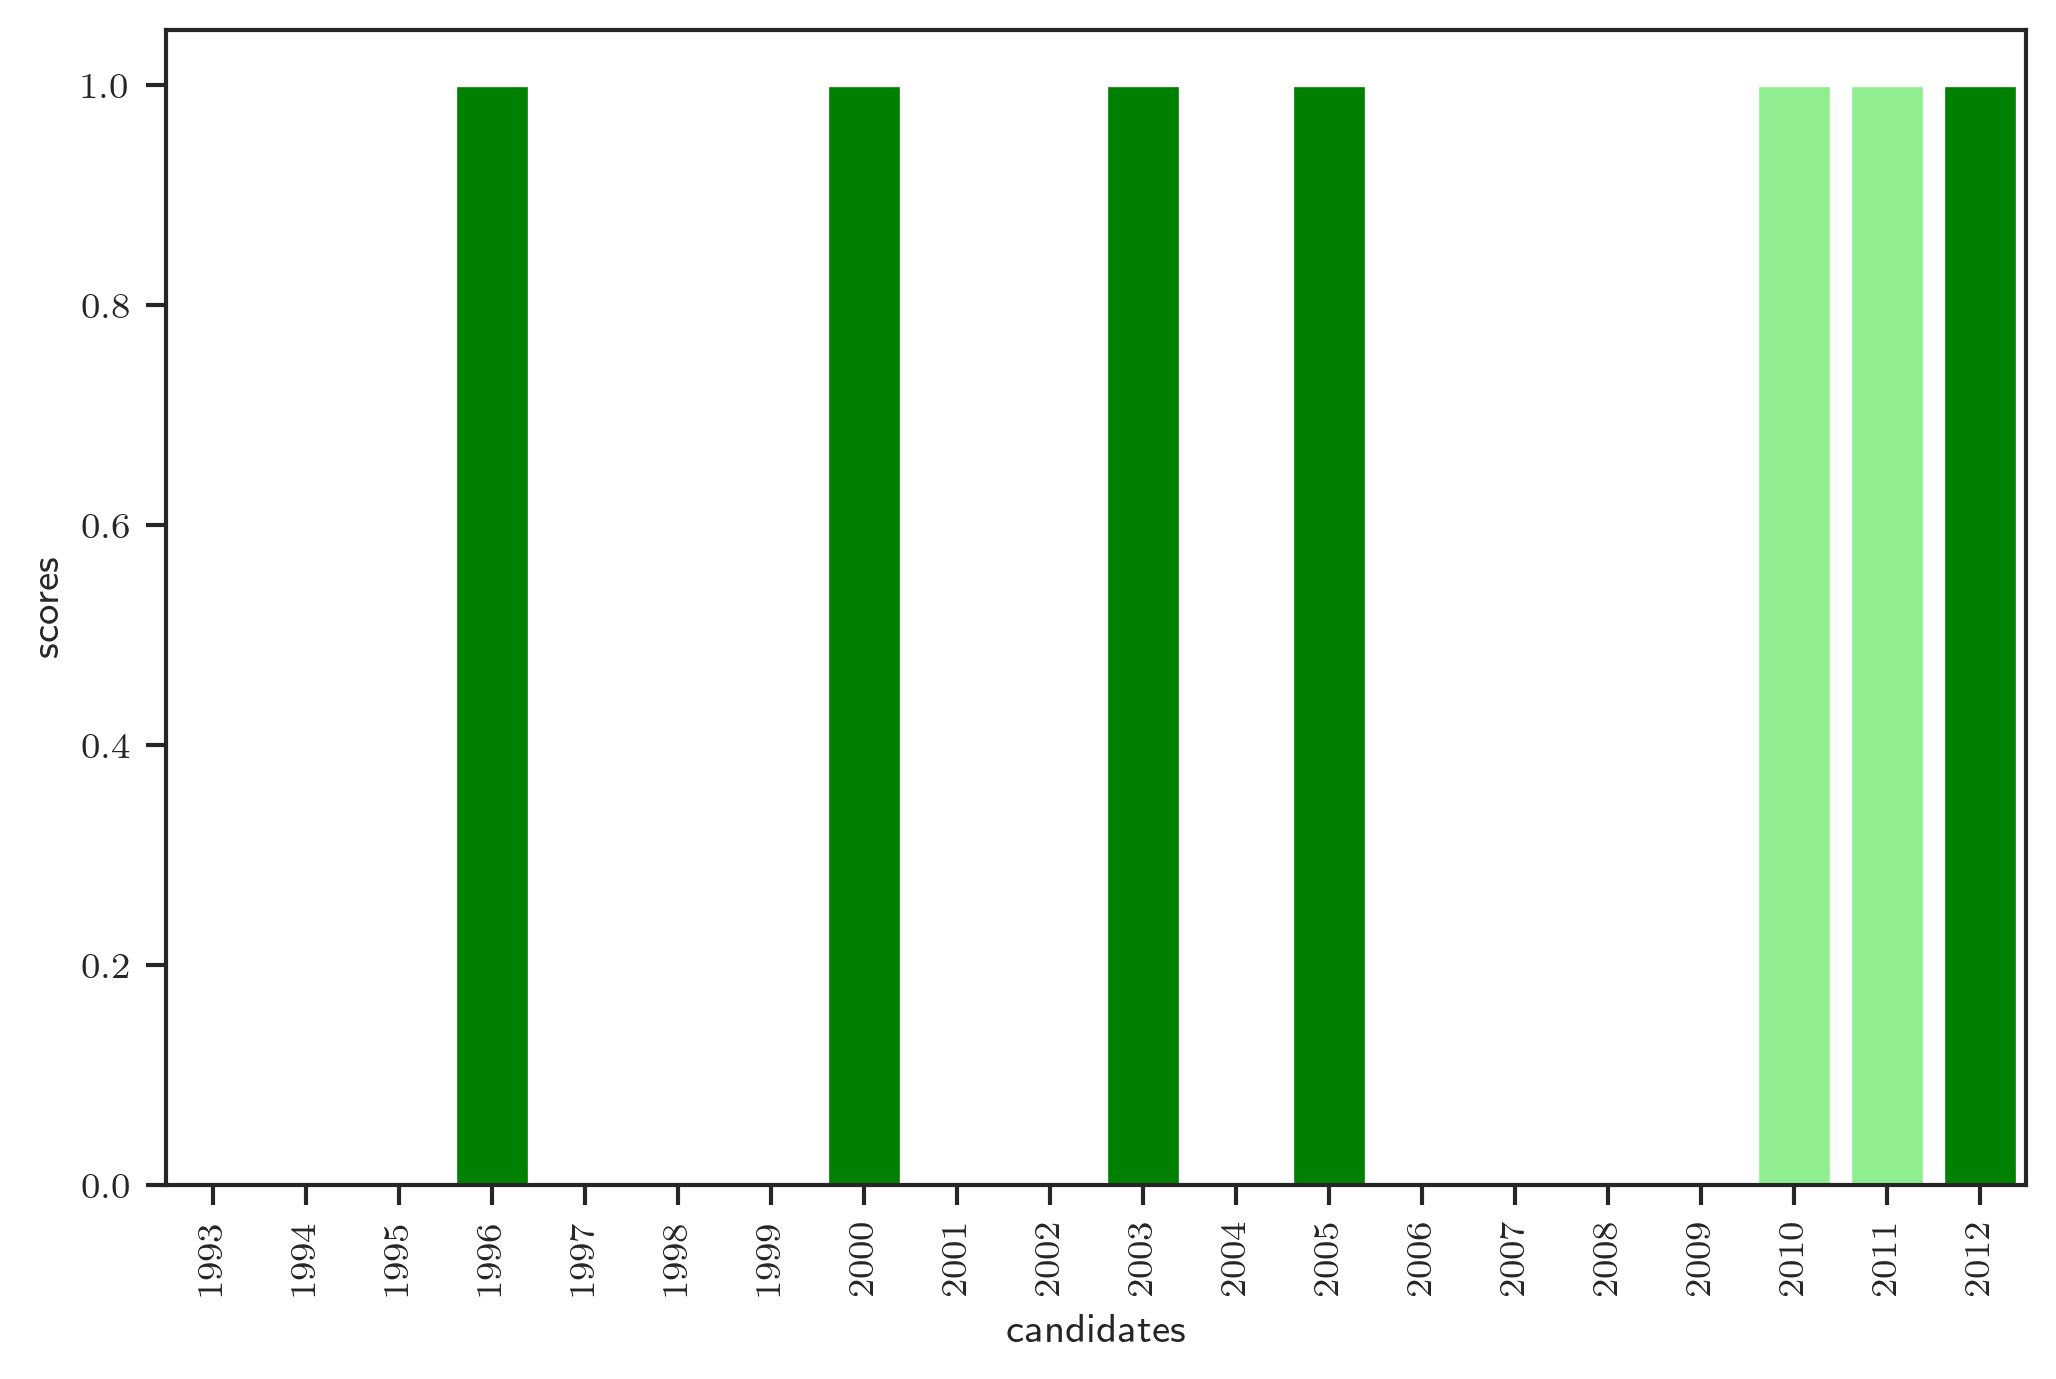

In [146]:
plt.figure(figsize=(8, 5))
plt.tight_layout()
sns.set_style("ticks")
xaxis = range(2013 - threshold, 2013)
plt.bar(
    xaxis, [0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,1], color=colors
)

plt.xlim(2013 - threshold - 0.5, 2012 + 0.5)
plt.xlabel("candidates")
plt.ylabel("scores")
plt.xticks(xaxis, rotation=90)
plt.savefig("plots/simulated_2_2013_tgat_og.png", bbox_inches="tight")

# Runtime comparison

In [147]:
# seconds
training_runtimes = {
    # simulate_v1, simulate_v2, wikipedia, reddit
    "TGAT": [5.0, 6.1, 93, 627.23],
    "TGN": [18.1, 4.2, 84.7, 614],
}

candidate_scores_path = results_path / "candidate_scores"
globs = {
    # XTG, ATTN, PBONE, PG, XTG-D
    k: v
    for k, v in zip(
        ["xtg-og", "xtg-non", "xtg", "xtg-d"],
        [
            "{model}_{dataset}*pg_true*_th20*",
            "{model}_{dataset}*pg_false*_th20*",
            "{model}_{dataset}*mlp_true*_th20*",
            # '{model}_{dataset}*_attn*',
            # '{model}_{dataset}*_pbone*',
            # '{model}_{dataset}*_pg*',
            "{model}_{dataset}*dot_true*_th20*",
        ],
    )
}

model = "tgat"
# model = "tgn"
metric = "runtime"  # rollout, runtime
scores = {}
not_found = []
for explainer in globs:
    scores[explainer] = {}
    for dataset in ["simulate_v1", "simulate_v2", "wikipedia", "reddit"]:
        try:
            glob = candidate_scores_path.glob(
                globs[explainer].format(model=model, dataset=dataset)
            )

            # collate stats for all runs
            arrs = [pd.read_csv(g) for g in glob]
            res = []
            for arr in arrs:
                # find the best score
                boop = arr["best_reward"]
                # normalize
                boop = (boop - boop.min()) / (boop.max() - boop.min())
                # find the idx of the first score above 0.8
                idx = (boop >= 0.8).to_numpy().argmax()
                res.append(arr[metric].to_numpy()[idx])

            sc = np.array(res)

            # filter outliers
            sc = sc[sc - sc.mean() < 3 * sc.std()]
            print(len(sc))
            scores[explainer][dataset] = (sc.mean(), sc.std())
        except (KeyError, StopIteration):
            not_found.append(f"{explainer}_{dataset}")
            continue
print("Not found:", not_found)

# deepcopy to avoid overwriting
explainer_fid_times = pd.DataFrame.from_dict(scores, orient="columns").T
explainer_fid_times = explainer_fid_times.rename(labels, inplace=False).rename(
    dataset_to_index, axis=1, inplace=False
)

explainer_fid_times = explainer_fid_times.applymap(lambda x: f"{x[0]:.2f} ± {x[1]:.1f}")
explainer_fid_latex = (
    explainer_fid_times.style.highlight_min(props="font-weight:bold")
    .to_latex(hrules=True, convert_css=True)
    .replace(
        "\\end{tabular}",
        f"\\end{{tabular}}\n\\caption{{\\label{{tab:{model}_time}}TGNN-X time to 80\% of best fidelity for {model.upper()} model.}}\n",
    )
)

with open(f"{model}_{metric}_tab.tex", "w") as f:
    f.write(explainer_fid_latex)
print(explainer_fid_latex)

101
101
100
100
102
98
99
100
101
101
100
99
102
101
99
99
Not found: []
\begin{tabular}{lllll}
\toprule
 & Synthetic V1 & Synthetic V2 & Wikipedia & Reddit \\
\midrule
PGNavigator & 14.51 ± 10.3 & \bfseries 10.14 ± 11.7 & \bfseries 13.11 ± 12.0 & 16.40 ± 13.4 \\
PGNavigator (NO NAV) & \bfseries 11.02 ± 8.4 & 3.28 ± 4.8 & 16.83 ± 12.3 & 22.26 ± 21.8 \\
MLPNavigator & 12.13 ± 9.4 & 9.70 ± 11.2 & 20.28 ± 16.5 & 15.54 ± 15.6 \\
DotProductNavigator & 12.68 ± 9.6 & 6.85 ± 8.6 & 18.24 ± 14.2 & \bfseries 13.06 ± 12.3 \\
\bottomrule
\end{tabular}
\caption{\label{tab:tgat_time}TGNN-X time to 80\% of best fidelity for TGAT model.}




/var/folders/1x/7k25rxt159j8lx18by4r5yhm0000gn/T/ipykernel_9567/4053398556.py:68: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  explainer_fid_times = explainer_fid_times.applymap(lambda x: f"{x[0]:.2f} ± {x[1]:.1f}")


In [148]:
display(explainer_fid_times)

,Synthetic V1,Synthetic V2,Wikipedia,Reddit
PGNavigator,14.51 ± 10.3,10.14 ± 11.7,13.11 ± 12.0,16.40 ± 13.4
PGNavigator (NO NAV),11.02 ± 8.4,3.28 ± 4.8,16.83 ± 12.3,22.26 ± 21.8
MLPNavigator,12.13 ± 9.4,9.70 ± 11.2,20.28 ± 16.5,15.54 ± 15.6
DotProductNavigator,12.68 ± 9.6,6.85 ± 8.6,18.24 ± 14.2,13.06 ± 12.3


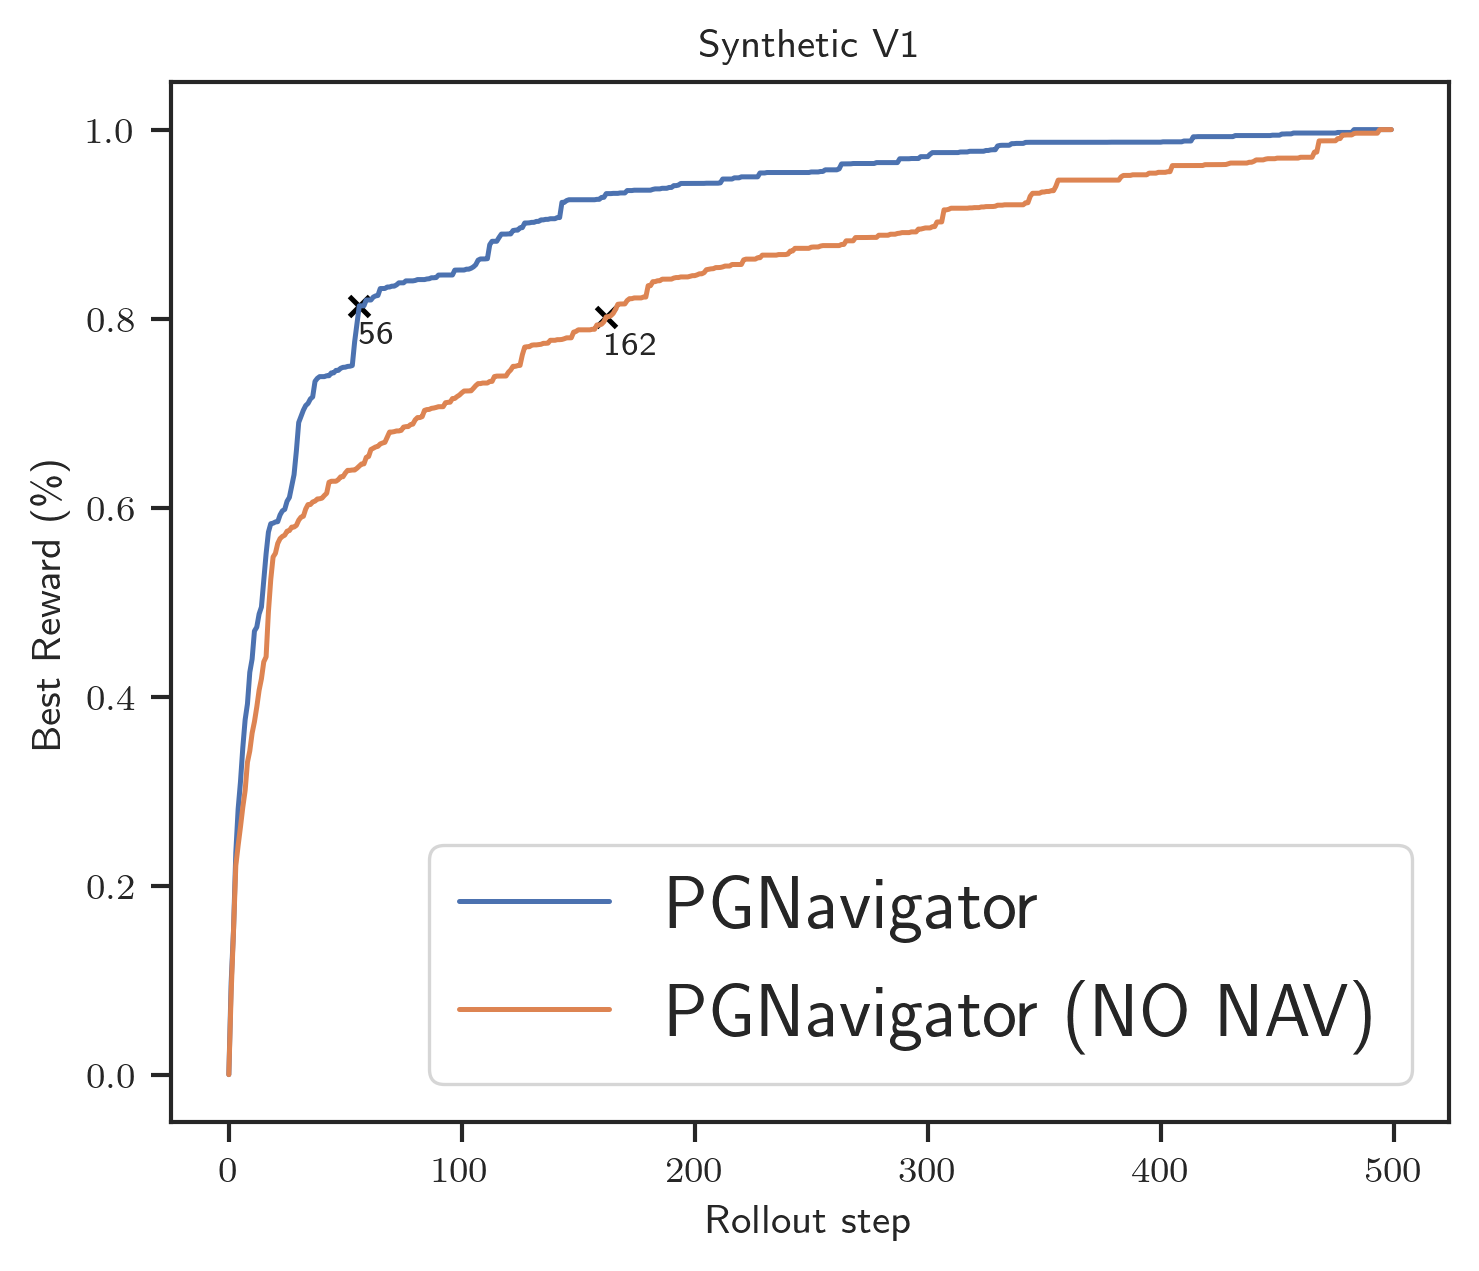

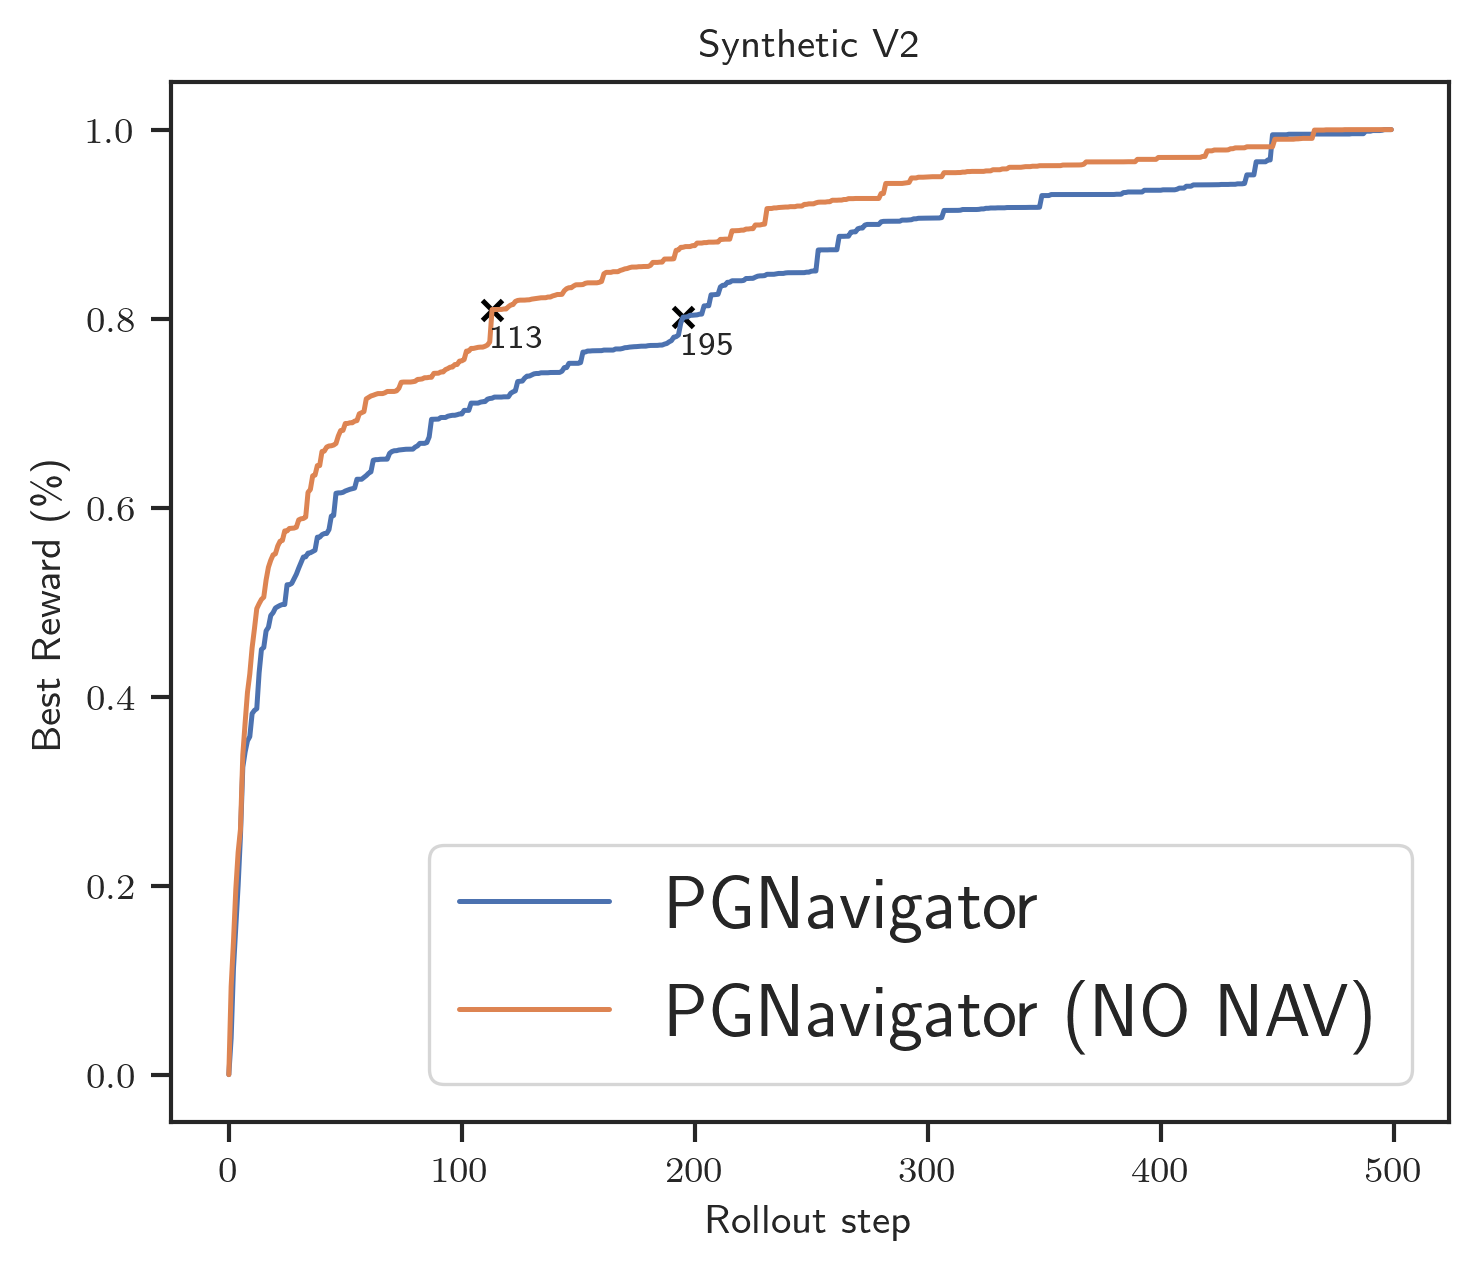

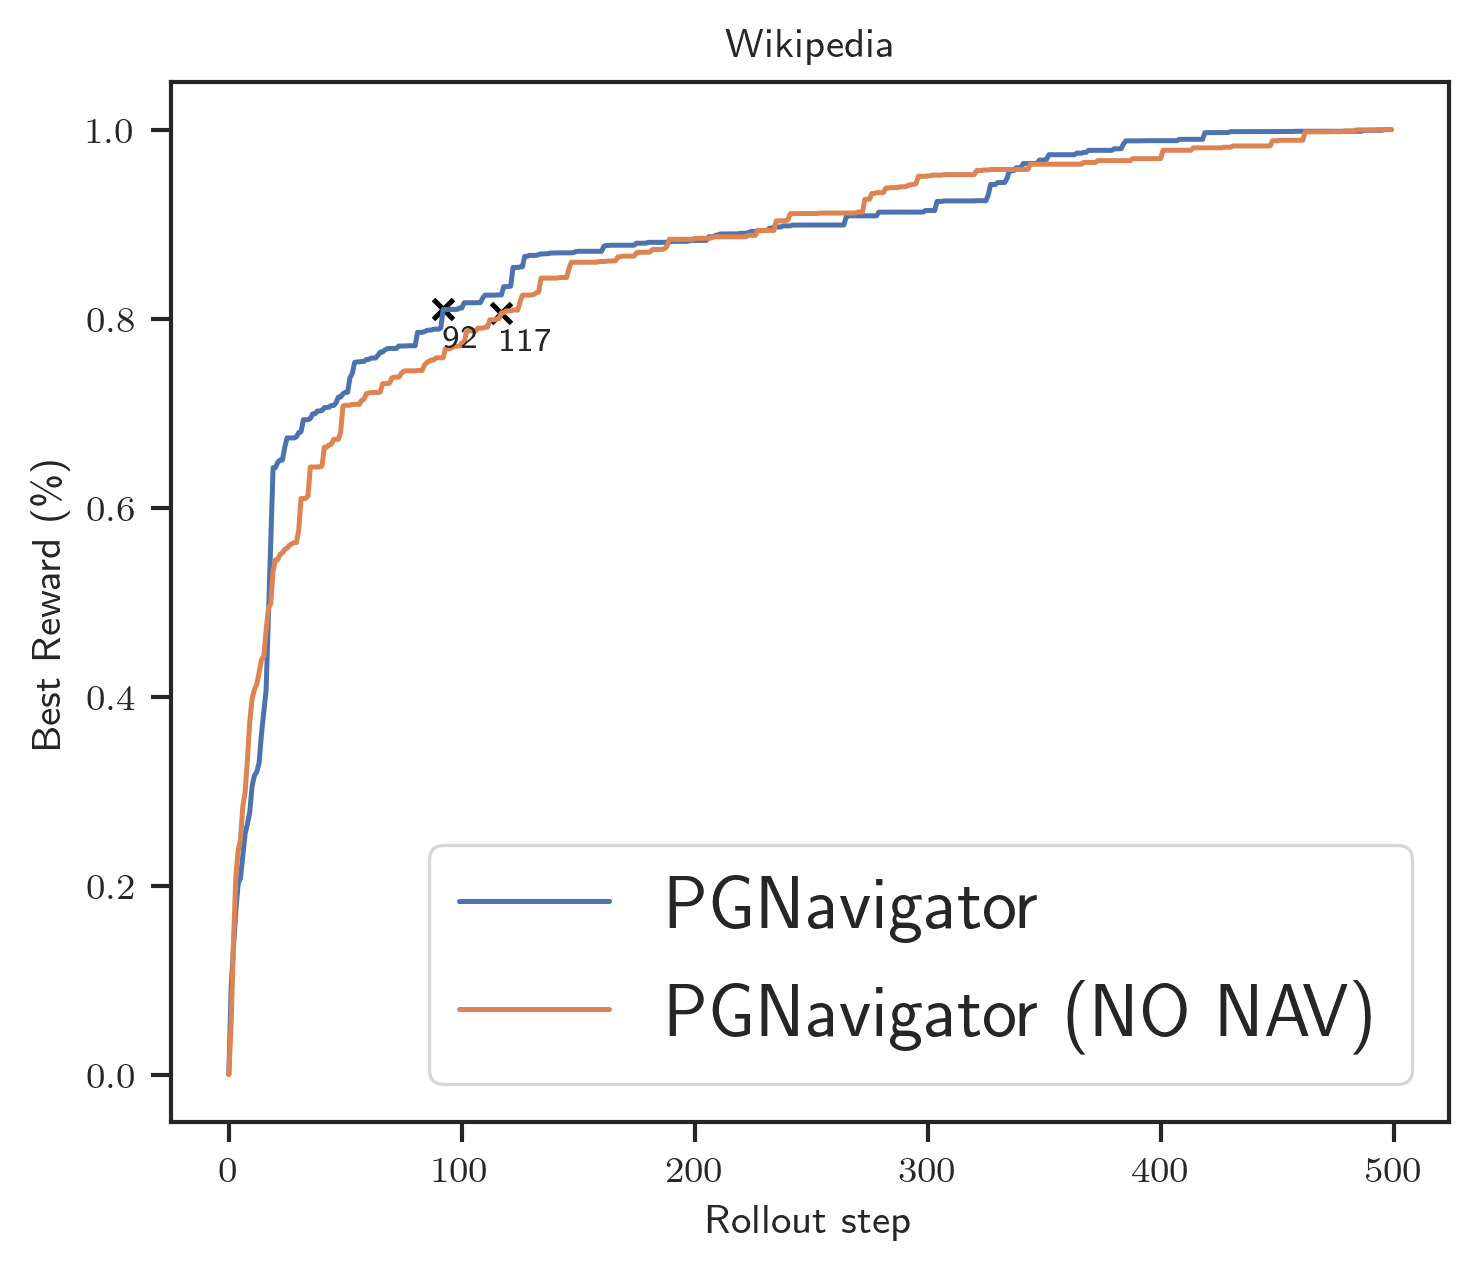

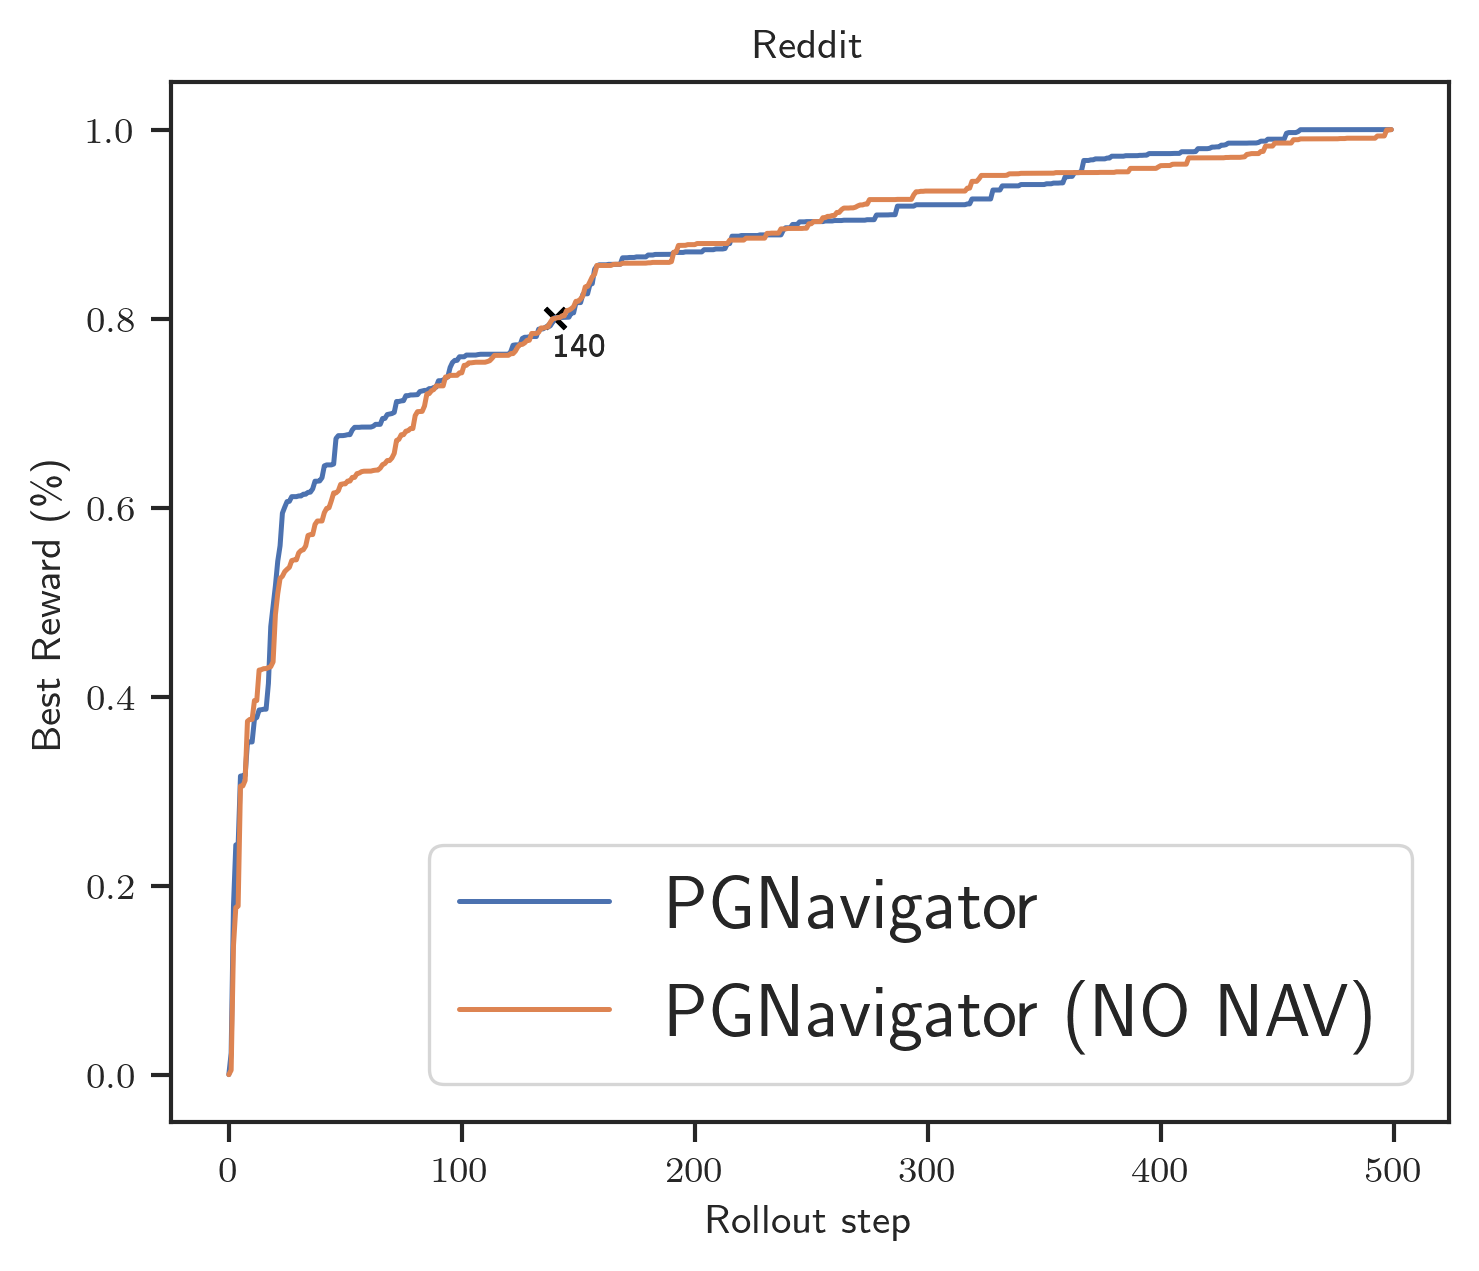

Not found: []


In [150]:
# seconds
training_runtimes = {
    # simulate_v1, simulate_v2, wikipedia, reddit
    "TGAT": [5.0, 6.1, 93, 627.23],
    "TGN": [18.1, 4.2, 84.7, 614],
}

candidate_scores_path = results_path / "candidate_scores"
globs = {
    # XTG, ATTN, PBONE, PG, XTG-D
    k: v
    for k, v in zip(
        ["xtg-og", "xtg-non", "xtg", "xtg-d"],
        [
            "{model}_{dataset}*pg_true*_th20*",
            "{model}_{dataset}*pg_false*_th20*",
            # "{model}_{dataset}*mlp_true*_th20*",
            # '{model}_{dataset}*_attn*',
            # '{model}_{dataset}*_pbone*',
            # '{model}_{dataset}*_pg*',
            # "{model}_{dataset}*dot_true*_th20*",
        ],
    )
}

# model = "tgat"
model = "tgn"
not_found = []
# fig, axs = plt.subplots(2, 2, figsize=(8, 8))
sns.set_style("ticks")
for dataset in ["simulate_v1", "simulate_v2", "wikipedia", "reddit"]:
    for explainer in globs:
        try:
            glob = candidate_scores_path.glob(
                globs[explainer].format(model=model, dataset=dataset)
            )

            # collate stats for all runs
            arrs = [pd.read_csv(g) for g in glob]

            mat = [arr["best_reward"].to_numpy() for arr in arrs]

            mat = np.array(mat).mean(axis=0)
            # normalize
            mat = (mat - mat.min()) / (mat.max() - mat.min())
            index = np.argmax(mat >= 0.8)

            plt.plot(mat, label=labels[explainer])
            plt.scatter(index, mat[index], marker="x", color="black")

            plt.text(index, mat[index]-0.04, f"{index}", fontsize=8)
            # plt.axhline(y=mat[index], color='r', linestyle='dotted')  # draw horizontal line
            # plt.axvline(x=index, color='r', linestyle='dotted')  # draw vertical line

            plt.xlabel("Rollout step")
            plt.ylabel("Best Reward (\%)")

        except (KeyError, StopIteration):
            not_found.append(f"{explainer}_{dataset}")
            continue
    plt.title(dataset_to_index[dataset])
    plt.legend()
    plt.savefig(f"plots/{model}_misc_rollout_plot_{dataset}.png")
    plt.show()
print("Not found:", not_found)
